In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import speclite.filters as sp
from speclite import filters
from scipy.ndimage import sum_labels, mean
from scipy.stats import linregress, spearmanr


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

In [2]:
# Load gas line map IC3392_gas_BIN_maps.fits 
gas_path = Path('IC3392_gas_BIN_maps_extended.fits')
print(f"Loading gas line map from {gas_path}")
with fits.open(gas_path) as hdul:
    V_STARS2 = hdul['V_STARS2'].data
    SIGMA_STARS2 = hdul['SIGMA_STARS2'].data
    HB4861_FLUX = hdul['HB4861_FLUX'].data
    HB4861_FLUX_ERR = hdul['HB4861_FLUX_ERR'].data
    HA6562_FLUX = hdul['HA6562_FLUX'].data
    HA6562_FLUX_ERR = hdul['HA6562_FLUX_ERR'].data
    OIII5006_FLUX = hdul['OIII5006_FLUX'].data
    OIII5006_FLUX_ERR = hdul['OIII5006_FLUX_ERR'].data
    NII6583_FLUX = hdul['NII6583_FLUX'].data
    NII6583_FLUX_ERR = hdul['NII6583_FLUX_ERR'].data
    SII6716_FLUX = hdul['SII6716_FLUX'].data
    SII6716_FLUX_ERR = hdul['SII6716_FLUX_ERR'].data
    SII6730_FLUX = hdul['SII6730_FLUX'].data
    SII6730_FLUX_ERR = hdul['SII6730_FLUX_ERR'].data
    gas_header = hdul[5].header
    hdul.close()

gas_header

Loading gas line map from IC3392_gas_BIN_maps_extended.fits


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  437                                                  
NAXIS2  =                  438                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            
CRPIX2  =      219.93673592818 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [3]:
kin_path = Path('IC3392_KIN_maps_extended.fits')
if kin_path.exists():
    print(f"Loading kinematic map from {kin_path}")
    with fits.open(kin_path) as hdul:
        kin_info = hdul.info()
        
        # Read data from all extensions except PRIMARY
        extension_names = [hdul[i].name for i in range(1, len(hdul))]
        print(f"Available extensions: {extension_names}")
        
        # Read each extension's data before closing the file
        for ext_name in extension_names:
            if ext_name and ext_name != "PRIMARY":
                globals()[ext_name] = hdul[ext_name].data
                print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")
    
    print("All data loaded successfully!")
    hdul.close()
    # Invert the true/false in FOREGROUND_STAR, but except the nan values
    non_FOREGROUND_STAR = np.where(np.isnan(FOREGROUND_STAR), np.nan, ~FOREGROUND_STAR.astype(bool))

    V_STARS2 = np.where(non_FOREGROUND_STAR, V_STARS2, np.nan)
    SIGMA_STARS2 = np.where(non_FOREGROUND_STAR, SIGMA_STARS2, np.nan)
    HB4861_FLUX = np.where(non_FOREGROUND_STAR, HB4861_FLUX, np.nan)
    HB4861_FLUX_ERR = np.where(non_FOREGROUND_STAR, HB4861_FLUX_ERR, np.nan)
    HA6562_FLUX = np.where(non_FOREGROUND_STAR, HA6562_FLUX, np.nan)
    HA6562_FLUX_ERR = np.where(non_FOREGROUND_STAR, HA6562_FLUX_ERR, np.nan)
    OIII5006_FLUX = np.where(non_FOREGROUND_STAR, OIII5006_FLUX, np.nan)
    OIII5006_FLUX_ERR = np.where(non_FOREGROUND_STAR, OIII5006_FLUX_ERR, np.nan)
    NII6583_FLUX = np.where(non_FOREGROUND_STAR, NII6583_FLUX, np.nan)
    NII6583_FLUX_ERR = np.where(non_FOREGROUND_STAR, NII6583_FLUX_ERR, np.nan)
    SII6716_FLUX = np.where(non_FOREGROUND_STAR, SII6716_FLUX, np.nan)
    SII6716_FLUX_ERR = np.where(non_FOREGROUND_STAR, SII6716_FLUX_ERR, np.nan)
    SII6730_FLUX = np.where(non_FOREGROUND_STAR, SII6730_FLUX, np.nan)
    SII6730_FLUX_ERR = np.where(non_FOREGROUND_STAR, SII6730_FLUX_ERR, np.nan)
    print("Foreground stars are removed successfully!")

else:
    print(f"File not found: {kin_path}")

File not found: IC3392_KIN_maps_extended.fits


In [4]:
# # Define a function to apply signal to noise cut at lines, then return the masks
# def apply_cut(flux, flux_err, cut=0):
#     """
#     Apply a signal-to-noise ratio (SNR) cut to the flux and flux error arrays.
    
#     Parameters:
#     - flux: 2D numpy array of flux values.
#     - flux_err: 2D numpy array of flux error values.
#     - cut: Minimum SNR value to keep a pixel.
    
#     Returns:
#     - mask: 2D boolean numpy array where True indicates pixels that pass the SNR cut.
#     """
#     snr = flux / flux_err
#     mask = (snr >= cut)
#     return mask

# # Apply SNR cut for each line
# cut = 15  # Define the SNR cut value
# HB4861_FLUX_above = apply_cut(HB4861_FLUX, HB4861_FLUX_ERR, cut)
# HA6562_FLUX_above = apply_cut(HA6562_FLUX, HA6562_FLUX_ERR, cut)
# OIII5006_FLUX_above = apply_cut(OIII5006_FLUX, OIII5006_FLUX_ERR, cut)
# NII6583_FLUX_above = apply_cut(NII6583_FLUX, NII6583_FLUX_ERR, cut)
# SII6716_FLUX_above = apply_cut(SII6716_FLUX, SII6716_FLUX_ERR, cut)
# SII6730_FLUX_above = apply_cut(SII6730_FLUX, SII6730_FLUX_ERR, cut)

In [5]:


# Define a function to calculate the Balmer Decrement, 
# with an argument to decide calculate the raw BD, or the corrected BD (i.e., if raw BD < 2.86, then corrected BD = 2.86)
def calculate_balmer_decrement(HB4861_FLUX, HA6562_FLUX, corrected=True):
    BD = HA6562_FLUX / HB4861_FLUX
    # check if an element in BD is NaN or infinite, but it is finite in V_STARS2, then set this element to 2.86
    BD[(~np.isfinite(BD)*np.isfinite(V_STARS2))] = 2.86
    if corrected:
        BD = np.where(BD < 2.86, 2.86, BD)
    return BD

# Calculate the Balmer Decrement
BD = calculate_balmer_decrement(HB4861_FLUX, HA6562_FLUX, corrected=True)
# 

# Calzetti (2000) curve
def calzetti_curve(wavelengths):
    """Calzetti (2000) extinction curve."""
    # Convert single values to array
    if np.isscalar(wavelengths):
        wavelengths = np.array([wavelengths])
        
    # Calzetti (2000) parameters
    Rv = 4.05  # R_V for Calzetti law
    A_lambda = np.zeros_like(wavelengths, dtype=float)
    
    # Calculate the extinction for each wavelength
    mask_short = wavelengths < 6300
    
    # Short wavelengths
    A_lambda[mask_short] = 2.659 * (-2.156 + 1.509/wavelengths[mask_short] 
                                   - 0.198/wavelengths[mask_short]**2 
                                   + 0.011/wavelengths[mask_short]**3) + Rv
    # Long wavelengths
    A_lambda[~mask_short] = 2.659 * (-1.857 + 1.040/wavelengths[~mask_short]) + Rv
    
    return A_lambda[0] if np.isscalar(wavelengths) else A_lambda

# Calculate k values for Hβ and Hα
k_HB4861 = calzetti_curve(0.4861)  # Hβ
k_HA6562 = calzetti_curve(0.6562)  # Hα
k_OIII5006 = calzetti_curve(0.5006)  # [OIII] 5006
k_NII6583 = calzetti_curve(0.6583)  # [NII] 6583
k_SII6716 = calzetti_curve(0.6716)  # [SII] 6716
k_SII6730 = calzetti_curve(0.6730)  # [SII] 6730

R_int = 2.86

# Define a function to convert the BD to gas E(B-V) 
# using the formula E(B-V)_BD = 2.5/(k_HB4861 - k_HA6562) * np.log10(BD/R_int)
def convert_bd_to_ebv(BD, k_HB4861, k_HA6562, R_int=2.86):
    E_BV_BD = 2.5 / (k_HB4861 - k_HA6562) * np.log10(BD / R_int)
    return E_BV_BD

# Calculate the gas E(B-V) from BD
E_BV_BD = convert_bd_to_ebv(BD, k_HB4861, k_HA6562, R_int)

# Use E(B-V)_BD to correct the fluxes
def correct_flux_with_ebv(flux, ebv, k):
    """Correct flux with gas E(B-V) and extinction coefficient k."""
    return flux * 10**(0.4 * k * ebv)

# Correct the fluxes with E(B-V)_BD
HB4861_FLUX_corr = correct_flux_with_ebv(HB4861_FLUX, E_BV_BD, k_HB4861)
HA6562_FLUX_corr = correct_flux_with_ebv(HA6562_FLUX, E_BV_BD, k_HA6562)
OIII5006_FLUX_corr = correct_flux_with_ebv(OIII5006_FLUX, E_BV_BD, k_OIII5006)
NII6583_FLUX_corr = correct_flux_with_ebv(NII6583_FLUX, E_BV_BD, k_NII6583)
SII6716_FLUX_corr = correct_flux_with_ebv(SII6716_FLUX, E_BV_BD, k_SII6716)
SII6730_FLUX_corr = correct_flux_with_ebv(SII6730_FLUX, E_BV_BD, k_SII6730)

##################

# Define a function to apply signal to noise cut at lines, then return the masks
def apply_cut(cut=3): 
    # cut_above = {
    #     'HB4861': (HB4861_FLUX / HB4861_FLUX_ERR) >= cut,
    #     'HA6562': (HA6562_FLUX / HA6562_FLUX_ERR) >= cut,
    #     'OIII5006': (OIII5006_FLUX_corr / OIII5006_FLUX_ERR) >= cut,
    #     'NII6583': (NII6583_FLUX_corr / NII6583_FLUX_ERR) >= cut,
    #     'SII6716': (SII6716_FLUX_corr / SII6716_FLUX_ERR) >= cut,
    #     'SII6730': (SII6730_FLUX_corr / SII6730_FLUX_ERR) >= cut
    # }
    # cut_below = {
    #     'HB4861': (HB4861_FLUX / HB4861_FLUX_ERR) < cut,
    #     'HA6562': (HA6562_FLUX / HA6562_FLUX_ERR) < cut,
    #     'OIII5006': (OIII5006_FLUX_corr / OIII5006_FLUX_ERR) < cut,
    #     'NII6583': (NII6583_FLUX_corr / NII6583_FLUX_ERR) < cut,
    #     'SII6716': (SII6716_FLUX_corr / SII6716_FLUX_ERR) < cut,
    #     'SII6730': (SII6730_FLUX_corr / SII6730_FLUX_ERR) < cut
    # }
    cut_above = {
        'HB4861': (HB4861_FLUX / HB4861_FLUX_ERR) >= cut,
        'HA6562': (HA6562_FLUX / HA6562_FLUX_ERR) >= cut,
        'OIII5006': (OIII5006_FLUX / OIII5006_FLUX_ERR) >= cut,
        'NII6583': (NII6583_FLUX / NII6583_FLUX_ERR) >= cut,
        'SII6716': (SII6716_FLUX / SII6716_FLUX_ERR) >= cut,
        'SII6730': (SII6730_FLUX / SII6730_FLUX_ERR) >= cut
    }
    cut_below = {
        'HB4861': (HB4861_FLUX / HB4861_FLUX_ERR) < cut,
        'HA6562': (HA6562_FLUX / HA6562_FLUX_ERR) < cut,
        'OIII5006': (OIII5006_FLUX / OIII5006_FLUX_ERR) < cut,
        'NII6583': (NII6583_FLUX / NII6583_FLUX_ERR) < cut,
        'SII6716': (SII6716_FLUX / SII6716_FLUX_ERR) < cut,
        'SII6730': (SII6730_FLUX / SII6730_FLUX_ERR) < cut
    }
    # cut_above = {
    #     'HB4861': (HB4861_FLUX_corr / HB4861_FLUX_ERR) >= cut,
    #     'HA6562': (HA6562_FLUX_corr / HA6562_FLUX_ERR) >= cut,
    #     'OIII5006': (OIII5006_FLUX_corr / OIII5006_FLUX_ERR) >= cut,
    #     'NII6583': (NII6583_FLUX_corr / NII6583_FLUX_ERR) >= cut,
    #     'SII6716': (SII6716_FLUX_corr / SII6716_FLUX_ERR) >= cut,
    #     'SII6730': (SII6730_FLUX_corr / SII6730_FLUX_ERR) >= cut
    # }
    # cut_below = {
    #     'HB4861': (HB4861_FLUX_corr / HB4861_FLUX_ERR) < cut,
    #     'HA6562': (HA6562_FLUX_corr / HA6562_FLUX_ERR) < cut,
    #     'OIII5006': (OIII5006_FLUX_corr / OIII5006_FLUX_ERR) < cut,
    #     'NII6583': (NII6583_FLUX_corr / NII6583_FLUX_ERR) < cut,
    #     'SII6716': (SII6716_FLUX_corr / SII6716_FLUX_ERR) < cut,
    #     'SII6730': (SII6730_FLUX_corr / SII6730_FLUX_ERR) < cut
    # }
    return cut_above, cut_below

# Apply the SNR cut to each line
cut = 3 # Define your SNR threshold
cut_above, cut_below = apply_cut(cut)

# Extract individual masks
HB4861_FLUX_above = cut_above['HB4861']
HB4861_FLUX_below = cut_below['HB4861']
HA6562_FLUX_above = cut_above['HA6562']
HA6562_FLUX_below = cut_below['HA6562']
OIII5006_FLUX_above = cut_above['OIII5006']
OIII5006_FLUX_below = cut_below['OIII5006']
NII6583_FLUX_above = cut_above['NII6583']
NII6583_FLUX_below = cut_below['NII6583']
SII6716_FLUX_above = cut_above['SII6716']
SII6716_FLUX_below = cut_below['SII6716']
SII6730_FLUX_above = cut_above['SII6730']
SII6730_FLUX_below = cut_below['SII6730']

# create a mask for Balmer Decrement (BD), i.e. cut at HB4861_FLUX and HA6562_FLUX, call it "mask_BD  "
mask_BD = HB4861_FLUX_above & HA6562_FLUX_above
# create a mask for BPT diagram, i.e., "mask_BD" as well as OIII5006_FLUX, NII6583_FLUX, SII6716_FLUX, SII6730_FLUX, call it "mask_BPT"
mask_BPT = mask_BD & OIII5006_FLUX_above & NII6583_FLUX_above & SII6716_FLUX_above & SII6730_FLUX_above
# create a mask for NII BPT, i.e., "mask_BD" as well as OIII5006_FLUX, NII6583_FLUX, call it "mask_NII_BPT"
mask_NII_BPT = mask_BD & OIII5006_FLUX_above & NII6583_FLUX_above
# create a mask for SII BPT, i.e., "mask_BD" as well as OIII5006_FLUX, SII6716_FLUX, SII6730_FLUX, call it "mask_SII_BPT"
mask_SII_BPT = mask_BD & OIII5006_FLUX_above & SII6716_FLUX_above & SII6730_FLUX_above
# create a mask for BPT diagram, but exclude the OIII5006_FLUX, i.e., "mask_BD" as well as NII6583_FLUX, SII6716_FLUX, SII6730_FLUX, call it "mask_BPT_no_OIII"
mask_BPT_no_OIII = mask_BD & NII6583_FLUX_above & SII6716_FLUX_above & SII6730_FLUX_above
# create a mask for BPT diagram, but exclude the NII6583_FLUX, i.e., "mask_BD" as well as OIII5006_FLUX, SII6716_FLUX, SII6730_FLUX, call it "mask_BPT_no_NII"
mask_BPT_no_NII = mask_BD & OIII5006_FLUX_above & SII6716_FLUX_above & SII6730_FLUX_above
# create a mask for BPT diagram, but exclude both SII6716_FLUX and SII6730_FLUX, i.e., "mask_BD" as well as OIII5006_FLUX, NII6583_FLUX, call it "mask_BPT_no_SII"
mask_BPT_no_SII = mask_BD & OIII5006_FLUX_above & NII6583_FLUX_above

# ---- line ratios --------------------------------------------------
logN2  = np.log10(NII6583_FLUX_corr / HA6562_FLUX_corr)        # [N II]/Hα
logS2  = np.log10((SII6716_FLUX_corr+SII6730_FLUX_corr) / HA6562_FLUX_corr)   # Σ[S II]/Hα
logO3  = np.log10(OIII5006_FLUX_corr / HB4861_FLUX_corr)       # [O III]/Hβ

#  N II BPT -----------------------------------------
def kewley01_N2(x):   # max-starburst
    return 0.61/(x-0.47) + 1.19
def kauff03_N2(x):    # empirical SF upper envelope
    return 0.61/(x-0.05) + 1.30                            

#  S II BPT -----------------------------------------
def kewley01_S2(x):
    return 0.72/(x-0.32) + 1.30                           
def kewley06_Sy_LIN(x):   # Seyfert/LINER division
    return 1.89*x + 0.76  

# Define a function to apply the BPT masks, 
# the BPT masks are to find the HII, Comp, and AGN regions in NII BPT, 
# while the HII, LINER, and Seyfert regions in SII BPT, respectively.
def apply_bpt_masks(logN2, logS2, logO3):
    # NII BPT masks
    mask_N2_HII = (logO3 < kauff03_N2(logN2)) & (logO3 < kewley01_N2(logN2)) & (logN2 < 0.05)
    mask_N2_Comp = (logO3 >= kauff03_N2(logN2)) & (logO3 < kewley01_N2(logN2)) & (logN2 < 0.47)
    mask_N2_AGN = (logO3 >= kewley01_N2(logN2)) | (logN2 >= 0.47)

    # SII BPT masks
    mask_S2_HII = (logO3 < kewley01_S2(logS2)) & (logS2 < 0.32)
    mask_S2_LINER = (((logO3 >= kewley01_S2(logS2)) & (logS2 < 0.32)) | (logS2 >= 0.32)) & (logO3 < kewley06_Sy_LIN(logS2))
    mask_S2_Seyfert = (((logO3 >= kewley01_S2(logS2)) & (logS2 < 0.32)) | (logS2 >= 0.32)) & (logO3 >= kewley06_Sy_LIN(logS2))

    return (mask_N2_HII, mask_N2_Comp, mask_N2_AGN), (mask_S2_HII, mask_S2_LINER, mask_S2_Seyfert)

# Apply the BPT masks
masks_N2, masks_S2 = apply_bpt_masks(logN2, logS2, logO3)
mask_N2_HII, mask_N2_Comp, mask_N2_AGN = masks_N2
mask_S2_HII, mask_S2_LINER, mask_S2_Seyfert = masks_S2

# Define a function to get SF mask under different conditions: 
# 'both': (mask_N2_HII+mask_N2_Comp)*mask_S2_HII; 
# 'either': (mask_N2_HII+mask_N2_Comp) | mask_S2_HII; 
# 'NII': (mask_N2_HII+mask_N2_Comp);
# 'SII': mask_S2_HII. 
# and also for and non-SF mask, i.e., 'non-SF', which is the opposite of SF mask.
def get_sf_mask(mask_N2_HII = mask_N2_HII, mask_S2_HII = mask_S2_HII, mask_N2_Comp = mask_N2_Comp, 
                mask_S2_LINER = mask_S2_LINER, mask_N2_AGN = mask_N2_AGN, mask_S2_Seyfert = mask_S2_Seyfert, 
                condition='both'):
    if condition == 'both':
        SF = (mask_N2_HII | mask_N2_Comp) & (mask_S2_HII)
        non_SF = ~(SF)
        return SF, non_SF
    elif condition == 'either':
        SF = (mask_N2_HII | mask_N2_Comp) | mask_S2_HII
        non_SF = ~(SF)
        return SF, non_SF
    elif condition == 'NII':
        SF = mask_N2_HII | mask_N2_Comp
        non_SF = ~(SF)
        return SF, non_SF
    elif condition == 'SII':
        SF = mask_S2_HII
        non_SF = ~(SF)
        return SF, non_SF

# Get the SF mask under different conditions
SF_mask_both, non_SF_mask_both = get_sf_mask(condition='both')
SF_mask_either, non_SF_mask_either = get_sf_mask(condition='either')
SF_mask_NII, non_SF_mask_NII = get_sf_mask(condition='NII')
SF_mask_SII, non_SF_mask_SII = get_sf_mask(condition='SII')

SF_mask = SF_mask_either
non_SF_mask = ~SF_mask

# Convert the corrected Halpha map ($10^{-20}erg/(s cm^2)$) to luminosity (erg/s)
def flux_to_luminosity(flux, distance=16.5):
    """
    Convert flux to luminosity.
    
    Parameters:
    flux : array-like
        Flux in erg/(s * Angstrom * cm^2).
    distance : float
        Distance in parsecs.
        
    Returns:
    luminosity : array-like
        Luminosity in erg/s.
    """
    return (flux*1e-20*u.erg/u.s/u.cm**2 * 4*np.pi*(distance*u.Mpc)**2).cgs.value

# Calculate the luminosity of Halpha
HA6562_LUM = flux_to_luminosity(HA6562_FLUX_corr)

# SFR map from Halpha luminosity, using Calzetti 2007
def calzetti_sfr(luminosity):
    """
    Convert Halpha luminosity to SFR using Calzetti 2007.
    But it is assuming the Kroupa IMF, 
    so we need to times a coefficient to go to Chabrier IMF.
    
    Parameters:
    luminosity : array-like
        Halpha luminosity in erg/s.
        
    Returns:
    sfr : array-like
        Star formation rate in solar masses per year.
    """
    return 5.3e-42 * luminosity / 0.67 * 0.63  # SFR in M_sun/yr

# Calculate the SFR map from Halpha luminosity
SFR_map = calzetti_sfr(HA6562_LUM)

# Getting the SFR surface density 
# Convert to surface density in M☉/pc²
# 1. Convert pixel area to physical area in pc²
legacy_wcs2 = WCS(gas_header).celestial  # strip spectral axis
pixel_scale = (proj_plane_pixel_scales(legacy_wcs2) * u.deg).to(u.arcsec)
pixel_area_Mpc = ((pixel_scale[0]).to(u.rad).value*16.5*u.Mpc)*(((pixel_scale[1]).to(u.rad).value*16.5*u.Mpc))
pixel_area_kpc = pixel_area_Mpc.to(u.kpc**2)
# 2. Convert SFR to surface density
SFR_surface_density_map = SFR_map / pixel_area_kpc.value

# 3. Convert to log10 scale
LOG_SFR_surface_density_map = np.log10(SFR_surface_density_map)

# Define a function to apply signal to noise cut at lines, then return the masks
def apply_QC(cut=3, noise=10): 
    QC_good = {
        'HB4861': ((HB4861_FLUX / HB4861_FLUX_ERR) >= cut) & (HB4861_FLUX >= noise),
        'HA6562': ((HA6562_FLUX / HA6562_FLUX_ERR) >= cut) & (HA6562_FLUX >= noise),
        'OIII5006': ((OIII5006_FLUX / OIII5006_FLUX_ERR) >= cut) & (OIII5006_FLUX >= noise),
        'NII6583': ((NII6583_FLUX / NII6583_FLUX_ERR) >= cut) & (NII6583_FLUX >= noise),
        'SII6716': ((SII6716_FLUX / SII6716_FLUX_ERR) >= cut) & (SII6716_FLUX >= noise),
        'SII6730': ((SII6730_FLUX / SII6730_FLUX_ERR) >= cut) & (SII6730_FLUX >= noise)
    }
    QC_bad = {
        'HB4861': ((HB4861_FLUX / HB4861_FLUX_ERR) < cut) | (HB4861_FLUX < noise),
        'HA6562': ((HA6562_FLUX / HA6562_FLUX_ERR) < cut) | (HA6562_FLUX < noise),
        'OIII5006': ((OIII5006_FLUX / OIII5006_FLUX_ERR) < cut) | (OIII5006_FLUX < noise),
        'NII6583': ((NII6583_FLUX / NII6583_FLUX_ERR) < cut) | (NII6583_FLUX < noise),
        'SII6716': ((SII6716_FLUX / SII6716_FLUX_ERR) < cut) | (SII6716_FLUX < noise),
        'SII6730': ((SII6730_FLUX / SII6730_FLUX_ERR) < cut) | (SII6730_FLUX < noise)
    }
    return QC_good, QC_bad

# Apply the SNR cut to each line
cut = 3 
noise = 10
QC_good, QC_bad = apply_QC(cut=cut, noise=noise)

# Extract individual masks
HB4861_QC_good = QC_good['HB4861']
HB4861_QC_bad = QC_bad['HB4861']
HA6562_QC_good = QC_good['HA6562']
HA6562_QC_bad = QC_bad['HA6562']
OIII5006_QC_good = QC_good['OIII5006']
OIII5006_QC_bad = QC_bad['OIII5006']
NII6583_QC_good = QC_good['NII6583']
NII6583_QC_bad = QC_bad['NII6583']
SII6716_QC_good = QC_good['SII6716']
SII6716_QC_bad = QC_bad['SII6716']
SII6730_QC_good = QC_good['SII6730']
SII6730_QC_bad = QC_bad['SII6730']

# Create a mask for QC, i.e. cut at HB4861_FLUX and HA6562_FLUX, call it "mask_QC"
mask_QC_good = HB4861_QC_good & HA6562_QC_good & OIII5006_QC_good & NII6583_QC_good & SII6716_QC_good & SII6730_QC_good
mask_QC_bad = ~mask_QC_good
mask_QC_all_bad = HB4861_QC_bad & HA6562_QC_bad & OIII5006_QC_bad & NII6583_QC_bad & SII6716_QC_bad & SII6730_QC_bad
mask_QC_OIII5006_bad = HB4861_QC_good & HA6562_QC_good & OIII5006_QC_bad & NII6583_QC_good
mask_QC_NII6583_bad = HB4861_QC_good & HA6562_QC_good & OIII5006_QC_good & NII6583_QC_bad 

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25746/2917532443.py:4: RuntimeWarning: divide by zero encountered in divide
  BD = HA6562_FLUX / HB4861_FLUX
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25746/2917532443.py:160: RuntimeWarning: divide by zero encountered in divide
  logO3  = np.log10(OIII5006_FLUX_corr / HB4861_FLUX_corr)       # [O III]/Hβ
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25746/2917532443.py:160: RuntimeWarning: invalid value encountered in divide
  logO3  = np.log10(OIII5006_FLUX_corr / HB4861_FLUX_corr)       # [O III]/Hβ
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25746/2917532443.py:160: RuntimeWarning: divide by zero encountered in log10
  logO3  = np.log10(OIII5006_FLUX_corr / HB4861_FLUX_corr)       # [O III]/Hβ


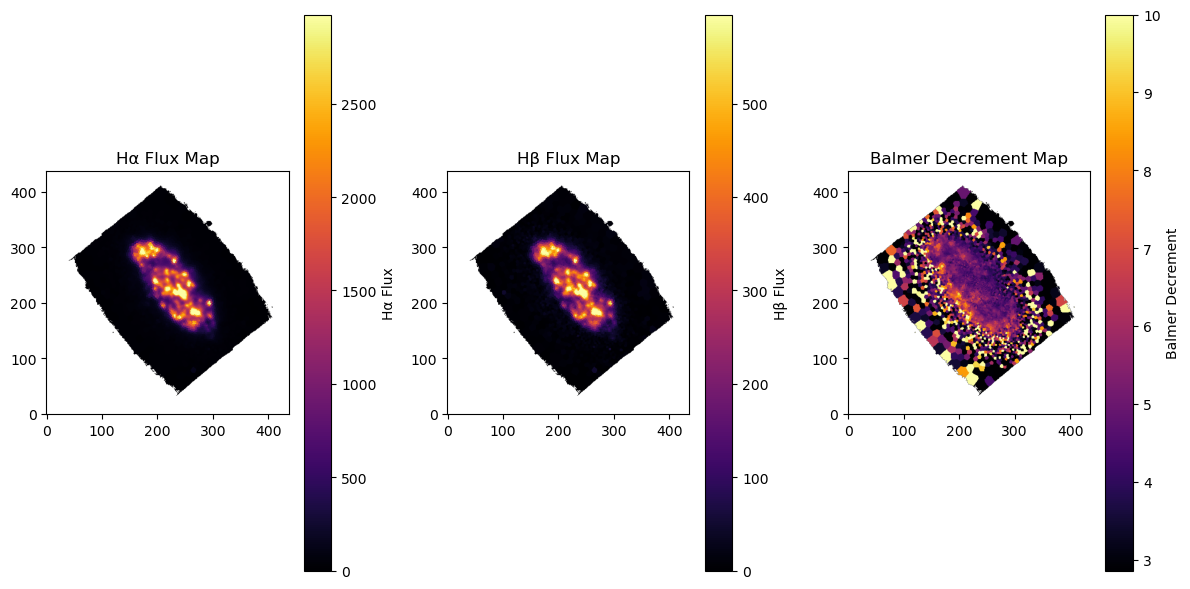

In [6]:
# Plot HA6562_FLUX and HB4861_FLUX and balmer decrement map
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(HA6562_FLUX, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX, 99.))
plt.colorbar(label='Hα Flux')
plt.title('Hα Flux Map')    
plt.subplot(1, 3, 2)
plt.imshow(HB4861_FLUX, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HB4861_FLUX, 99.))
plt.colorbar(label='Hβ Flux')
plt.title('Hβ Flux Map')
plt.subplot(1, 3, 3)
plt.imshow(BD, origin='lower', cmap='inferno', vmin=2.86, vmax=10)
plt.colorbar(label='Balmer Decrement')
plt.title('Balmer Decrement Map')
plt.tight_layout()
plt.show()

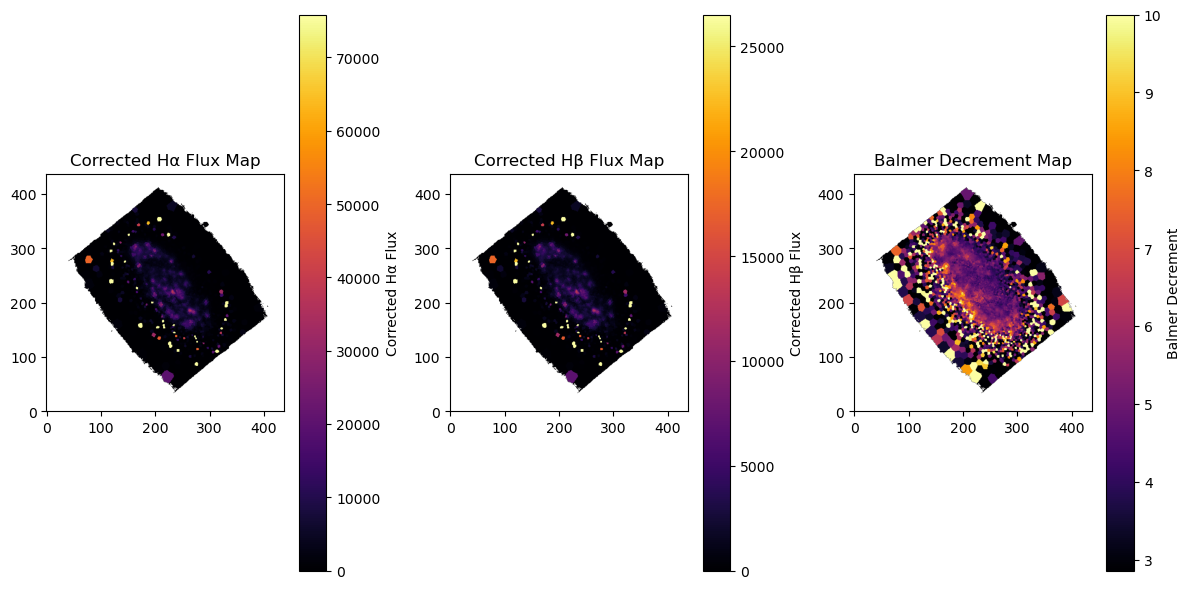

In [7]:
# Plot corrected HA6562_FLUX and HB4861_FLUX and balmer decrement map
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(HA6562_FLUX_corr, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX_corr, 99.))
plt.colorbar(label='Corrected Hα Flux')
plt.title('Corrected Hα Flux Map')
plt.subplot(1, 3, 2)
plt.imshow(HB4861_FLUX_corr, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HB4861_FLUX_corr, 99.))
plt.colorbar(label='Corrected Hβ Flux')
plt.title('Corrected Hβ Flux Map')
plt.subplot(1, 3, 3)
plt.imshow(BD, origin='lower', cmap='inferno', vmin=2.86, vmax=10)
plt.colorbar(label='Balmer Decrement')
plt.title('Balmer Decrement Map')
plt.tight_layout()
plt.show()

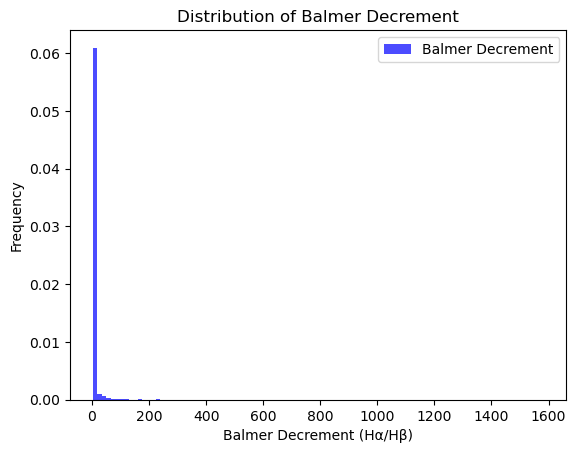

In [8]:
plt.hist(BD[np.isfinite(BD)], bins=100, color='blue', alpha=0.7, label='Balmer Decrement', density=True)
plt.xlabel('Balmer Decrement (Hα/Hβ)')
plt.ylabel('Frequency')
plt.title('Distribution of Balmer Decrement')
plt.legend()
plt.show()  

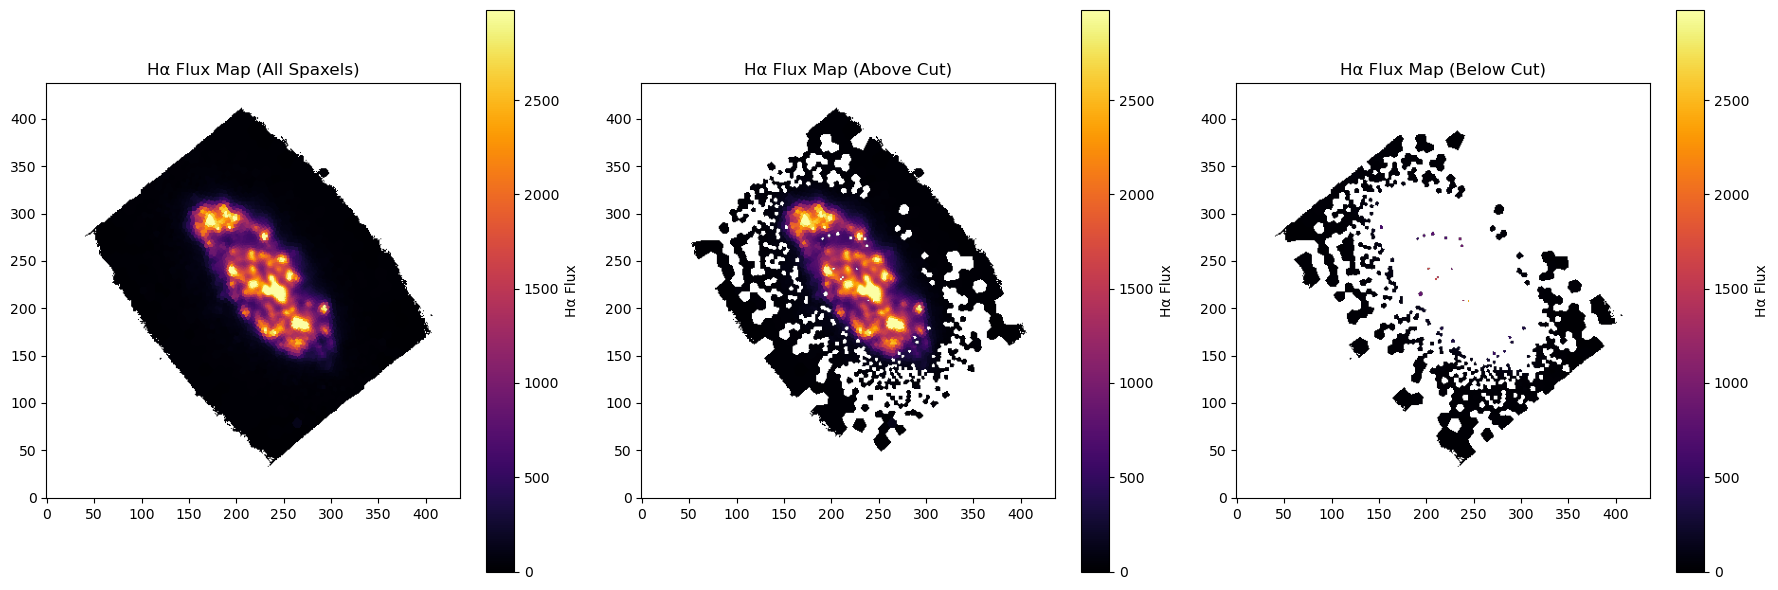

In [9]:
# plot Halpha flux for all spaxels, spaxels above the cut and spaxels below the cut
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(HA6562_FLUX, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX, 99.))
plt.colorbar(label='Hα Flux')
plt.title('Hα Flux Map (All Spaxels)')
plt.subplot(1, 3, 2)
plt.imshow(np.where(mask_BPT, HA6562_FLUX, np.nan), origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX, 99.))
plt.colorbar(label='Hα Flux')
plt.title('Hα Flux Map (Above Cut)')
plt.subplot(1, 3, 3)
plt.imshow(np.where(~mask_BPT, HA6562_FLUX, np.nan), origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX, 99.))
plt.colorbar(label='Hα Flux')
plt.title('Hα Flux Map (Below Cut)')
plt.tight_layout()
plt.show()

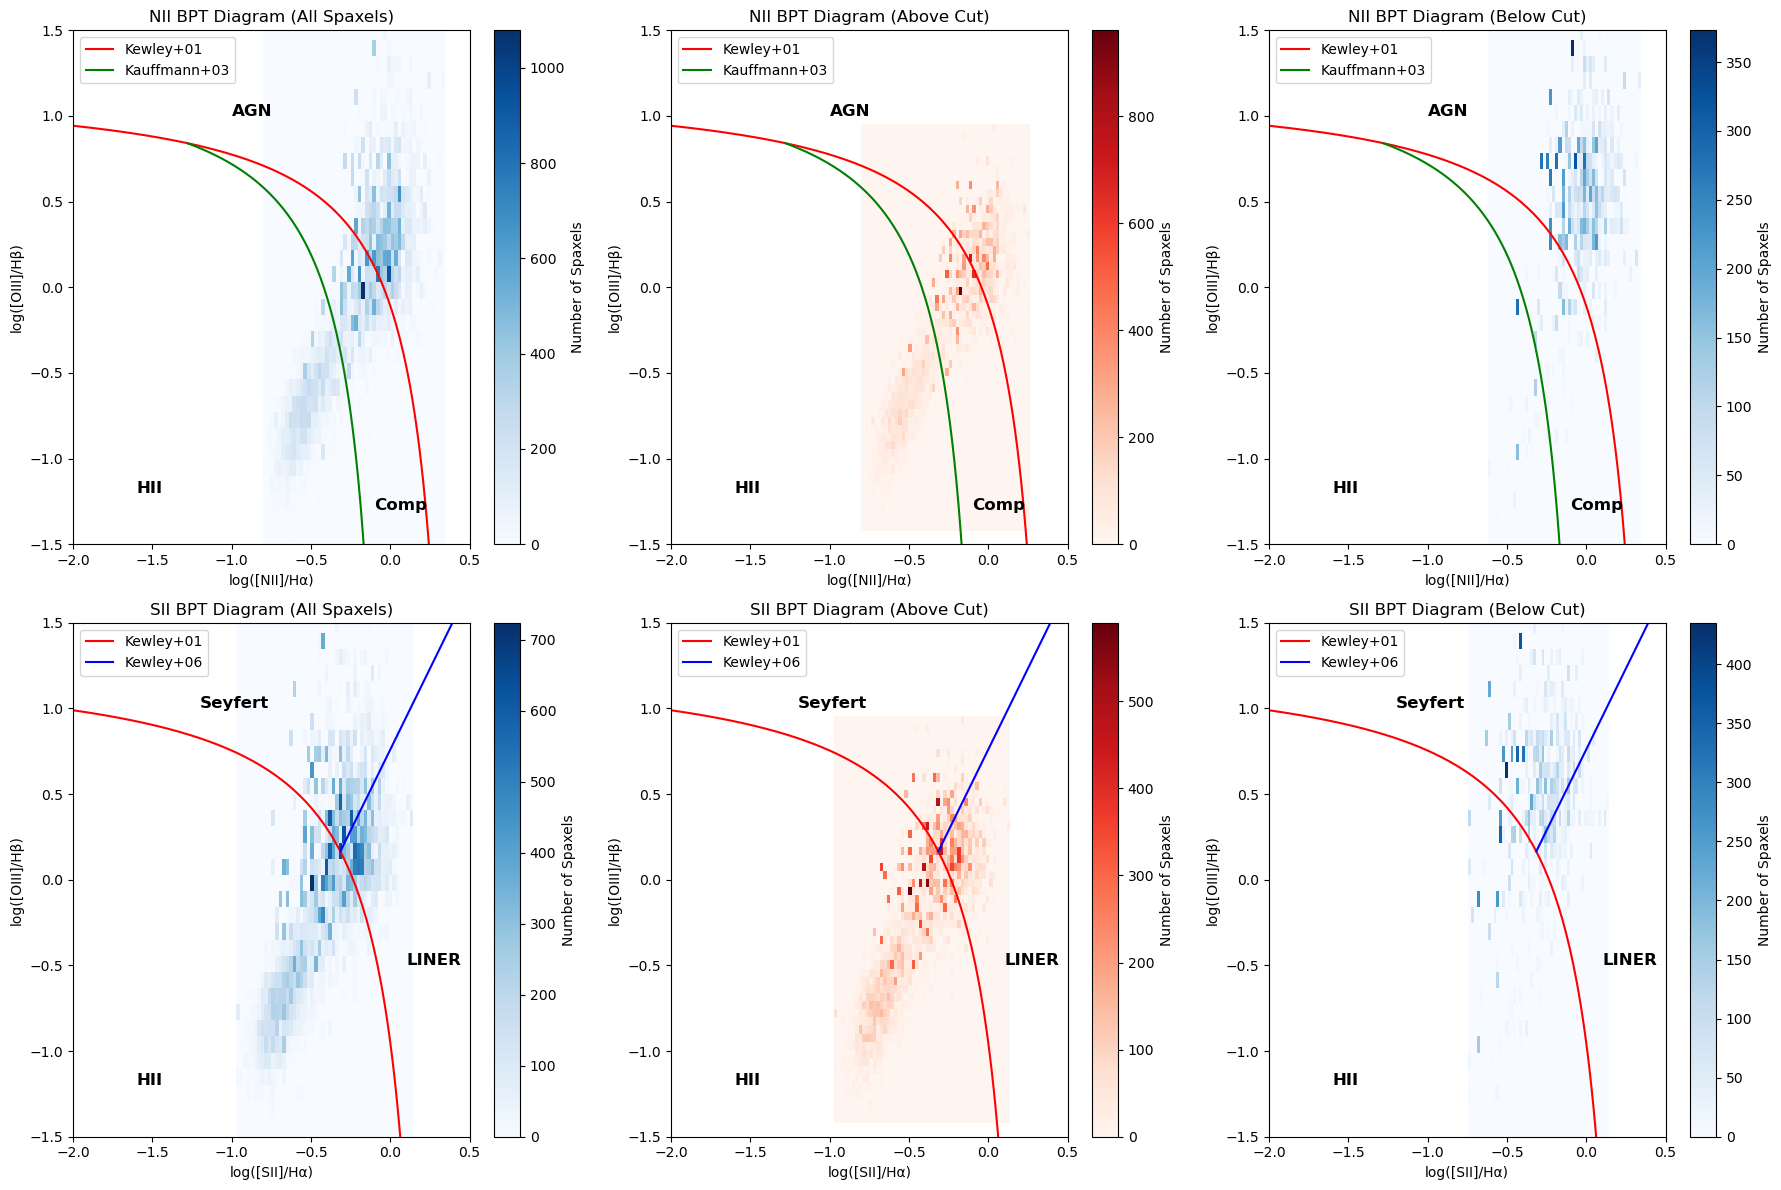

In [10]:
# Plot both NII and SII BPT diagrams for all spaxels, spaxels above the cut and spaxels below the cut
plt.figure(figsize=(18, 12))

# Create x arrays for the theoretical lines
x_kewley_N2 = np.linspace(-2.0, 0.3, 200)
x_kauff_N2 = np.linspace((286-np.sqrt(2871561))/1100, 0.0, 200)
x_kewley_S2 = np.linspace(-2.0, 0.3, 200)
x_kewley06_S2 = np.linspace((159-np.sqrt(105081))/525, 0.5, 200)

# NII BPT diagrams
plt.subplot(2, 3, 1)
plt.hist2d(logN2[np.isfinite(logN2) & np.isfinite(logO3)], 
           logO3[np.isfinite(logN2) & np.isfinite(logO3)], 
           bins=50, cmap='Blues')
plt.colorbar(label='Number of Spaxels')
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (All Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')

plt.subplot(2, 3, 2)
valid_above = mask_BPT & np.isfinite(logN2) & np.isfinite(logO3)
plt.hist2d(logN2[valid_above], logO3[valid_above], bins=50, cmap='Reds')
plt.colorbar(label='Number of Spaxels')
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (Above Cut)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')

plt.subplot(2, 3, 3)
valid_below = ~mask_BPT & np.isfinite(logN2) & np.isfinite(logO3)
plt.hist2d(logN2[valid_below], logO3[valid_below], bins=50, cmap='Blues')
plt.colorbar(label='Number of Spaxels')
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (Below Cut)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')

# SII BPT diagrams
plt.subplot(2, 3, 4)
plt.hist2d(logS2[np.isfinite(logS2) & np.isfinite(logO3)], 
           logO3[np.isfinite(logS2) & np.isfinite(logO3)], 
           bins=50, cmap='Blues')
plt.colorbar(label='Number of Spaxels')
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (All Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')

plt.subplot(2, 3, 5)
valid_above_S2 = mask_BPT & np.isfinite(logS2) & np.isfinite(logO3)
plt.hist2d(logS2[valid_above_S2], logO3[valid_above_S2], bins=50, cmap='Reds')
plt.colorbar(label='Number of Spaxels')
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (Above Cut)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')

plt.subplot(2, 3, 6)
valid_below_S2 = ~mask_BPT & np.isfinite(logS2) & np.isfinite(logO3)
plt.hist2d(logS2[valid_below_S2], logO3[valid_below_S2], bins=50, cmap='Blues')
plt.colorbar(label='Number of Spaxels')
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (Below Cut)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

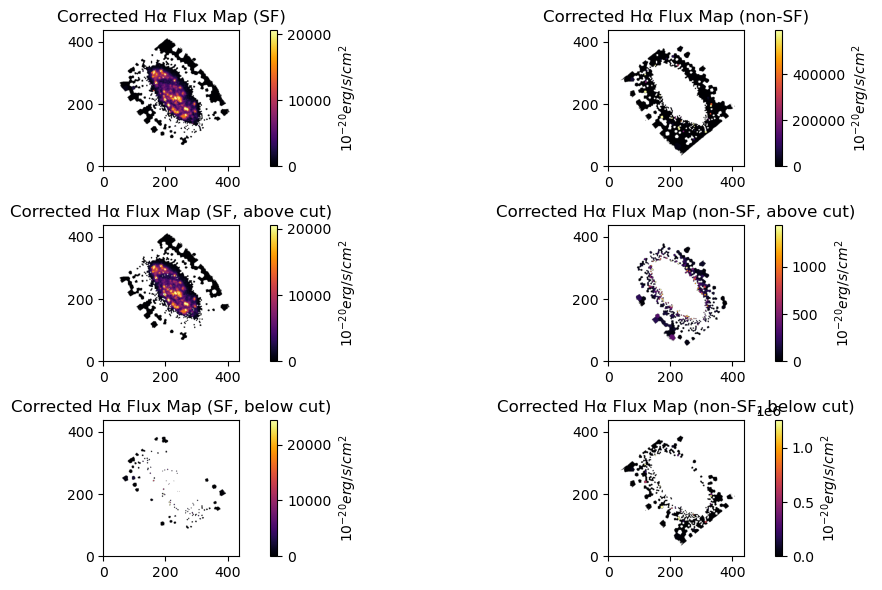

In [11]:
# Apply the (SF and non-SF masks, under the 'both' condition) and (above and below cut masks) to the corrected HA6562_FLUX
HA6562_FLUX_corr_SF = np.where(SF_mask, HA6562_FLUX_corr, np.nan)
HA6562_FLUX_corr_non_SF = np.where(non_SF_mask, HA6562_FLUX_corr, np.nan)
HA6562_FLUX_corr_SF_above = np.where(SF_mask & mask_BPT, HA6562_FLUX_corr, np.nan)
HA6562_FLUX_corr_non_SF_above = np.where(non_SF_mask & mask_BPT, HA6562_FLUX_corr, np.nan)
HA6562_FLUX_corr_SF_below = np.where(SF_mask & ~mask_BPT, HA6562_FLUX_corr, np.nan)
HA6562_FLUX_corr_non_SF_below = np.where(non_SF_mask & ~mask_BPT, HA6562_FLUX_corr, np.nan)

# plot HA6562_FLUX_corr_SF, HA6562_FLUX_corr_non_SF, 
# HA6562_FLUX_corr_SF_above, HA6562_FLUX_corr_non_SF_above, 
# HA6562_FLUX_corr_SF_below, HA6562_FLUX_corr_non_SF_below
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
plt.imshow(HA6562_FLUX_corr_SF, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX_corr_SF, 99.))
plt.colorbar(label='$10^{-20} erg/s/cm^2$')
plt.title('Corrected Hα Flux Map (SF)')
plt.subplot(3, 2, 2)
plt.imshow(HA6562_FLUX_corr_non_SF, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX_corr_non_SF, 99.))
plt.colorbar(label='$10^{-20} erg/s/cm^2$')
plt.title('Corrected Hα Flux Map (non-SF)')
plt.subplot(3, 2, 3)
plt.imshow(HA6562_FLUX_corr_SF_above, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX_corr_SF_above, 99.))
plt.colorbar(label='$10^{-20} erg/s/cm^2$')
plt.title('Corrected Hα Flux Map (SF, above cut)')
plt.subplot(3, 2, 4)
plt.imshow(HA6562_FLUX_corr_non_SF_above, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX_corr_non_SF_above, 99.))
plt.colorbar(label='$10^{-20} erg/s/cm^2$')
plt.title('Corrected Hα Flux Map (non-SF, above cut)')
plt.subplot(3, 2, 5)
plt.imshow(HA6562_FLUX_corr_SF_below, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX_corr_SF_below, 99.))
plt.colorbar(label='$10^{-20} erg/s/cm^2$')
plt.title('Corrected Hα Flux Map (SF, below cut)')
plt.subplot(3, 2, 6)
plt.imshow(HA6562_FLUX_corr_non_SF_below, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX_corr_non_SF_below, 99.))
plt.colorbar(label='$10^{-20} erg/s/cm^2$')
plt.title('Corrected Hα Flux Map (non-SF, below cut)')
plt.tight_layout()
plt.show()

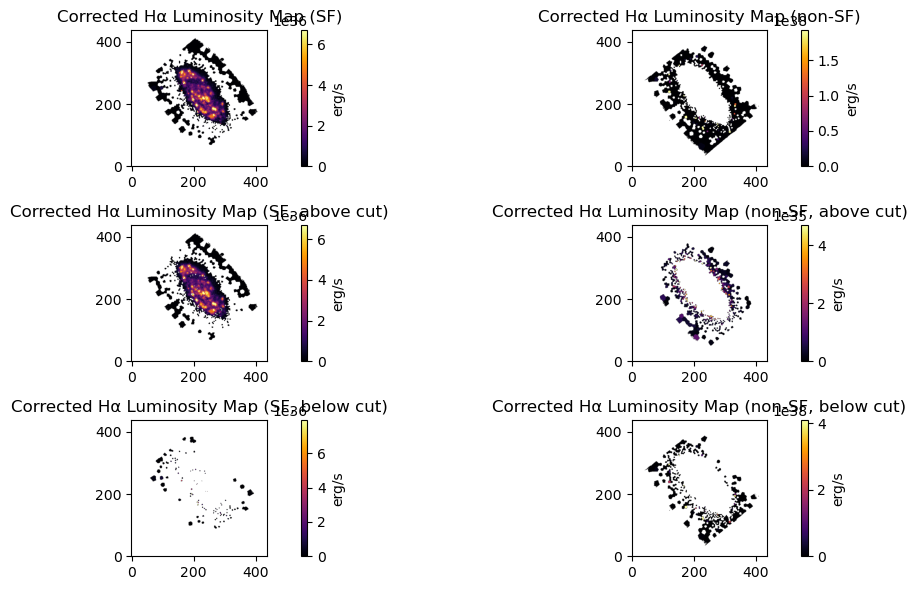

In [12]:
# Apply the (SF and non-SF masks, under the 'both' condition) and (above and below cut masks) to the corrected HA6562_LUM
HA6562_LUM_SF = np.where(SF_mask, HA6562_LUM, np.nan)
HA6562_LUM_non_SF = np.where(non_SF_mask, HA6562_LUM, np.nan)
HA6562_LUM_SF_above = np.where(SF_mask & mask_BPT, HA6562_LUM, np.nan)
HA6562_LUM_non_SF_above = np.where(non_SF_mask & mask_BPT, HA6562_LUM, np.nan)
HA6562_LUM_SF_below = np.where(SF_mask & ~mask_BPT, HA6562_LUM, np.nan)
HA6562_LUM_non_SF_below = np.where(non_SF_mask & ~mask_BPT, HA6562_LUM, np.nan)

# plot HA6562_LUM_SF, HA6562_LUM_non_SF, 
# HA6562_LUM_SF_above, HA6562_LUM_non_SF_above, 
# HA6562_LUM_SF_below, HA6562_LUM_non_SF_below
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
plt.imshow(HA6562_LUM_SF, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_LUM_SF, 99.))
plt.colorbar(label='erg/s')
plt.title('Corrected Hα Luminosity Map (SF)')
plt.subplot(3, 2, 2)
plt.imshow(HA6562_LUM_non_SF, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_LUM_non_SF, 99.))
plt.colorbar(label='erg/s')
plt.title('Corrected Hα Luminosity Map (non-SF)')
plt.subplot(3, 2, 3)
plt.imshow(HA6562_LUM_SF_above, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_LUM_SF_above, 99.))
plt.colorbar(label='erg/s')
plt.title('Corrected Hα Luminosity Map (SF, above cut)')
plt.subplot(3, 2, 4)
plt.imshow(HA6562_LUM_non_SF_above, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_LUM_non_SF_above, 99.))
plt.colorbar(label='erg/s')
plt.title('Corrected Hα Luminosity Map (non-SF, above cut)')
plt.subplot(3, 2, 5)
plt.imshow(HA6562_LUM_SF_below, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_LUM_SF_below, 99.))
plt.colorbar(label='erg/s')
plt.title('Corrected Hα Luminosity Map (SF, below cut)')
plt.subplot(3, 2, 6)
plt.imshow(HA6562_LUM_non_SF_below, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_LUM_non_SF_below, 99.))
plt.colorbar(label='erg/s')
plt.title('Corrected Hα Luminosity Map (non-SF, below cut)')
plt.tight_layout()
plt.show()

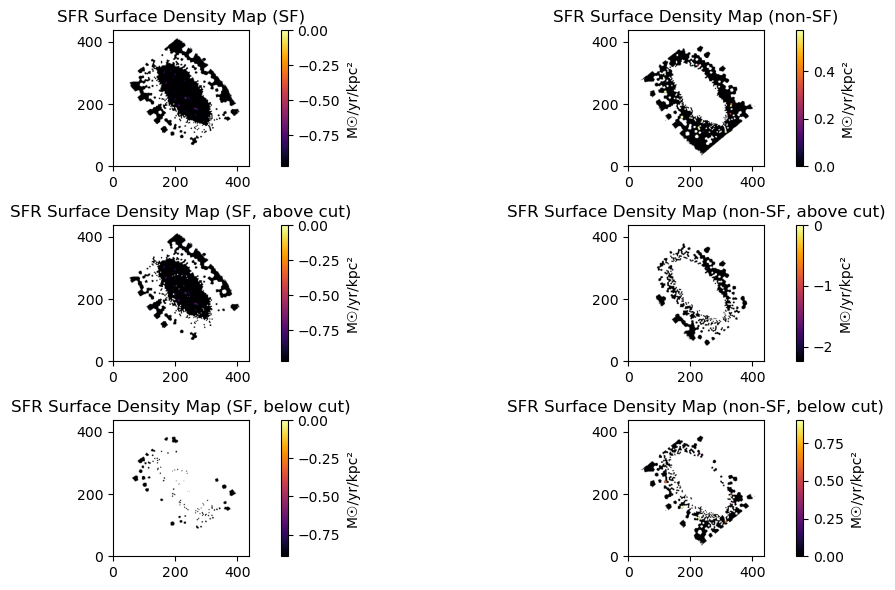

In [13]:
# Apply the (SF and non-SF masks, under the 'both' condition) and (above and below cut masks) to the LOG SFR surface density map
LOG_SFR_surface_density_map_SF = np.where(SF_mask, LOG_SFR_surface_density_map, np.nan)
LOG_SFR_surface_density_map_non_SF = np.where(non_SF_mask, LOG_SFR_surface_density_map, np.nan)
LOG_SFR_surface_density_map_SF_above = np.where(SF_mask & mask_BPT, LOG_SFR_surface_density_map, np.nan)
LOG_SFR_surface_density_map_non_SF_above = np.where(non_SF_mask & mask_BPT, LOG_SFR_surface_density_map, np.nan)
LOG_SFR_surface_density_map_SF_below = np.where(SF_mask & ~mask_BPT, LOG_SFR_surface_density_map, np.nan)
LOG_SFR_surface_density_map_non_SF_below = np.where(non_SF_mask & ~mask_BPT, LOG_SFR_surface_density_map, np.nan)

# plot LOG_SFR_surface_density_map_SF, LOG_SFR_surface_density_map_non_SF,
# LOG_SFR_surface_density_map_SF_above, LOG_SFR_surface_density_map_non_SF_above,
# LOG_SFR_surface_density_map_SF_below, LOG_SFR_surface_density_map_non_SF_below
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
plt.imshow(LOG_SFR_surface_density_map_SF, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(LOG_SFR_surface_density_map_SF, 99.))
plt.colorbar(label='M☉/yr/kpc²')
plt.title('SFR Surface Density Map (SF)')
plt.subplot(3, 2, 2)
plt.imshow(LOG_SFR_surface_density_map_non_SF, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(LOG_SFR_surface_density_map_non_SF, 99.))
plt.colorbar(label='M☉/yr/kpc²')
plt.title('SFR Surface Density Map (non-SF)')
plt.subplot(3, 2, 3)
plt.imshow(LOG_SFR_surface_density_map_SF_above, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(LOG_SFR_surface_density_map_SF_above, 99.))
plt.colorbar(label='M☉/yr/kpc²')
plt.title('SFR Surface Density Map (SF, above cut)')
plt.subplot(3, 2, 4)
plt.imshow(LOG_SFR_surface_density_map_non_SF_above, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(LOG_SFR_surface_density_map_non_SF_above, 99.))
plt.colorbar(label='M☉/yr/kpc²')
plt.title('SFR Surface Density Map (non-SF, above cut)')
plt.subplot(3, 2, 5)
plt.imshow(LOG_SFR_surface_density_map_SF_below, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(LOG_SFR_surface_density_map_SF_below, 99.))
plt.colorbar(label='M☉/yr/kpc²')
plt.title('SFR Surface Density Map (SF, below cut)')
plt.subplot(3, 2, 6)
plt.imshow(LOG_SFR_surface_density_map_non_SF_below, origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(LOG_SFR_surface_density_map_non_SF_below, 99.))
plt.colorbar(label='M☉/yr/kpc²')
plt.title('SFR Surface Density Map (non-SF, below cut)')
plt.tight_layout()
plt.show()

In [14]:
binning_path = Path('IC3392_SPATIAL_BINNING_maps_extended.fits')
print(f"Loading kinematic map from {binning_path}")
with fits.open(binning_path) as hdul:
    kin_info = hdul.info()
    
    # Read data from all extensions except PRIMARY
    extension_names = [hdul[i].name for i in range(1, len(hdul))]
    print(f"Available extensions: {extension_names}")
    
    # Read each extension's data before closing the file
    for ext_name in extension_names:
        if ext_name and ext_name != "PRIMARY":
            globals()[ext_name] = hdul[ext_name].data
            if kin_path.exists():
                globals()[ext_name] = np.where(non_FOREGROUND_STAR, globals()[ext_name], np.nan)
            else:
                pass
            print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")

print("All data loaded successfully!")

Loading kinematic map from IC3392_SPATIAL_BINNING_maps_extended.fits
Filename: IC3392_SPATIAL_BINNING_maps_extended.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BINID         1 ImageHDU        26   (437, 438)   float64   
  2  FLUX          1 ImageHDU        26   (437, 438)   float64   
  3  SNR           1 ImageHDU        26   (437, 438)   float64   
  4  SNRBIN        1 ImageHDU        26   (437, 438)   float64   
  5  XBIN          1 ImageHDU        26   (437, 438)   float64   
  6  YBIN          1 ImageHDU        26   (437, 438)   float64   
  7  FLUX_R_corr    1 ImageHDU        27   (437, 438)   float64   
  8  ML_R          1 ImageHDU        27   (437, 438)   float64   
  9  LOGMSTAR      1 ImageHDU        27   (437, 438)   float64   
 10  LOGMASS_SURFACE_DENSITY    1 ImageHDU        27   (437, 438)   float64   
 11  MAGNITUDE_R    1 ImageHDU        27   (437, 438)   float64   
 12  MAGNITUDE_R_UNCORREC

Available extensions: ['BINID', 'FLUX', 'SNR', 'SNRBIN', 'XBIN', 'YBIN', 'FLUX_R_corr', 'ML_R', 'LOGMSTAR', 'LOGMASS_SURFACE_DENSITY', 'MAGNITUDE_R', 'MAGNITUDE_R_UNCORRECTED']
Loaded BINID: shape (438, 437)
Loaded FLUX: shape (438, 437)
Loaded SNR: shape (438, 437)
Loaded SNRBIN: shape (438, 437)
Loaded XBIN: shape (438, 437)
Loaded YBIN: shape (438, 437)
Loaded FLUX_R_corr: shape (438, 437)
Loaded ML_R: shape (438, 437)
Loaded LOGMSTAR: shape (438, 437)
Loaded LOGMASS_SURFACE_DENSITY: shape (438, 437)
Loaded MAGNITUDE_R: shape (438, 437)
Loaded MAGNITUDE_R_UNCORRECTED: shape (438, 437)
All data loaded successfully!


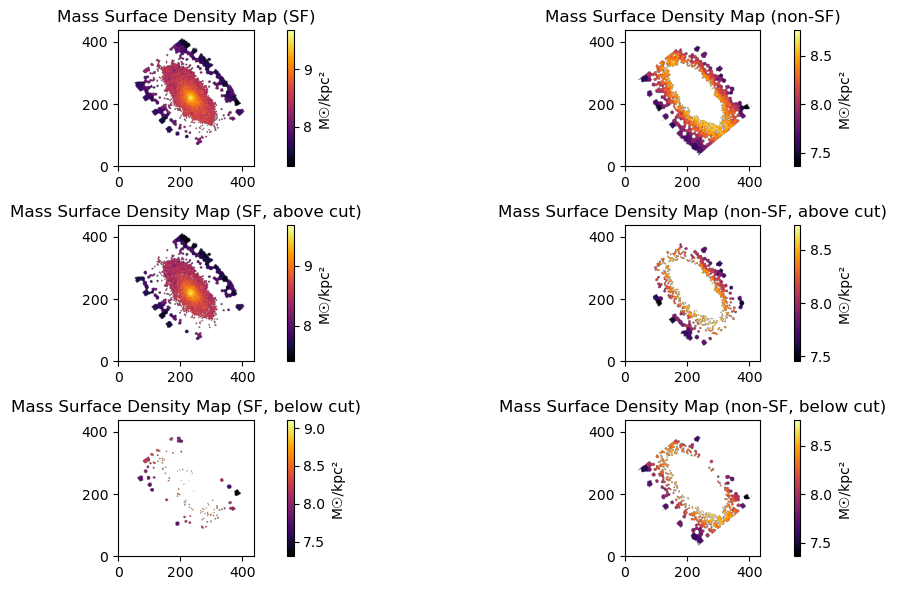

In [15]:
# Apply the (SF and non-SF masks, under the 'both' condition) and (above and below cut masks) to the LOGMASS_SURFACE_DENSITY
LOG_MASS_surface_density_map_SF = np.where(SF_mask, LOGMASS_SURFACE_DENSITY, np.nan)
LOG_MASS_surface_density_map_non_SF = np.where(non_SF_mask, LOGMASS_SURFACE_DENSITY, np.nan)
LOG_MASS_surface_density_map_SF_above = np.where(SF_mask & mask_BPT, LOGMASS_SURFACE_DENSITY, np.nan)
LOG_MASS_surface_density_map_non_SF_above = np.where(non_SF_mask & mask_BPT, LOGMASS_SURFACE_DENSITY, np.nan)
LOG_MASS_surface_density_map_SF_below = np.where(SF_mask & ~mask_BPT, LOGMASS_SURFACE_DENSITY, np.nan)
LOG_MASS_surface_density_map_non_SF_below = np.where(non_SF_mask & ~mask_BPT, LOGMASS_SURFACE_DENSITY, np.nan)

# plot LOG_MASS_surface_density_map_SF, LOG_MASS_surface_density_map_non_SF,
# LOG_MASS_surface_density_map_SF_above, LOG_MASS_surface_density_map_non_SF_above, 
# LOG_MASS_surface_density_map_SF_below, LOG_MASS_surface_density_map_non_SF_below
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
plt.imshow(LOG_MASS_surface_density_map_SF, origin='lower', cmap='inferno')
plt.colorbar(label='M☉/kpc²')
plt.title('Mass Surface Density Map (SF)')
plt.subplot(3, 2, 2)
plt.imshow(LOG_MASS_surface_density_map_non_SF, origin='lower', cmap='inferno')
plt.colorbar(label='M☉/kpc²')
plt.title('Mass Surface Density Map (non-SF)')
plt.subplot(3, 2, 3)
plt.imshow(LOG_MASS_surface_density_map_SF_above, origin='lower', cmap='inferno')
plt.colorbar(label='M☉/kpc²')
plt.title('Mass Surface Density Map (SF, above cut)')
plt.subplot(3, 2, 4)
plt.imshow(LOG_MASS_surface_density_map_non_SF_above, origin='lower', cmap='inferno')
plt.colorbar(label='M☉/kpc²')
plt.title('Mass Surface Density Map (non-SF, above cut)')
plt.subplot(3, 2, 5)
plt.imshow(LOG_MASS_surface_density_map_SF_below, origin='lower', cmap='inferno')
plt.colorbar(label='M☉/kpc²')
plt.title('Mass Surface Density Map (SF, below cut)')
plt.subplot(3, 2, 6)
plt.imshow(LOG_MASS_surface_density_map_non_SF_below, origin='lower', cmap='inferno')
plt.colorbar(label='M☉/kpc²')
plt.title('Mass Surface Density Map (non-SF, below cut)')
plt.tight_layout()
plt.show()

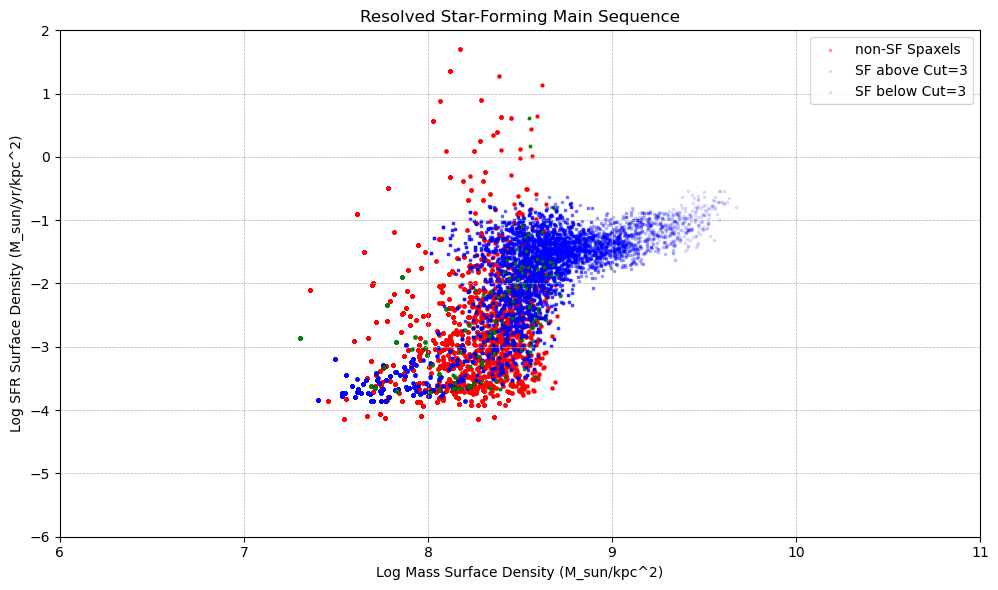

In [16]:
# Plot the resolved SFMS plot
plt.figure(figsize=(10, 6))
plt.scatter(LOG_MASS_surface_density_map_non_SF,
            LOG_SFR_surface_density_map_non_SF, s=1, marker=',', alpha=0.3, color='red', label='non-SF Spaxels')
plt.scatter(LOG_MASS_surface_density_map_SF_above,
            LOG_SFR_surface_density_map_SF_above, s=1, marker=',', alpha=0.1, color='blue', label=f'SF above Cut={cut}')
plt.scatter(LOG_MASS_surface_density_map_SF_below,
            LOG_SFR_surface_density_map_SF_below, s=1, marker=',', alpha=0.1, color='green', label=f'SF below Cut={cut}')
plt.legend()
plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('Log SFR Surface Density (M_sun/yr/kpc^2)')    
plt.title('Resolved Star-Forming Main Sequence')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.show()

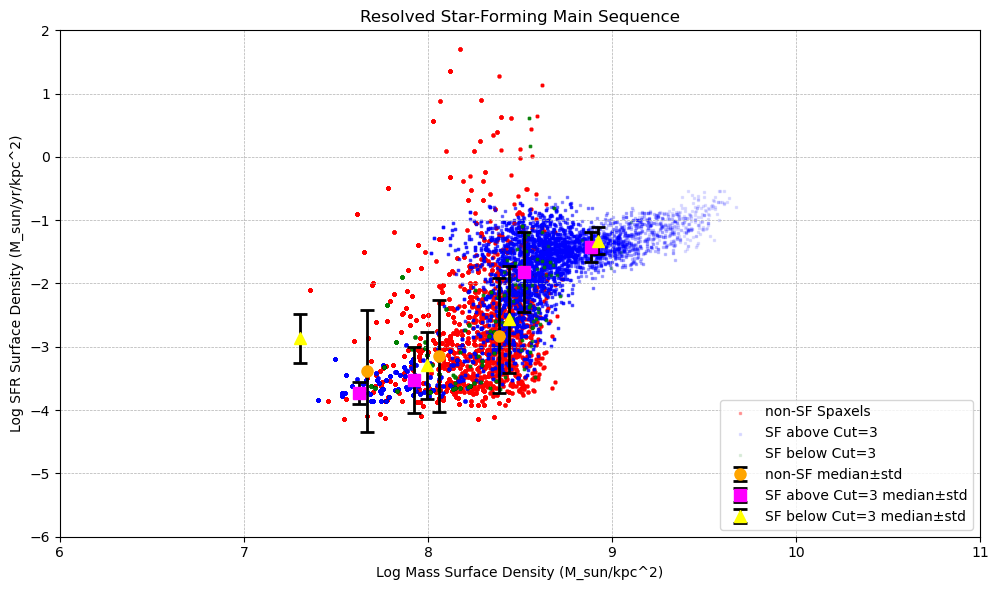

In [17]:
# Plot the resolved SFMS plot with median and error bars
plt.figure(figsize=(10, 6))

# Define x-axis bins
x_bins = [7.25, 7.75, 8.25, 8.75, 9.25]

# Function to calculate median and std for each bin
def calculate_bin_stats(x_data, y_data, bins):
    medians = []
    stds = []
    x_medians = []
    for i in range(len(bins)-1):
        mask = (x_data > bins[i]) & (x_data <= bins[i+1])
        if np.sum(mask) > 0:
            x_bin = x_data[mask]
            y_bin = y_data[mask]
            
            # Remove non-finite values
            finite_mask = np.isfinite(x_bin) & np.isfinite(y_bin)
            x_bin = x_bin[finite_mask]
            y_bin = y_bin[finite_mask]
            
            if len(y_bin) > 0:
                x_medians.append(np.median(x_bin))
                medians.append(np.median(y_bin))
                stds.append(np.std(y_bin))
            else:
                x_medians.append(np.nan)
                medians.append(np.nan)
                stds.append(np.nan)
        else:
            x_medians.append(np.nan)
            medians.append(np.nan)
            stds.append(np.nan)
    return np.array(x_medians), np.array(medians), np.array(stds)

# Calculate statistics for each dataset
red_x_med, red_med, red_std = calculate_bin_stats(LOG_MASS_surface_density_map_non_SF.flatten(), 
                                                  LOG_SFR_surface_density_map_non_SF.flatten(), x_bins)
blue_x_med, blue_med, blue_std = calculate_bin_stats(LOG_MASS_surface_density_map_SF_above.flatten(), 
                                                     LOG_SFR_surface_density_map_SF_above.flatten(), x_bins)
green_x_med, green_med, green_std = calculate_bin_stats(LOG_MASS_surface_density_map_SF_below.flatten(), 
                                                        LOG_SFR_surface_density_map_SF_below.flatten(), x_bins)

# Plot scatter points
plt.scatter(LOG_MASS_surface_density_map_non_SF,
            LOG_SFR_surface_density_map_non_SF, s=1, marker=',', alpha=0.3, color='red', label='non-SF Spaxels')
plt.scatter(LOG_MASS_surface_density_map_SF_above,
            LOG_SFR_surface_density_map_SF_above, s=1, marker=',', alpha=0.1, color='blue', label=f'SF above Cut={cut}')
plt.scatter(LOG_MASS_surface_density_map_SF_below,
            LOG_SFR_surface_density_map_SF_below, s=1, marker=',', alpha=0.1, color='green', label=f'SF below Cut={cut}')

# Plot median with error bars
plt.errorbar(red_x_med, red_med, yerr=red_std, fmt='o', color='orange', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label='non-SF median±std')
plt.errorbar(blue_x_med, blue_med, yerr=blue_std, fmt='s', color='magenta', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'SF above Cut={cut} median±std')
plt.errorbar(green_x_med, green_med, yerr=green_std, fmt='^', color='yellow', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'SF below Cut={cut} median±std')

plt.legend(loc='lower right')
plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('Log SFR Surface Density (M_sun/yr/kpc^2)')    
plt.title('Resolved Star-Forming Main Sequence')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.show()

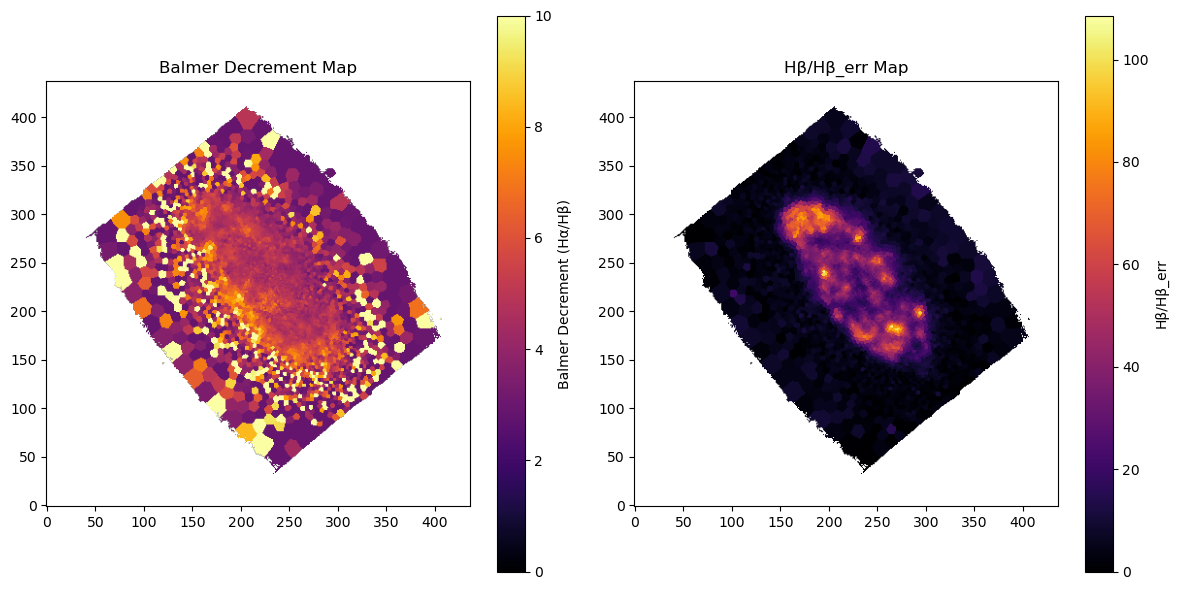

In [18]:
# Plot the Balmer Decrement map and HB4861_FLUX/HB4861_FLUX_ERR map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(BD, origin='lower', cmap='inferno', vmin=0, vmax=10)
plt.colorbar(label='Balmer Decrement (Hα/Hβ)')
plt.title('Balmer Decrement Map')
plt.subplot(1, 2, 2)
plt.imshow(HB4861_FLUX/HB4861_FLUX_ERR, origin='lower', cmap='inferno', )
plt.colorbar(label='Hβ/Hβ_err')
plt.title('Hβ/Hβ_err Map')
plt.tight_layout()
plt.show()  

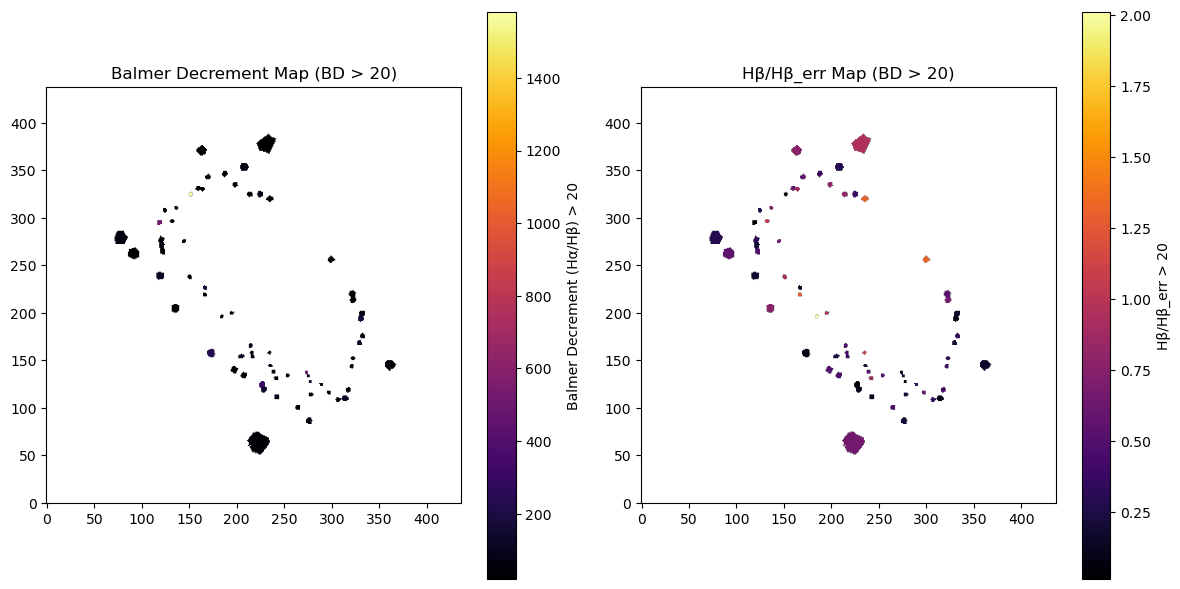

In [19]:
# Plot the Balmer Decrement map with BD>25 and HB4861_FLUX/HB4861_FLUX_ERR with BD>25 map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.where(BD > 20, BD, np.nan), origin='lower', cmap='inferno')
plt.colorbar(label='Balmer Decrement (Hα/Hβ) > 20')
plt.title('Balmer Decrement Map (BD > 20)')
plt.subplot(1, 2, 2)
plt.imshow(np.where(BD > 20, HB4861_FLUX/HB4861_FLUX_ERR, np.nan), origin='lower', cmap='inferno', )
plt.colorbar(label='Hβ/Hβ_err > 20')
plt.title('Hβ/Hβ_err Map (BD > 20)')
plt.tight_layout()
plt.show()

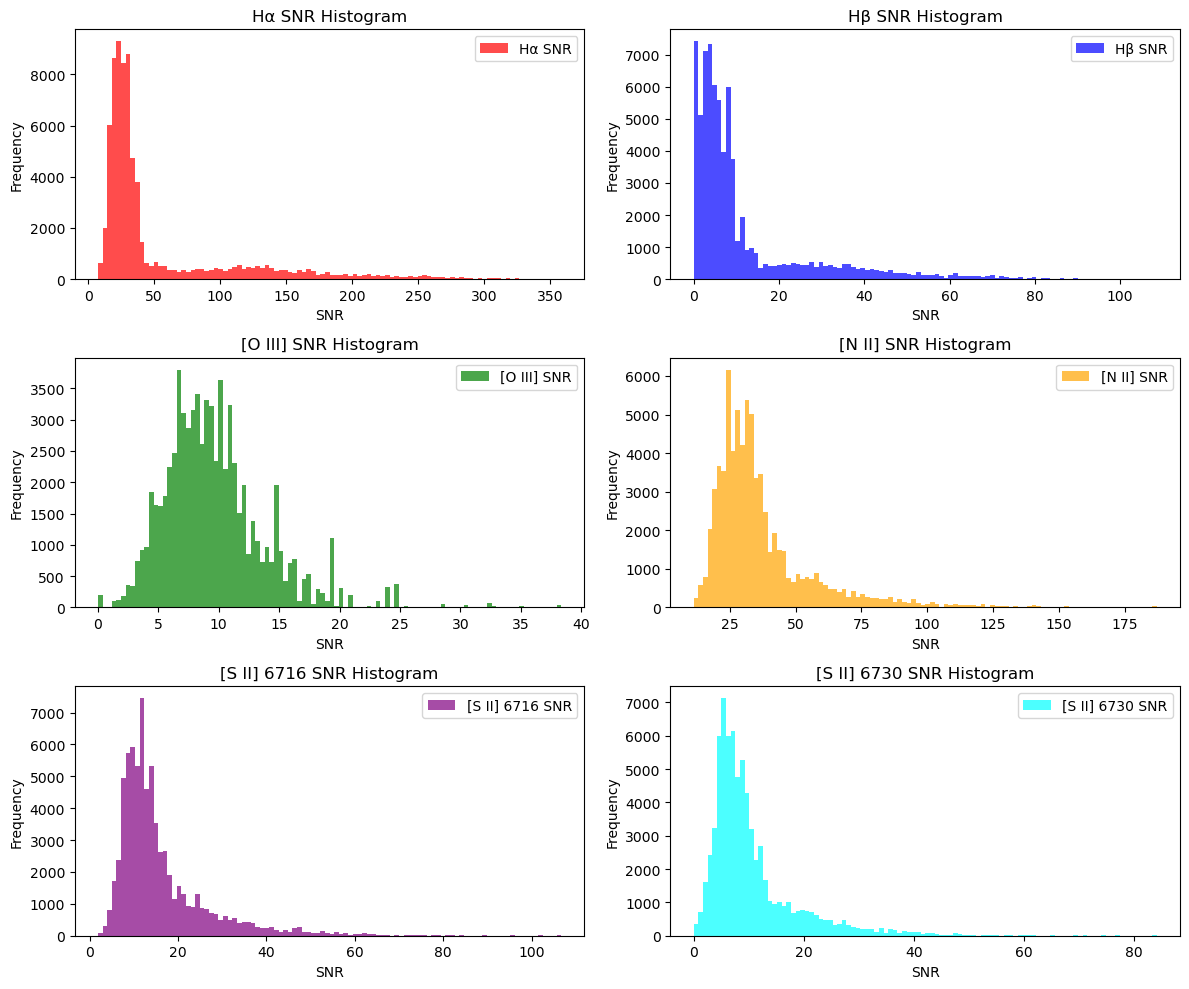

In [20]:
# Calculate SNR for each line
HA6562_FLUX_SNR = HA6562_FLUX / HA6562_FLUX_ERR
HB4861_FLUX_SNR = HB4861_FLUX / HB4861_FLUX_ERR
OIII5006_FLUX_SNR = OIII5006_FLUX / OIII5006_FLUX_ERR
NII6583_FLUX_SNR = NII6583_FLUX / NII6583_FLUX_ERR
SII6716_FLUX_SNR = SII6716_FLUX / SII6716_FLUX_ERR
SII6730_FLUX_SNR = SII6730_FLUX / SII6730_FLUX_ERR

# Plot SNR histograms for each line
plt.figure(figsize=(12, 10))
plt.subplot(3, 2, 1)
plt.hist(HA6562_FLUX_SNR[np.isfinite(HA6562_FLUX_SNR)], bins=100, color='red', alpha=0.7, label='Hα SNR')
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('Hα SNR Histogram')
plt.legend()

plt.subplot(3, 2, 2)
plt.hist(HB4861_FLUX_SNR[np.isfinite(HB4861_FLUX_SNR)], bins=100, color='blue', alpha=0.7, label='Hβ SNR')
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('Hβ SNR Histogram')
plt.legend()

plt.subplot(3, 2, 3)
plt.hist(OIII5006_FLUX_SNR[np.isfinite(OIII5006_FLUX_SNR)], bins=100, color='green', alpha=0.7, label='[O III] SNR')
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('[O III] SNR Histogram')
plt.legend()

plt.subplot(3, 2, 4)
plt.hist(NII6583_FLUX_SNR[np.isfinite(NII6583_FLUX_SNR)], bins=100, color='orange', alpha=0.7, label='[N II] SNR')
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('[N II] SNR Histogram')
plt.legend()

plt.subplot(3, 2, 5)
plt.hist(SII6716_FLUX_SNR[np.isfinite(SII6716_FLUX_SNR)], bins=100, color='purple', alpha=0.7, label='[S II] 6716 SNR')
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('[S II] 6716 SNR Histogram')
plt.legend()

plt.subplot(3, 2, 6)
plt.hist(SII6730_FLUX_SNR[np.isfinite(SII6730_FLUX_SNR)], bins=100, color='cyan', alpha=0.7, label='[S II] 6730 SNR')
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('[S II] 6730 SNR Histogram')
plt.legend()

plt.tight_layout()
plt.show()

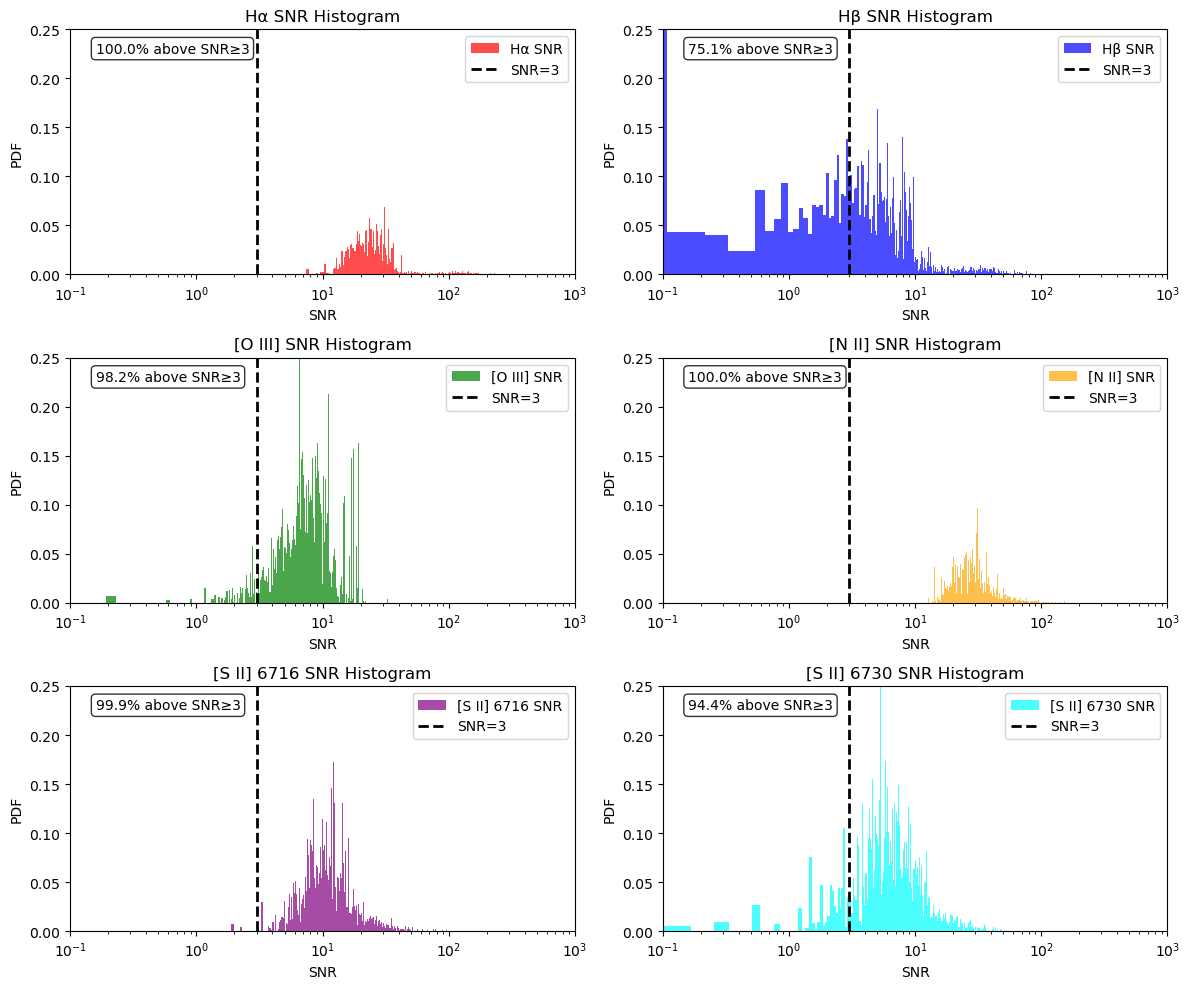

In [21]:
# Calculate percentage of spaxels above SNR cut for each line
def calc_percentage_above_cut(snr_data, cut_value):
    finite_mask = np.isfinite(snr_data)
    if np.sum(finite_mask) == 0:
        return 0.0
    above_cut = np.sum(snr_data[finite_mask] >= cut_value)
    return (above_cut / np.sum(finite_mask)) * 100

# Calculate percentages
ha_percent = calc_percentage_above_cut(HA6562_FLUX_SNR, cut)
hb_percent = calc_percentage_above_cut(HB4861_FLUX_SNR, cut)
oiii_percent = calc_percentage_above_cut(OIII5006_FLUX_SNR, cut)
nii_percent = calc_percentage_above_cut(NII6583_FLUX_SNR, cut)
sii6716_percent = calc_percentage_above_cut(SII6716_FLUX_SNR, cut)
sii6730_percent = calc_percentage_above_cut(SII6730_FLUX_SNR, cut)

# Plot SNR histograms for each line with percentage annotations
plt.figure(figsize=(12, 10))
plt.subplot(3, 2, 1)
plt.hist(HA6562_FLUX_SNR[np.isfinite(HA6562_FLUX_SNR)], 
         bins=1000, color='red', alpha=0.7, label='Hα SNR', density=True)
plt.axvline(x=cut, color='black', linestyle='--', linewidth=2, label=f'SNR={cut}')
plt.text(0.05, 0.95, f'{ha_percent:.1f}% above SNR≥{cut}', 
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.xlabel('SNR')
plt.ylabel('PDF')
plt.xscale('log')
plt.xlim(1e-1, 1e3)
plt.ylim(0, 0.25)
plt.title('Hα SNR Histogram')
plt.legend()

plt.subplot(3, 2, 2)
plt.hist(HB4861_FLUX_SNR[np.isfinite(HB4861_FLUX_SNR)], 
         bins=1000, color='blue', alpha=0.7, label='Hβ SNR', density=True)
plt.axvline(x=cut, color='black', linestyle='--', linewidth=2, label=f'SNR={cut}')
plt.text(0.05, 0.95, f'{hb_percent:.1f}% above SNR≥{cut}', 
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.xlabel('SNR')
plt.ylabel('PDF')
plt.xscale('log')
plt.xlim(1e-1, 1e3)
plt.ylim(0, 0.25)
plt.title('Hβ SNR Histogram')
plt.legend()

plt.subplot(3, 2, 3)
plt.hist(OIII5006_FLUX_SNR[np.isfinite(OIII5006_FLUX_SNR)], 
         bins=1000, color='green', alpha=0.7, label='[O III] SNR', density=True)
plt.axvline(x=cut, color='black', linestyle='--', linewidth=2, label=f'SNR={cut}')
plt.text(0.05, 0.95, f'{oiii_percent:.1f}% above SNR≥{cut}', 
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.xlabel('SNR')
plt.ylabel('PDF')
plt.xscale('log')
plt.xlim(1e-1, 1e3)
plt.ylim(0, 0.25)
plt.title('[O III] SNR Histogram')
plt.legend()

plt.subplot(3, 2, 4)
plt.hist(NII6583_FLUX_SNR[np.isfinite(NII6583_FLUX_SNR)], 
         bins=1000, color='orange', alpha=0.7, label='[N II] SNR', density=True)
plt.axvline(x=cut, color='black', linestyle='--', linewidth=2, label=f'SNR={cut}')
plt.text(0.05, 0.95, f'{nii_percent:.1f}% above SNR≥{cut}', 
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.xlabel('SNR')
plt.ylabel('PDF')
plt.xscale('log')
plt.xlim(1e-1, 1e3)
plt.ylim(0, 0.25)
plt.title('[N II] SNR Histogram')
plt.legend()

plt.subplot(3, 2, 5)
plt.hist(SII6716_FLUX_SNR[np.isfinite(SII6716_FLUX_SNR)], 
         bins=1000, color='purple', alpha=0.7, label='[S II] 6716 SNR', density=True)
plt.axvline(x=cut, color='black', linestyle='--', linewidth=2, label=f'SNR={cut}')
plt.text(0.05, 0.95, f'{sii6716_percent:.1f}% above SNR≥{cut}', 
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.xlabel('SNR')
plt.ylabel('PDF')
plt.xscale('log')
plt.xlim(1e-1, 1e3)
plt.ylim(0, 0.25)
plt.title('[S II] 6716 SNR Histogram')
plt.legend()

plt.subplot(3, 2, 6)
plt.hist(SII6730_FLUX_SNR[np.isfinite(SII6730_FLUX_SNR)], 
         bins=1000, color='cyan', alpha=0.7, label='[S II] 6730 SNR', density=True)
plt.axvline(x=cut, color='black', linestyle='--', linewidth=2, label=f'SNR={cut}')
plt.text(0.05, 0.95, f'{sii6730_percent:.1f}% above SNR≥{cut}', 
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.xlabel('SNR')
plt.ylabel('PDF')
plt.xscale('log')
plt.xlim(1e-1, 1e3)
plt.ylim(0, 0.25)
plt.title('[S II] 6730 SNR Histogram')
plt.legend()

plt.tight_layout()
plt.show()

(array([4.78892950e-01, 4.36615485e-02, 4.02642522e-02, 2.42843771e-02,
        2.41585513e-02, 8.60648391e-02, 4.39132001e-02, 5.67474305e-02,
        9.33627348e-02, 4.30324195e-02, 4.63038900e-02, 6.73167967e-02,
        5.71249078e-02, 4.07675554e-02, 7.07140929e-02, 6.90783577e-02,
        7.10915703e-02, 6.05222041e-02, 1.03177146e-01, 5.78798626e-02,
        5.98930752e-02, 9.63825537e-02, 1.21421886e-01, 5.25951794e-02,
        8.22900655e-02, 8.00252013e-02, 1.38030890e-01, 9.34885606e-02,
        1.01038108e-01, 7.24756540e-02, 8.75747486e-02, 8.78264001e-02,
        1.10223390e-01, 6.10255073e-02, 1.15382248e-01, 1.12110777e-01,
        5.82573399e-02, 7.08399187e-02, 9.38660380e-02, 1.27084046e-01,
        5.66216047e-02, 4.20258132e-02, 5.96414236e-02, 8.15351107e-02,
        4.44165032e-02, 4.06417296e-02, 1.68480730e-01, 7.22240024e-02,
        1.14123990e-01, 8.39258007e-02, 7.52438213e-02, 7.57471245e-02,
        7.93960723e-02, 5.38534373e-02, 7.72570339e-02, 1.341302

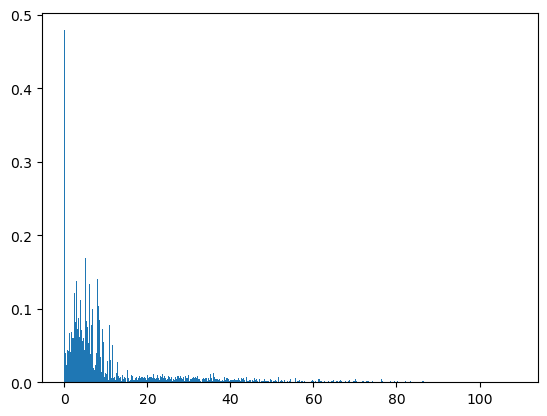

In [22]:
plt.hist(HB4861_FLUX_SNR[np.isfinite(HB4861_FLUX_SNR)], 
         bins=1000, density=True)

np.float64(1.0)

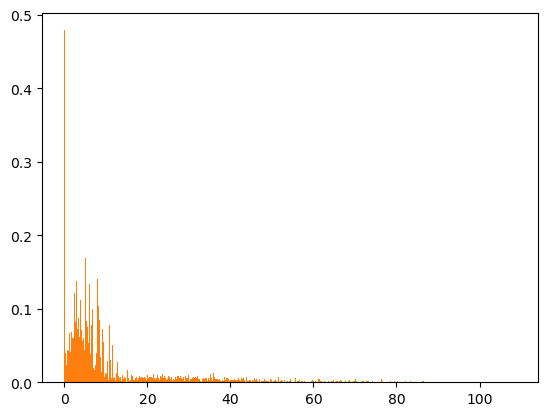

In [23]:
np.sum(plt.hist(HB4861_FLUX_SNR[np.isfinite(HB4861_FLUX_SNR)], 
         bins=1000, density=True)[0]*np.diff(plt.hist(HB4861_FLUX_SNR[np.isfinite(HB4861_FLUX_SNR)], 
         bins=1000, density=True)[1]))

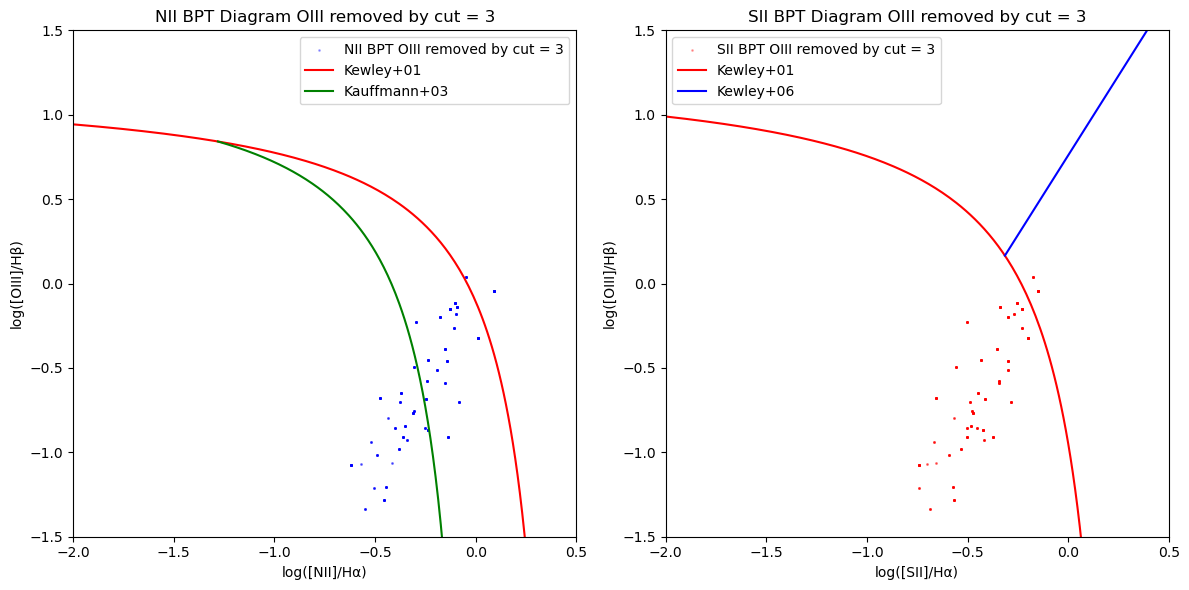

In [24]:
# Plot BPT diagrams for the spaxels in mask_BPT_no_OIII but not in mask_BPT
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_BPT_no_OIII & ~mask_BPT], logO3[mask_BPT_no_OIII & ~mask_BPT], 
            s=1, alpha=0.3, color='blue', label=f'NII BPT OIII removed by cut = {cut}')
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title(f'NII BPT Diagram OIII removed by cut = {cut}')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_BPT_no_OIII & ~mask_BPT], logO3[mask_BPT_no_OIII & ~mask_BPT], 
            s=1, alpha=0.3, color='red', label=f'SII BPT OIII removed by cut = {cut}')
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title(f'SII BPT Diagram OIII removed by cut = {cut}')
plt.legend()
plt.tight_layout()
plt.show()

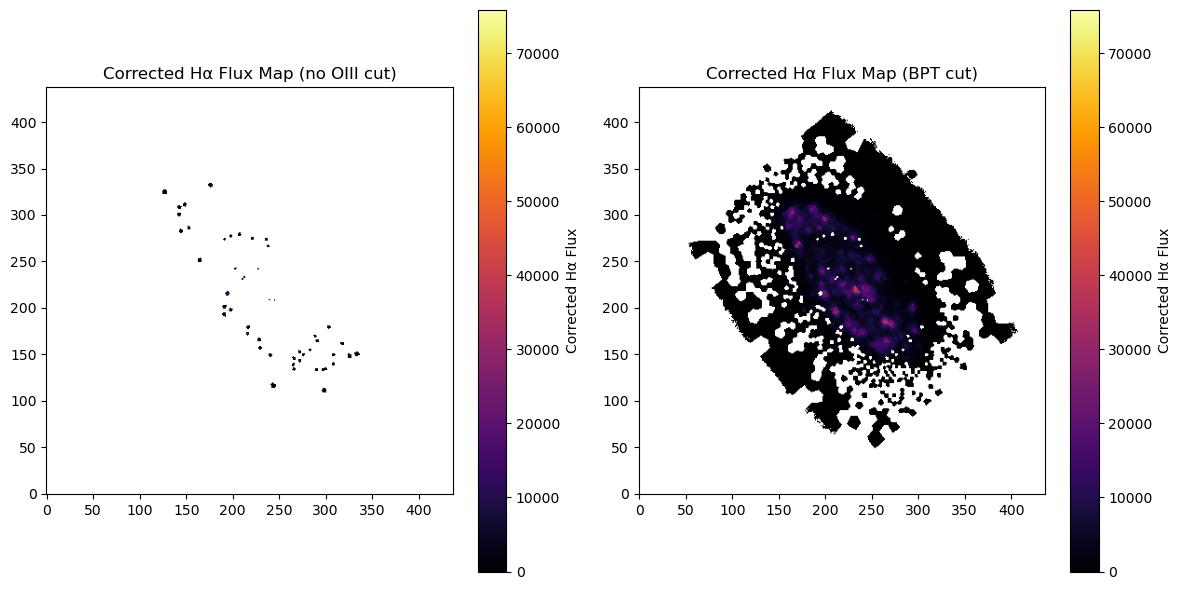

In [25]:
# Plot corrected halpha for the spaxels in mask_BPT_no_OIII but not in mask_BPT, and the spaxels in mask_BPT
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.where(mask_BPT_no_OIII & ~mask_BPT, HA6562_FLUX_corr, np.nan), 
           origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX_corr, 99.))
plt.colorbar(label='Corrected Hα Flux')
plt.title('Corrected Hα Flux Map (no OIII cut)')
plt.subplot(1, 2, 2)
plt.imshow(np.where(mask_BPT, HA6562_FLUX_corr, np.nan), 
           origin='lower', cmap='inferno', vmin=0, vmax=np.nanpercentile(HA6562_FLUX_corr, 99.))
plt.colorbar(label='Corrected Hα Flux')
plt.title('Corrected Hα Flux Map (BPT cut)')
plt.tight_layout()
plt.show()

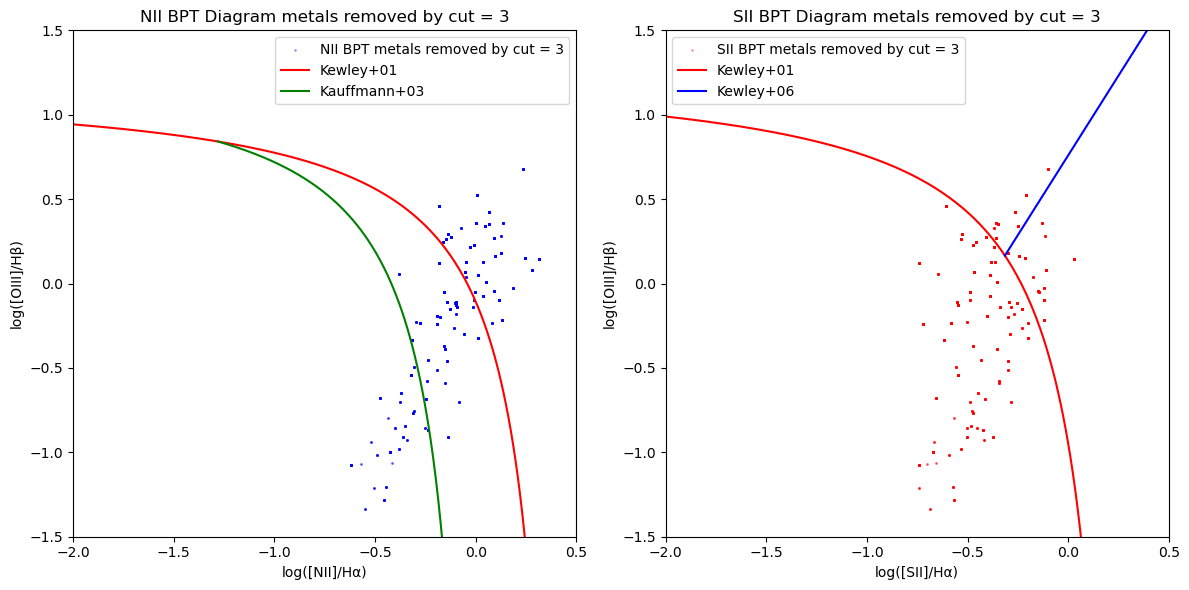

In [26]:
# Plot BPT diagrams for the spaxels in mask_BD but not in mask_BPT
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_BD & ~mask_BPT], logO3[mask_BD & ~mask_BPT], 
            s=1, alpha=0.3, color='blue', label=f'NII BPT metals removed by cut = {cut}')
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title(f'NII BPT Diagram metals removed by cut = {cut}')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_BD & ~mask_BPT], logO3[mask_BD & ~mask_BPT], 
            s=1, alpha=0.3, color='red', label=f'SII BPT metals removed by cut = {cut}')
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title(f'SII BPT Diagram metals removed by cut = {cut}')
plt.legend()
plt.tight_layout()
plt.show()

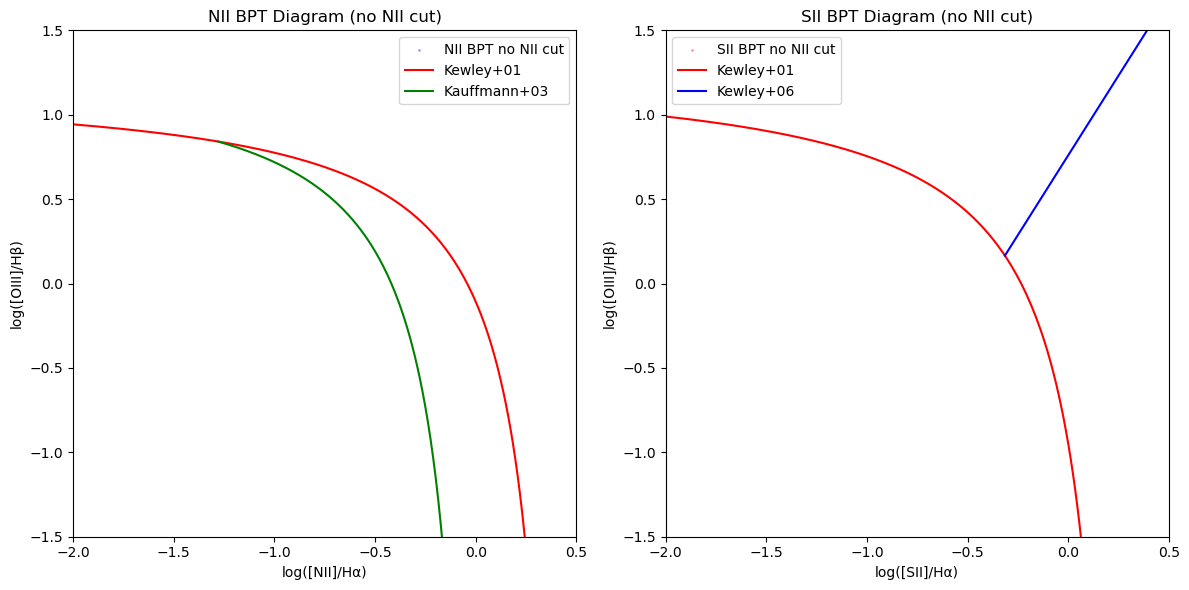

In [27]:
# Plot BPT diagrams for the spaxels in mask_BPT_no_NII but not in mask_BPT
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_BPT_no_NII & ~mask_BPT], logO3[mask_BPT_no_NII & ~mask_BPT], 
            s=1, alpha=0.3, color='blue', label='NII BPT no NII cut')
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (no NII cut)')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_BPT_no_NII & ~mask_BPT], logO3[mask_BPT_no_NII & ~mask_BPT], 
            s=1, alpha=0.3, color='red', label='SII BPT no NII cut')
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (no NII cut)')
plt.legend()
plt.tight_layout()
plt.show()

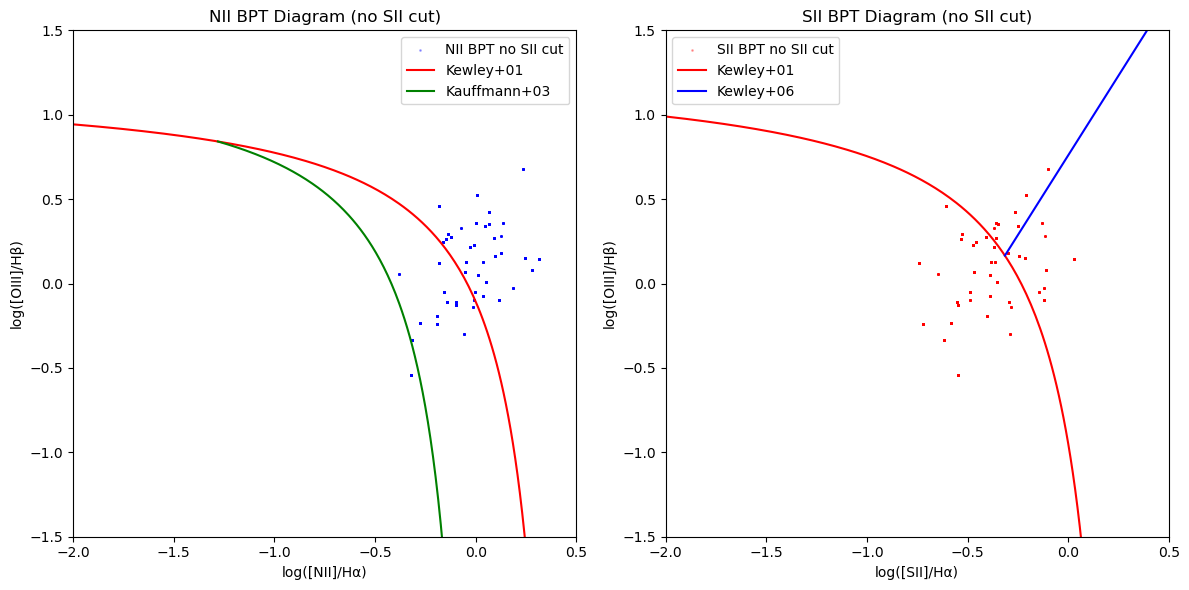

In [28]:
# Plot BPT diagrams for the spaxels in mask_BPT_no_SII but not in mask_BPT
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_BPT_no_SII & ~mask_BPT], logO3[mask_BPT_no_SII & ~mask_BPT], 
            s=1, alpha=0.3, color='blue', label='NII BPT no SII cut')
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (no SII cut)')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_BPT_no_SII & ~mask_BPT], logO3[mask_BPT_no_SII & ~mask_BPT], 
            s=1, alpha=0.3, color='red', label='SII BPT no SII cut')
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (no SII cut)')
plt.legend()
plt.tight_layout()
plt.show()

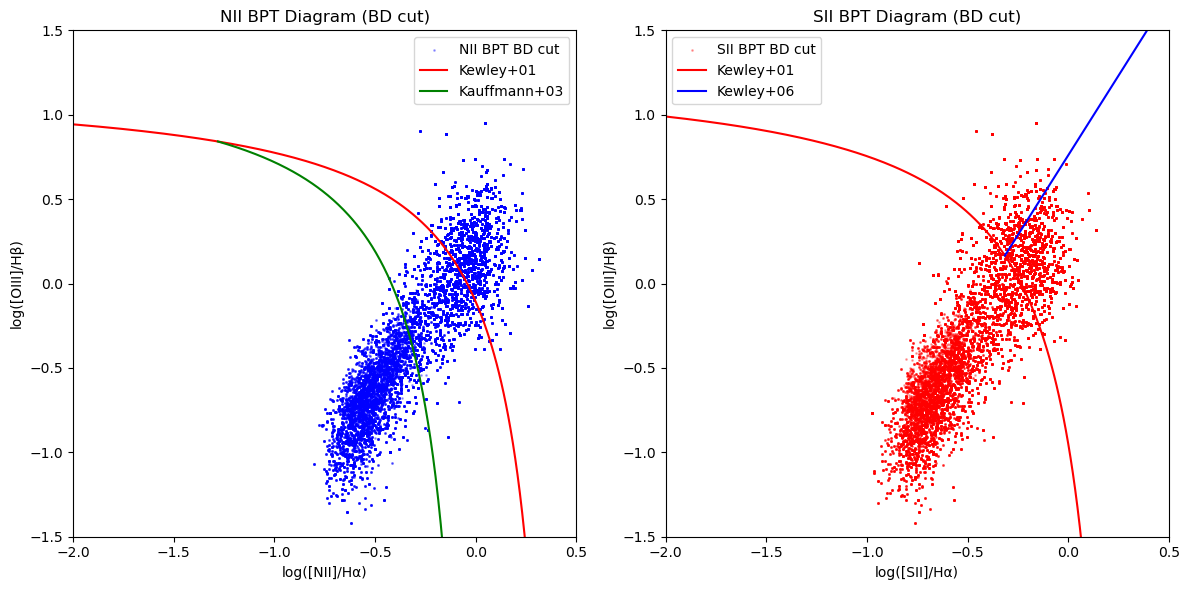

In [29]:
# Plot BPT diagrams for the spaxels in mask_BD
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_BD], logO3[mask_BD], 
            s=1, alpha=0.3, color='blue', label='NII BPT BD cut')
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (BD cut)')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_BD], logO3[mask_BD], 
            s=1, alpha=0.3, color='red', label='SII BPT BD cut')
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (BD cut)')
plt.legend()
plt.tight_layout()
plt.show()

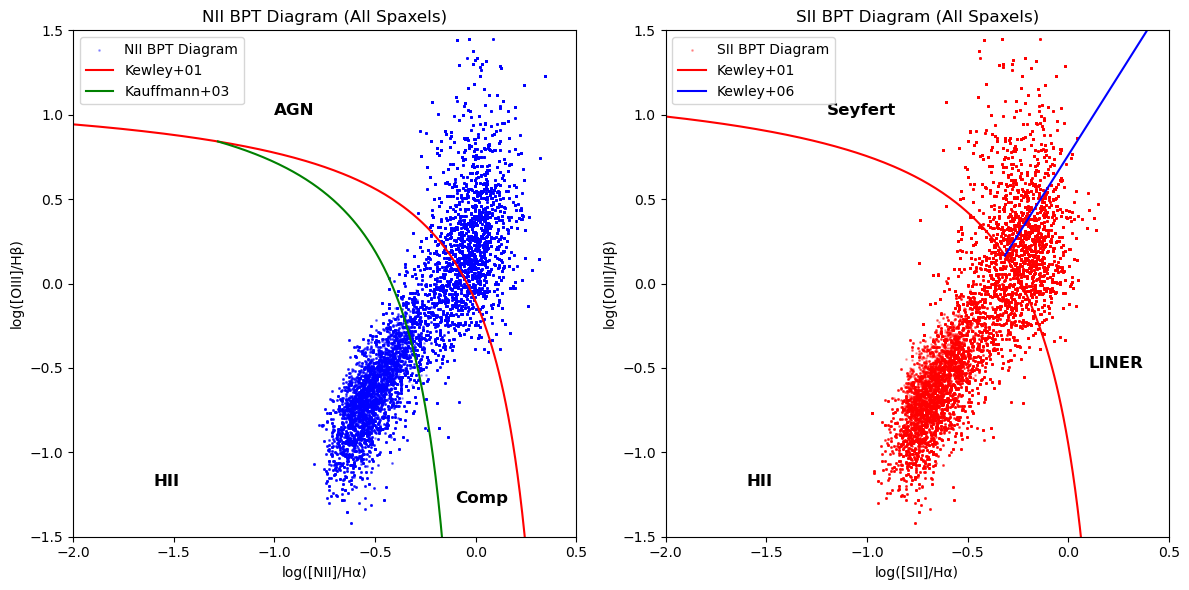

In [30]:
# Plot BPT diagrams for the spaxels in mask_BPT
from matplotlib import pyplot as plt


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(logN2, logO3, 
            s=1, alpha=0.3, color='blue', label='NII BPT Diagram')
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (All Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')
plt.subplot(1, 2, 2)
plt.scatter(logS2, logO3, 
            s=1, alpha=0.3, color='red', label='SII BPT Diagram')
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (All Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Hi Rongjun. Thanks. A lot to digest. I will try to come dowstairs early afternoon for a chat (I have a few time-sensitive things to take care of this morning) but this looks good. My first suggestion is to slightly re-adapt the main sequence plots. At the moment, you are plotting the median for above a S/N and below a S/N. By doing this, of course we will always get a difference. The question here is more when a population above a certain cut starts becoming non representative of the whole population. So, I would proceed as follows:

Define a cut below which we consider the data as non detected or not reliable. In my mind this should be something around ~3. If the Balmer lines have flux/flux_err lower than 3 I would treat them as upper limits and see where they lie. 

Then, the spaxels with ratio higher than 3 represents your "control sample".

So, when you increase the cut, you can compare the medians for the "control sample" with those for the sample with the new cut. In this way, you can see when the medians start deviating. 

Once this is clear, we can see if we can relax the cut on the BPT. 
I hope this makes sense. 

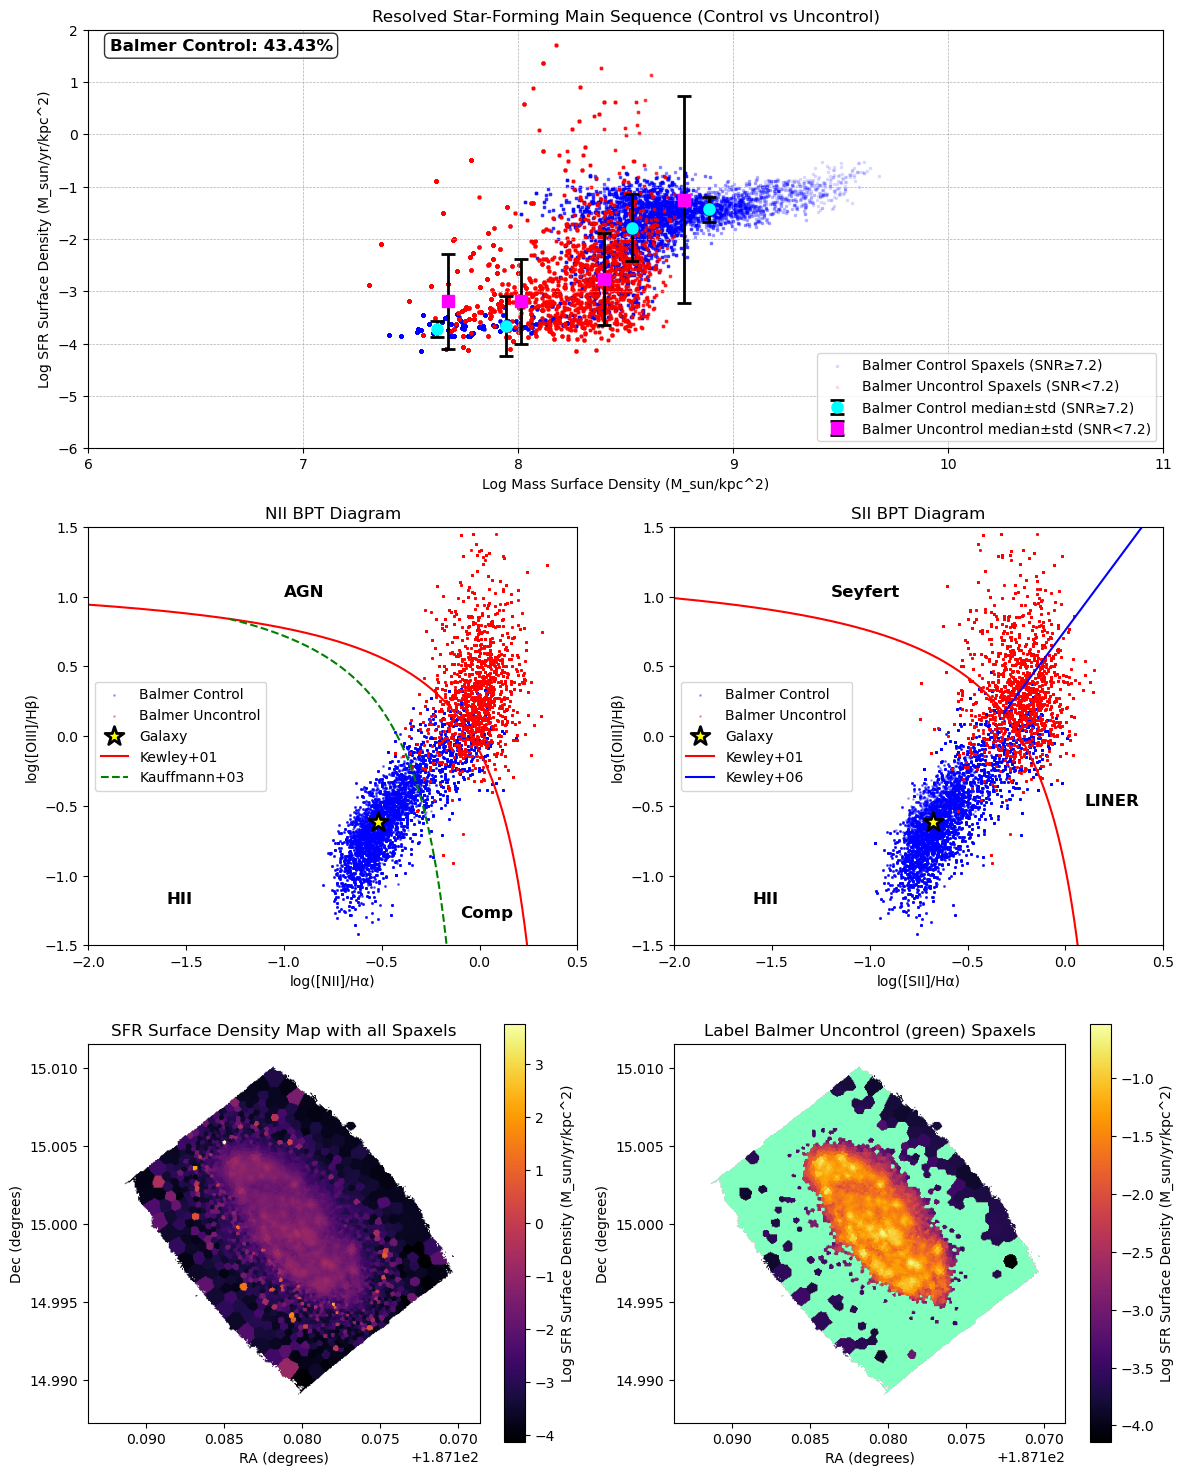

In [31]:
# Apply the SNR cut to each line, this time define >=3 as control and <3 as uncontrol
control_cut = 7.2
control, uncontrol = apply_cut(control_cut)

# Extract individual masks
HB4861_FLUX_control = control['HB4861']
HB4861_FLUX_uncontrol = uncontrol['HB4861']
HA6562_FLUX_control = control['HA6562']
HA6562_FLUX_uncontrol = uncontrol['HA6562']
OIII5006_FLUX_control = control['OIII5006']
OIII5006_FLUX_uncontrol = uncontrol['OIII5006']
NII6583_FLUX_control = control['NII6583']
NII6583_FLUX_uncontrol = uncontrol['NII6583']
SII6716_FLUX_control = control['SII6716']
SII6716_FLUX_uncontrol = uncontrol['SII6716']
SII6730_FLUX_control = control['SII6730']
SII6730_FLUX_uncontrol = uncontrol['SII6730']   

# create a mask for balmer lines have SNR >= control_cut
mask_BD_control = HB4861_FLUX_control & HA6562_FLUX_control 
mask_BD_uncontrol = ~mask_BD_control
# create a mask for all lines have SNR >= control_cut
mask_all_control = (HB4861_FLUX_control & HA6562_FLUX_control & 
                    OIII5006_FLUX_control & NII6583_FLUX_control &
                    SII6716_FLUX_control & SII6730_FLUX_control)
mask_all_uncontrol = ~mask_all_control

# Calculate statistics for control and uncontrol
control_x_med, control_med, control_std = calculate_bin_stats(LOGMASS_SURFACE_DENSITY[mask_BD_control].flatten(), 
                                                              LOG_SFR_surface_density_map[mask_BD_control].flatten(), x_bins)
uncontrol_x_med, uncontrol_med, uncontrol_std = calculate_bin_stats(LOGMASS_SURFACE_DENSITY[mask_BD_uncontrol].flatten(), 
                                                                    LOG_SFR_surface_density_map[mask_BD_uncontrol].flatten(), x_bins)


# Calculate flux-weighted representative points for BPT diagrams
# For N2-BPT diagram
if np.sum(mask_BD_control) > 0:
    galaxy_logO3_N2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_BD_control])/np.nansum(HB4861_FLUX_corr[mask_BD_control]))
    galaxy_logN2 = np.log10(np.nansum(NII6583_FLUX_corr[mask_BD_control])/np.nansum(HA6562_FLUX_corr[mask_BD_control]))
else:
    galaxy_logN2 = np.nan
    galaxy_logO3_N2 = np.nan

# For S2-BPT diagram
if np.sum(mask_BD_control) > 0:
    galaxy_logO3_S2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_BD_control])/np.nansum(HB4861_FLUX_corr[mask_BD_control]))
    galaxy_logS2 = np.log10(np.nansum((SII6716_FLUX_corr + SII6730_FLUX_corr)[mask_BD_control]) / np.nansum(HA6562_FLUX_corr[mask_BD_control]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_S2 = np.nan

# Create a subplot layout
fig = plt.figure(figsize=(12, 15))

# Top subplot spanning both columns - rSFMS plot
plt.subplot(3, 2, (1, 2))  # This spans columns 1 and 2 in row 1
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_BD_control], 
            LOG_SFR_surface_density_map[mask_BD_control], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'Balmer Control Spaxels (SNR≥{control_cut})')
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_BD_uncontrol], 
            LOG_SFR_surface_density_map[mask_BD_uncontrol], 
            s=1, marker=',', alpha=0.1, color='red', label=f'Balmer Uncontrol Spaxels (SNR<{control_cut})')

# Plot median with error bars
plt.errorbar(control_x_med, control_med, yerr=control_std, fmt='o', color='cyan', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'Balmer Control median±std (SNR≥{control_cut})')
plt.errorbar(uncontrol_x_med, uncontrol_med, yerr=uncontrol_std, fmt='s', color='magenta', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'Balmer Uncontrol median±std (SNR<{control_cut})')

# Calculate percentage of control spaxels
total_non_nan = np.isfinite(LOGMASS_SURFACE_DENSITY) & np.isfinite(LOG_SFR_surface_density_map)
control_count = np.sum(mask_BD_control & total_non_nan)
total_count = np.sum(total_non_nan)
control_percentage = (control_count / total_count) * 100

# Annotate percentage on top left
plt.text(0.02, 0.98, f'Balmer Control: {control_percentage:.2f}%', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('Log SFR Surface Density (M_sun/yr/kpc^2)')    
plt.title('Resolved Star-Forming Main Sequence (Control vs Uncontrol)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')

# Bottom left - NII BPT diagram
plt.subplot(3, 2, 3)
plt.scatter(logN2[mask_BD_control], logO3[mask_BD_control], 
            s=1, alpha=0.3, color='blue', label='Balmer Control')
plt.scatter(logN2[mask_BD_uncontrol], logO3[mask_BD_uncontrol], 
            s=1, alpha=0.3, color='red', label='Balmer Uncontrol')
# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g--', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

# Bottom right - SII BPT diagram
plt.subplot(3, 2, 4)
plt.scatter(logS2[mask_BD_control], logO3[mask_BD_control], 
            s=1, alpha=0.3, color='blue', label='Balmer Control')
plt.scatter(logS2[mask_BD_uncontrol], logO3[mask_BD_uncontrol], 
            s=1, alpha=0.3, color='red', label='Balmer Uncontrol')
# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

# plot SFR surface density map but label uncontrol spaxels
# plot SFR surface density map but label uncontrol spaxels
plt.subplot(3, 2, 5)
# Get the extent from WCS for proper coordinate axes
y_size, x_size = LOG_SFR_surface_density_map.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]

plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', extent=extent)
plt.colorbar(label='Log SFR Surface Density (M_sun/yr/kpc^2)') 
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('SFR Surface Density Map with all Spaxels')

plt.subplot(3, 2, 6)
plt.imshow(np.where(mask_BD_control, LOG_SFR_surface_density_map, np.nan), origin='lower', cmap='inferno', extent=extent)
plt.colorbar(label='Log SFR Surface Density (M_sun/yr/kpc^2)')
plt.imshow(np.where(mask_BD_uncontrol*(~np.isnan(LOG_SFR_surface_density_map)), -99, np.nan), 
           origin='lower', cmap='winter', alpha=0.5, vmin=-100, vmax=-99, extent=extent)    
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Label Balmer Uncontrol (green) Spaxels')

plt.tight_layout()
plt.show()

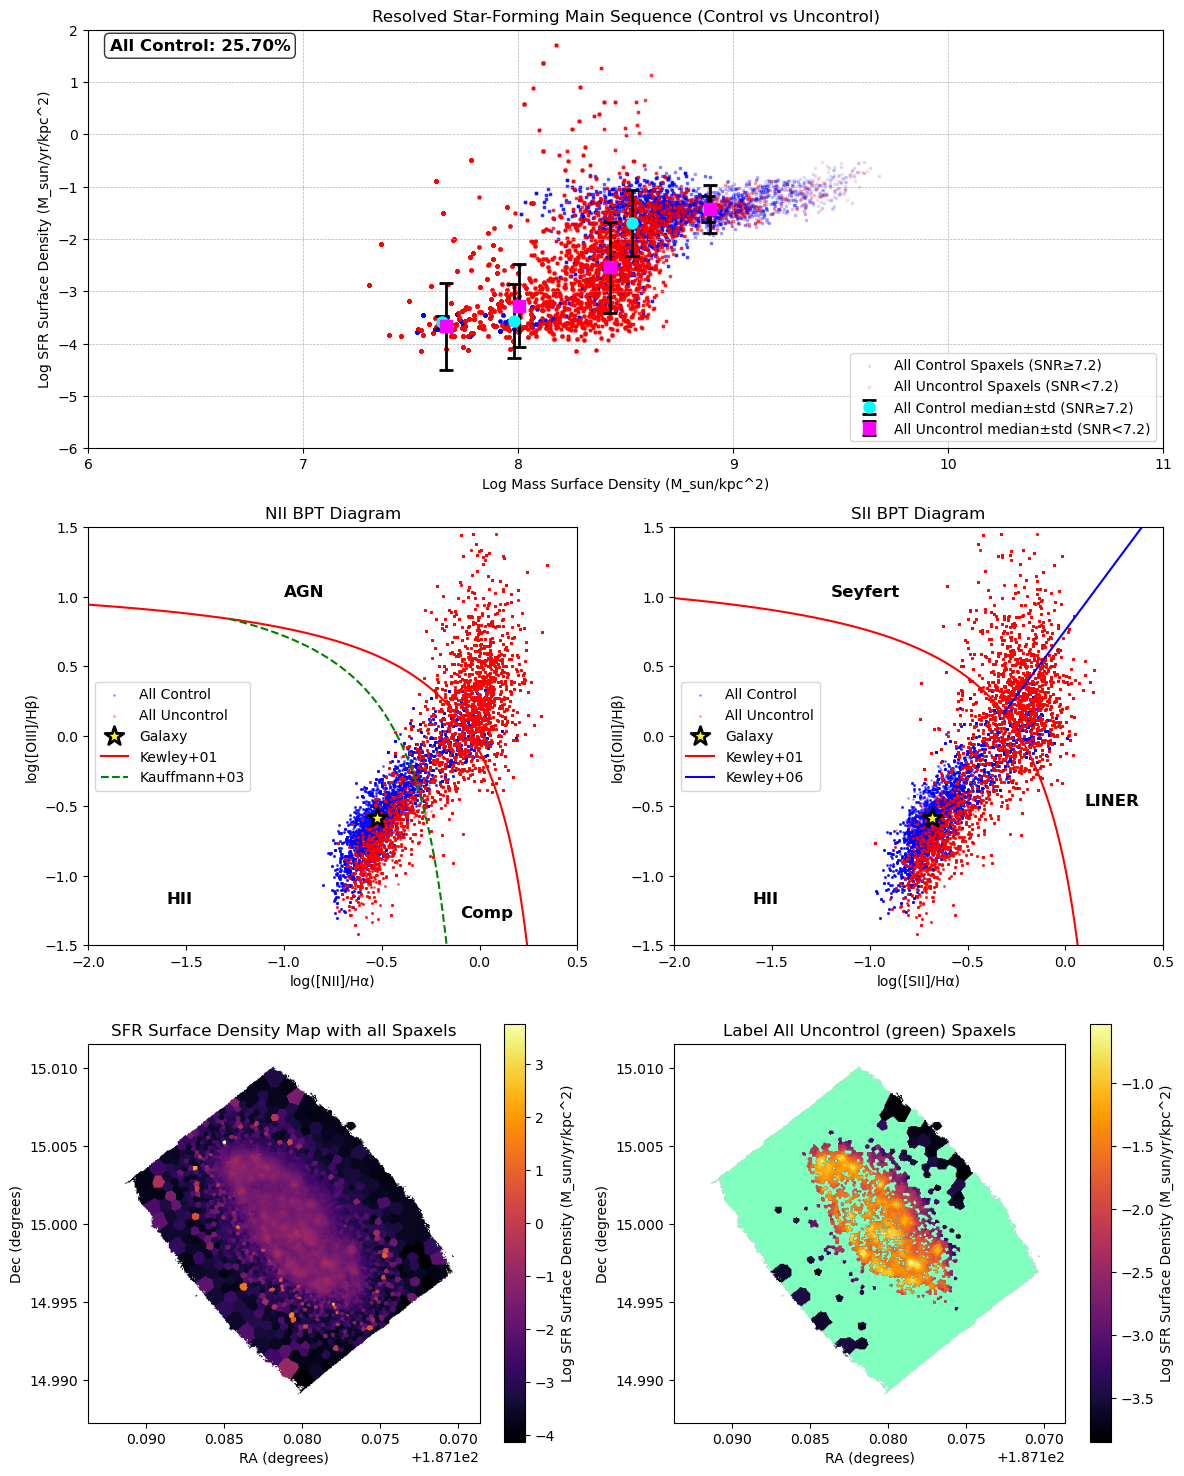

In [32]:
# Calculate statistics for control and uncontrol
control_x_med, control_med, control_std = calculate_bin_stats(LOGMASS_SURFACE_DENSITY[mask_all_control].flatten(), 
                                                              LOG_SFR_surface_density_map[mask_all_control].flatten(), x_bins)
uncontrol_x_med, uncontrol_med, uncontrol_std = calculate_bin_stats(LOGMASS_SURFACE_DENSITY[mask_all_uncontrol].flatten(), 
                                                                    LOG_SFR_surface_density_map[mask_all_uncontrol].flatten(), x_bins)

# Calculate flux-weighted representative points for BPT diagrams
# For N2-BPT diagram
if np.sum(mask_all_control) > 0:
    galaxy_logO3_N2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_all_control])/np.nansum(HB4861_FLUX_corr[mask_all_control]))
    galaxy_logN2 = np.log10(np.nansum(NII6583_FLUX_corr[mask_all_control])/np.nansum(HA6562_FLUX_corr[mask_all_control]))
else:
    galaxy_logN2 = np.nan
    galaxy_logO3_N2 = np.nan

# For S2-BPT diagram
if np.sum(mask_all_control) > 0:
    galaxy_logO3_S2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_all_control])/np.nansum(HB4861_FLUX_corr[mask_all_control]))
    galaxy_logS2 = np.log10(np.nansum((SII6716_FLUX_corr + SII6730_FLUX_corr)[mask_all_control]) / np.nansum(HA6562_FLUX_corr[mask_all_control]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_S2 = np.nan

# Create a subplot layout
fig = plt.figure(figsize=(12, 15))

# Top subplot spanning both columns - rSFMS plot
plt.subplot(3, 2, (1, 2))  # This spans columns 1 and 2 in row 1
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_all_control], 
            LOG_SFR_surface_density_map[mask_all_control], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'All Control Spaxels (SNR≥{control_cut})')
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_all_uncontrol], 
            LOG_SFR_surface_density_map[mask_all_uncontrol], 
            s=1, marker=',', alpha=0.1, color='red', label=f'All Uncontrol Spaxels (SNR<{control_cut})')

# Plot median with error bars
plt.errorbar(control_x_med, control_med, yerr=control_std, fmt='o', color='cyan', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'All Control median±std (SNR≥{control_cut})')
plt.errorbar(uncontrol_x_med, uncontrol_med, yerr=uncontrol_std, fmt='s', color='magenta', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'All Uncontrol median±std (SNR<{control_cut})')

# Calculate percentage of control spaxels
total_non_nan = np.isfinite(LOGMASS_SURFACE_DENSITY) & np.isfinite(LOG_SFR_surface_density_map)
control_count = np.sum(mask_all_control & total_non_nan)
total_count = np.sum(total_non_nan)
control_percentage = (control_count / total_count) * 100

# Annotate percentage on top left
plt.text(0.02, 0.98, f'All Control: {control_percentage:.2f}%', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('Log SFR Surface Density (M_sun/yr/kpc^2)')    
plt.title('Resolved Star-Forming Main Sequence (Control vs Uncontrol)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')

# Bottom left - NII BPT diagram
plt.subplot(3, 2, 3)
plt.scatter(logN2[mask_all_control], logO3[mask_all_control], 
            s=1, alpha=0.3, color='blue', label='All Control')
plt.scatter(logN2[mask_all_uncontrol], logO3[mask_all_uncontrol], 
            s=1, alpha=0.3, color='red', label='All Uncontrol')
# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g--', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

# Bottom right - SII BPT diagram
plt.subplot(3, 2, 4)
plt.scatter(logS2[mask_all_control], logO3[mask_all_control], 
            s=1, alpha=0.3, color='blue', label='All Control')
plt.scatter(logS2[mask_all_uncontrol], logO3[mask_all_uncontrol], 
            s=1, alpha=0.3, color='red', label='All Uncontrol')
# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

# plot SFR surface density map but label uncontrol spaxels
# plot SFR surface density map but label uncontrol spaxels
plt.subplot(3, 2, 5)
# Get the extent from WCS for proper coordinate axes
y_size, x_size = LOG_SFR_surface_density_map.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]

plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', extent=extent)
plt.colorbar(label='Log SFR Surface Density (M_sun/yr/kpc^2)') 
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('SFR Surface Density Map with all Spaxels')

plt.subplot(3, 2, 6)
plt.imshow(np.where(mask_all_control, LOG_SFR_surface_density_map, np.nan), origin='lower', cmap='inferno', extent=extent)
plt.colorbar(label='Log SFR Surface Density (M_sun/yr/kpc^2)')
plt.imshow(np.where(mask_all_uncontrol*(~np.isnan(LOG_SFR_surface_density_map)), -99, np.nan), 
           origin='lower', cmap='winter', alpha=0.5, vmin=-100, vmax=-99, extent=extent)    
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Label All Uncontrol (green) Spaxels')

plt.tight_layout()
plt.show()

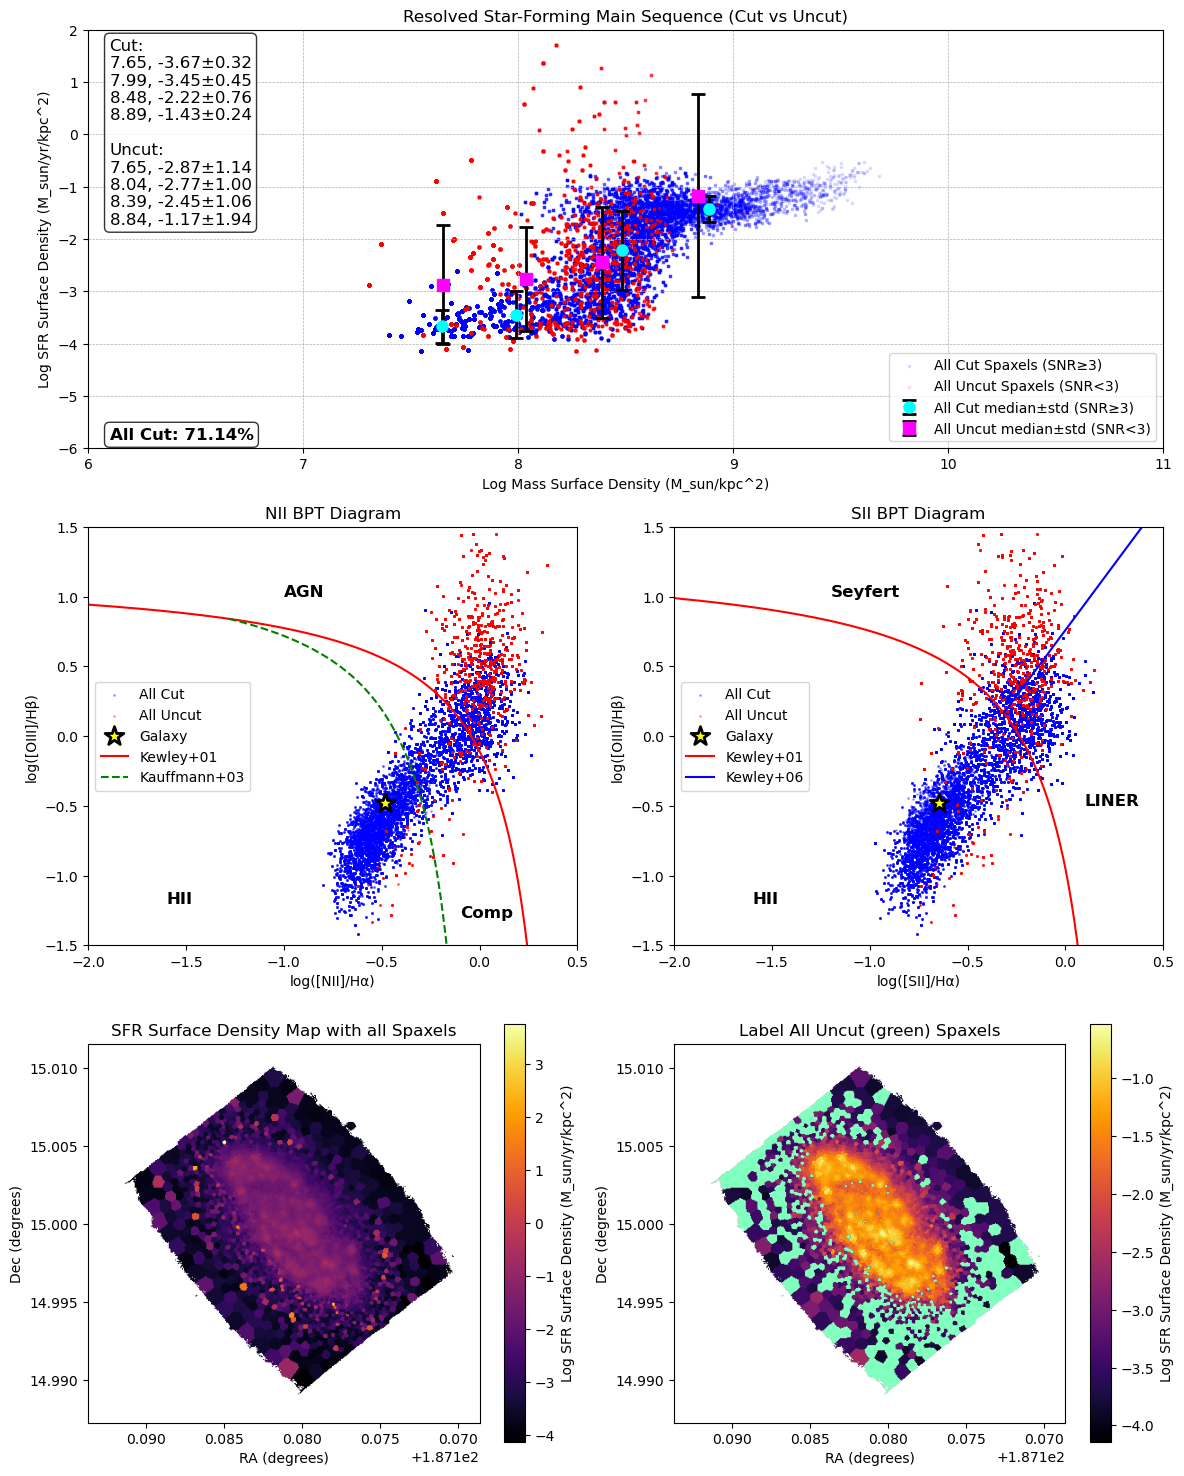

In [33]:
# Calculate statistics for cut and uncut
cut_x_med, cut_med, cut_std = calculate_bin_stats(LOGMASS_SURFACE_DENSITY[mask_BPT].flatten(), 
                                                              LOG_SFR_surface_density_map[mask_BPT].flatten(), x_bins)
uncut_x_med, uncut_med, uncut_std = calculate_bin_stats(LOGMASS_SURFACE_DENSITY[~mask_BPT].flatten(), 
                                                                    LOG_SFR_surface_density_map[~mask_BPT].flatten(), x_bins)

# Calculate flux-weighted representative points for BPT diagrams
# For N2-BPT diagram
if np.sum(mask_BPT) > 0:
    galaxy_logO3_N2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_BPT])/np.nansum(HB4861_FLUX_corr[mask_BPT]))
    galaxy_logN2 = np.log10(np.nansum(NII6583_FLUX_corr[mask_BPT])/np.nansum(HA6562_FLUX_corr[mask_BPT]))
else:
    galaxy_logN2 = np.nan
    galaxy_logO3_N2 = np.nan

# For S2-BPT diagram
if np.sum(mask_BPT) > 0:
    galaxy_logO3_S2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_BPT])/np.nansum(HB4861_FLUX_corr[mask_BPT]))
    galaxy_logS2 = np.log10(np.nansum((SII6716_FLUX_corr + SII6730_FLUX_corr)[mask_BPT]) / np.nansum(HA6562_FLUX_corr[mask_BPT]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_S2 = np.nan

# Create a subplot layout
fig = plt.figure(figsize=(12, 15))

# Top subplot spanning both columns - rSFMS plot
plt.subplot(3, 2, (1, 2))  # This spans columns 1 and 2 in row 1
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_BPT], 
            LOG_SFR_surface_density_map[mask_BPT], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'All Cut Spaxels (SNR≥{cut})')
plt.scatter(LOGMASS_SURFACE_DENSITY[~mask_BPT], 
            LOG_SFR_surface_density_map[~mask_BPT], 
            s=1, marker=',', alpha=0.1, color='red', label=f'All Uncut Spaxels (SNR<{cut})')

# Plot median with error bars
plt.errorbar(cut_x_med, cut_med, yerr=cut_std, fmt='o', color='cyan', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'All Cut median±std (SNR≥{cut})')
plt.errorbar(uncut_x_med, uncut_med, yerr=uncut_std, fmt='s', color='magenta', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'All Uncut median±std (SNR<{cut})')

# Calculate percentage of cut spaxels
total_non_nan = np.isfinite(LOGMASS_SURFACE_DENSITY) & np.isfinite(LOG_SFR_surface_density_map)
cut_count = np.sum(mask_BPT & total_non_nan)
total_count = np.sum(total_non_nan)
cut_percentage = (cut_count / total_count) * 100

# Annotate percentage on bottom left
plt.text(0.02, 0.05, f'All Cut: {cut_percentage:.2f}%', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Annotate cut statistics on top left
stats_text = 'Cut:\n'
for i in range(len(cut_x_med)):
    stats_text += f'{cut_x_med[i]:.2f}, {cut_med[i]:.2f}±{cut_std[i]:.2f}\n'

# Add uncut statistics to the same text box
stats_text += '\nUncut:\n'
for i in range(len(uncut_x_med)):
    stats_text += f'{uncut_x_med[i]:.2f}, {uncut_med[i]:.2f}±{uncut_std[i]:.2f}\n'

plt.text(0.02, 0.98, stats_text.strip(), 
         transform=plt.gca().transAxes, fontsize=12, fontweight='normal',
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('Log SFR Surface Density (M_sun/yr/kpc^2)')    
plt.title('Resolved Star-Forming Main Sequence (Cut vs Uncut)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')

# Bottom left - NII BPT diagram
plt.subplot(3, 2, 3)
plt.scatter(logN2[mask_BPT], logO3[mask_BPT], 
            s=1, alpha=0.3, color='blue', label='All Cut')
plt.scatter(logN2[~mask_BPT], logO3[~mask_BPT], 
            s=1, alpha=0.3, color='red', label='All Uncut')
# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g--', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

# Bottom right - SII BPT diagram
plt.subplot(3, 2, 4)
plt.scatter(logS2[mask_BPT], logO3[mask_BPT], 
            s=1, alpha=0.3, color='blue', label='All Cut')
plt.scatter(logS2[~mask_BPT], logO3[~mask_BPT], 
            s=1, alpha=0.3, color='red', label='All Uncut')
# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

# plot SFR surface density map but label uncut spaxels
# plot SFR surface density map but label uncut spaxels
plt.subplot(3, 2, 5)
# Get the extent from WCS for proper coordinate axes
y_size, x_size = LOG_SFR_surface_density_map.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]

plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', extent=extent)
plt.colorbar(label='Log SFR Surface Density (M_sun/yr/kpc^2)') 
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('SFR Surface Density Map with all Spaxels')

plt.subplot(3, 2, 6)
plt.imshow(np.where(mask_BPT, LOG_SFR_surface_density_map, np.nan), origin='lower', cmap='inferno', extent=extent)
plt.colorbar(label='Log SFR Surface Density (M_sun/yr/kpc^2)')
plt.imshow(np.where((~mask_BPT)*(~np.isnan(LOG_SFR_surface_density_map)), -99, np.nan), 
           origin='lower', cmap='winter', alpha=0.5, vmin=-100, vmax=-99, extent=extent)    
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Label All Uncut (green) Spaxels')

plt.tight_layout()
plt.show()

In [34]:
# Error propogation for BPT diagrams (sigma of log_10(numerator/denominator))
def bpt_error_propagation(numerator, denominator, numerator_err, denominator_err):
    """
    Calculate the propagated error for the BPT ratio log10(numerator/denominator).
    
    Parameters:
    numerator (np.ndarray): The numerator values.
    denominator (np.ndarray): The denominator values.
    numerator_err (np.ndarray): The error in the numerator.
    denominator_err (np.ndarray): The error in the denominator.
    
    Returns:
    np.ndarray: The propagated error for the BPT ratio.
    """
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = numerator / denominator
        log_ratio = np.log10(ratio)
        log_ratio_err = 1/(np.abs(log_ratio) * np.log(10)) * np.abs(ratio) * np.sqrt((numerator_err / numerator)**2 + (denominator_err / denominator)**2)
        return log_ratio_err
    
# Calculate the errors for the BPT ratios
logN2_err = bpt_error_propagation(NII6583_FLUX, HA6562_FLUX, 
                                   NII6583_FLUX_ERR, HA6562_FLUX_ERR)
logS2_err = bpt_error_propagation(SII6716_FLUX + SII6730_FLUX, HA6562_FLUX, 
                                    np.sqrt(SII6716_FLUX_ERR**2 + SII6730_FLUX_ERR**2), HA6562_FLUX_ERR)
logO3_err = bpt_error_propagation(OIII5006_FLUX, HB4861_FLUX, 
                                   OIII5006_FLUX_ERR, HB4861_FLUX_ERR)

# # Plot the BPT diagrams with error bars (only for the uncontrol spaxels)
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.errorbar(logN2[mask_BD_uncontrol], logO3[mask_BD_uncontrol], 
#              xerr=logN2_err[mask_BD_uncontrol], 
#              yerr=logO3_err[mask_BD_uncontrol], 
#              fmt='o', markersize=1, alpha=0.3, color='red', label='Uncontrol Spaxels (SNR < 3)')
# plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
# plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
# plt.xlabel('log([NII]/Hα)')
# plt.ylabel('log([OIII]/Hβ)')
# plt.xlim(-2.0, 0.5)
# plt.ylim(-1.5, 1.5)
# plt.title('NII BPT Diagram (Uncontrol Spaxels with Errors)')
# plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
# plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
# plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
# plt.legend(loc='upper left')
# plt.subplot(1, 2, 2)
# plt.errorbar(logS2[mask_BD_uncontrol], logO3[mask_BD_uncontrol], 
#              xerr=logS2_err[mask_BD_uncontrol], 
#              yerr=logO3_err[mask_BD_uncontrol], 
#              fmt='o', markersize=1, alpha=0.3, color='red', label='Uncontrol Spaxels (SNR < 3)')
# plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
# plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
# plt.xlabel('log([SII]/Hα)')
# plt.ylabel('log([OIII]/Hβ)')    
# plt.xlim(-2.0, 0.5)
# plt.ylim(-1.5, 1.5)
# plt.title('SII BPT Diagram (Uncontrol Spaxels with Errors)')    
# plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
# plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
# plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
# plt.legend(loc='upper left')
# plt.tight_layout()
# plt.show()

In [35]:
# now I want to use the error bars to determine the mask called mask_constraint, 
# which is for each point, its value +/- errorbars, are all still inside the same region of on the BPT. 
# These regions are HII+Comp and AGN for NII BPT; and HII, LINER and Syfert for SII BPT. 


mask_N2_left, mask_S2_left = apply_bpt_masks(logN2=logN2-logN2_err, logS2=logS2-logS2_err, logO3=logO3)
mask_N2_right, mask_S2_right = apply_bpt_masks(logN2=logN2+logN2_err, logS2=logS2+logS2_err, logO3=logO3)
mask_N2_down, mask_S2_down = apply_bpt_masks(logN2=logN2, logS2=logS2, logO3=logO3-logO3_err)
mask_N2_up, mask_S2_up = apply_bpt_masks(logN2=logN2, logS2=logS2, logO3=logO3+logO3_err)

mask_N2_left_HII, mask_N2_left_Comp, mask_N2_left_AGN = mask_N2_left
mask_N2_right_HII, mask_N2_right_Comp, mask_N2_right_AGN = mask_N2_right
mask_N2_down_HII, mask_N2_down_Comp, mask_N2_down_AGN = mask_N2_down
mask_N2_up_HII, mask_N2_up_Comp, mask_N2_up_AGN = mask_N2_up
mask_S2_left_HII, mask_S2_left_LINER, mask_S2_left_Syfert = mask_S2_left
mask_S2_right_HII, mask_S2_right_LINER, mask_S2_right_Syfert = mask_S2_right
mask_S2_down_HII, mask_S2_down_LINER, mask_S2_down_Syfert = mask_S2_down
mask_S2_up_HII, mask_S2_up_LINER, mask_S2_up_Syfert = mask_S2_up

mask_constraint_N2_HII_Comp = ((mask_N2_left_HII | mask_N2_left_Comp) & 
                               (mask_N2_right_HII | mask_N2_right_Comp) & 
                                 (mask_N2_down_HII | mask_N2_down_Comp) &
                                 (mask_N2_up_HII | mask_N2_up_Comp))
mask_constraint_N2_AGN = (mask_N2_left_AGN & mask_N2_right_AGN &
                          mask_N2_down_AGN & mask_N2_up_AGN)
mask_constraint_S2_HII = (mask_S2_left_HII & mask_S2_right_HII &
                          mask_S2_down_HII & mask_S2_up_HII)
mask_constraint_S2_LINER = (mask_S2_left_LINER & mask_S2_right_LINER &
                            mask_S2_down_LINER & mask_S2_up_LINER)
mask_constraint_S2_Syfert = (mask_S2_left_Syfert & mask_S2_right_Syfert &
                             mask_S2_down_Syfert & mask_S2_up_Syfert)

mask_constraint_NII = (mask_constraint_N2_HII_Comp | mask_constraint_N2_AGN)
mask_constraint_SII = (mask_constraint_S2_HII | mask_constraint_S2_LINER |
                      mask_constraint_S2_Syfert)
mask_constraint_both = (mask_constraint_NII & mask_constraint_SII)
mask_constraint_either = (mask_constraint_NII | mask_constraint_SII)

mask_constraint = mask_constraint_both
mask_unconstraint = ~mask_constraint

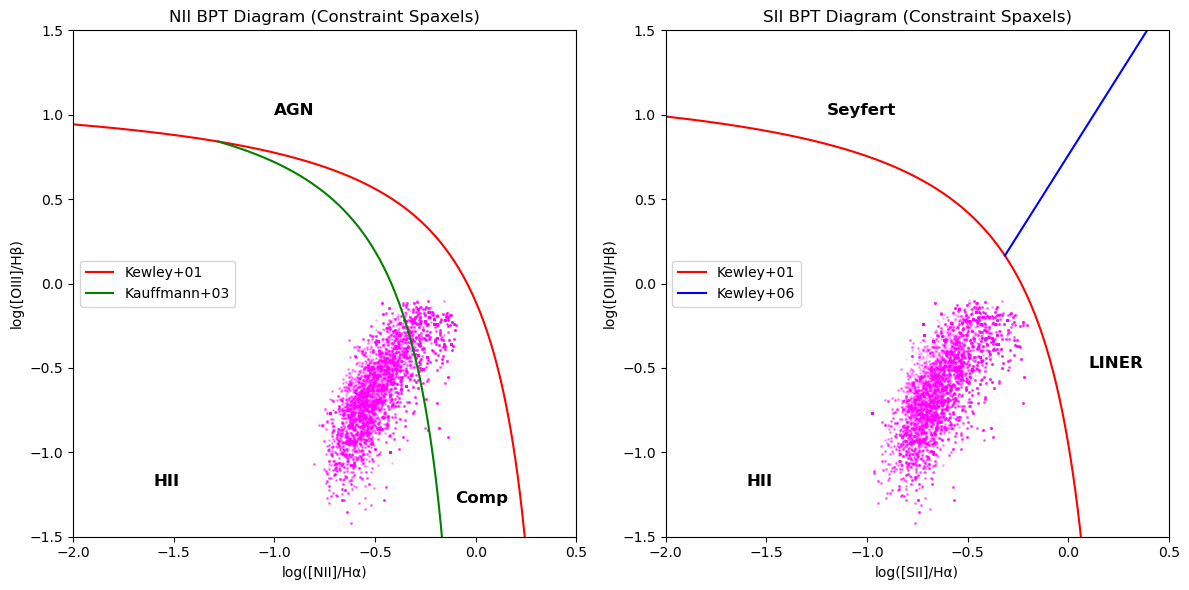

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_constraint], logO3[mask_constraint], 
            s=1, alpha=0.1, color='magenta')
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (Constraint Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_constraint], logO3[mask_constraint], 
            s=1, alpha=0.1, color='magenta')
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (Constraint Spaxels)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.tight_layout()
plt.show()

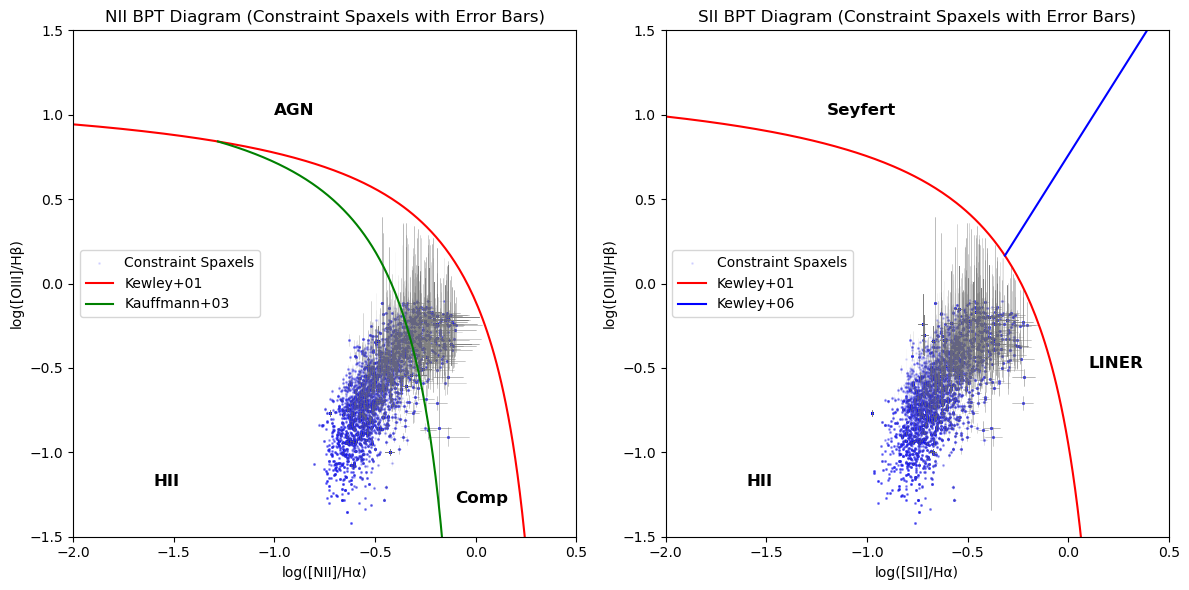

In [37]:
# Plot the BPT diagrams with error bars for the constraint spaxels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_constraint], logO3[mask_constraint], 
            s=1, alpha=0.1, color='blue', label='Constraint Spaxels')
plt.errorbar(logN2[mask_constraint], logO3[mask_constraint], 
             xerr=logN2_err[mask_constraint], yerr=logO3_err[mask_constraint],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (Constraint Spaxels with Error Bars)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_constraint], logO3[mask_constraint], 
            s=1, alpha=0.1, color='blue', label='Constraint Spaxels')
plt.errorbar(logS2[mask_constraint], logO3[mask_constraint], 
             xerr=logS2_err[mask_constraint], yerr=logO3_err[mask_constraint],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (Constraint Spaxels with Error Bars)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

plt.tight_layout()
plt.show()

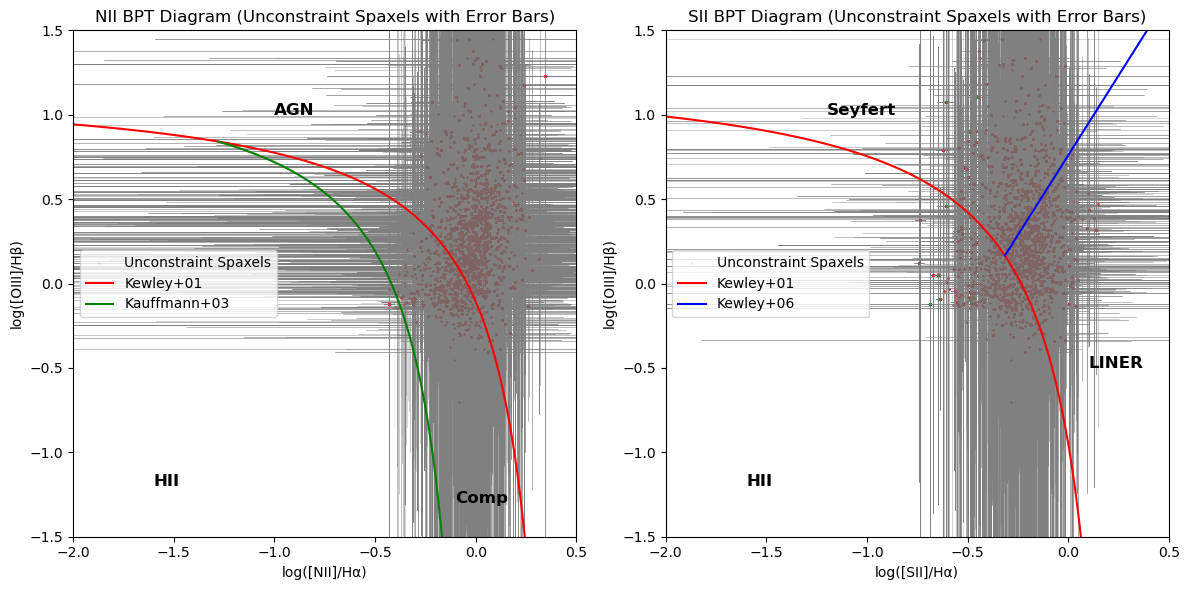

In [38]:
# Plot the BPT diagrams with error bars for the unconstraint spaxels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_unconstraint], logO3[mask_unconstraint], 
            s=1, alpha=0.1, color='red', label='Unconstraint Spaxels')
plt.errorbar(logN2[mask_unconstraint], logO3[mask_unconstraint], 
             xerr=logN2_err[mask_unconstraint], yerr=logO3_err[mask_unconstraint],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g-', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram (Unconstraint Spaxels with Error Bars)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')
plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_unconstraint], logO3[mask_unconstraint], 
            s=1, alpha=0.1, color='red', label='Unconstraint Spaxels')
plt.errorbar(logS2[mask_unconstraint], logO3[mask_unconstraint], 
             xerr=logS2_err[mask_unconstraint], yerr=logO3_err[mask_unconstraint],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram (Unconstraint Spaxels with Error Bars)')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')
plt.tight_layout()
plt.show()

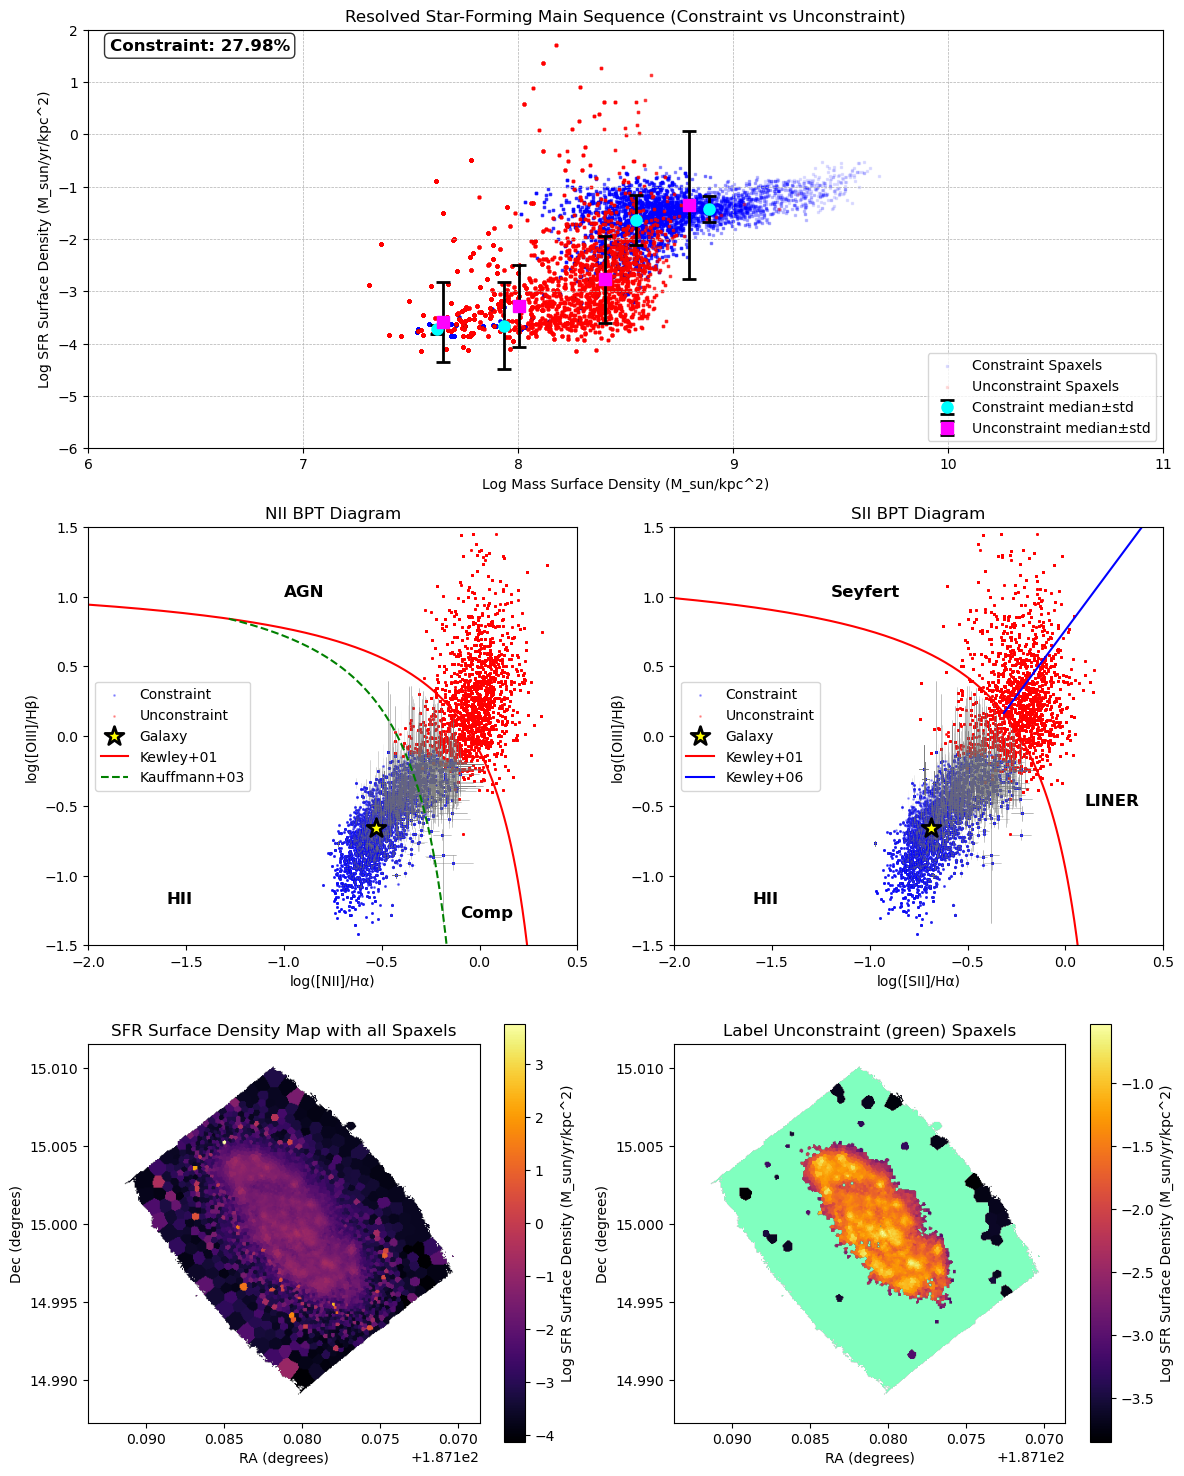

In [39]:
# Calculate statistics for constraint and unconstraint
constraint_x_med, constraint_med, constraint_std = calculate_bin_stats(LOGMASS_SURFACE_DENSITY[mask_constraint].flatten(), 
                                                              LOG_SFR_surface_density_map[mask_constraint].flatten(), x_bins)
unconstraint_x_med, unconstraint_med, unconstraint_std = calculate_bin_stats(LOGMASS_SURFACE_DENSITY[mask_unconstraint].flatten(), 
                                                                    LOG_SFR_surface_density_map[mask_unconstraint].flatten(), x_bins)

# Calculate flux-weighted representative points for BPT diagrams
# For N2-BPT diagram
if np.sum(mask_constraint) > 0:
    galaxy_logO3_N2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_constraint])/np.nansum(HB4861_FLUX_corr[mask_constraint]))
    galaxy_logN2 = np.log10(np.nansum(NII6583_FLUX_corr[mask_constraint])/np.nansum(HA6562_FLUX_corr[mask_constraint]))
else:
    galaxy_logN2 = np.nan
    galaxy_logO3_N2 = np.nan

# For S2-BPT diagram
if np.sum(mask_constraint) > 0:
    galaxy_logO3_S2 = np.log10(np.nansum(OIII5006_FLUX_corr[mask_constraint])/np.nansum(HB4861_FLUX_corr[mask_constraint]))
    galaxy_logS2 = np.log10(np.nansum((SII6716_FLUX_corr + SII6730_FLUX_corr)[mask_constraint]) / np.nansum(HA6562_FLUX_corr[mask_constraint]))
else:
    galaxy_logS2 = np.nan
    galaxy_logO3_S2 = np.nan

# Create a subplot layout
fig = plt.figure(figsize=(12, 15))

# Top subplot spanning both columns - rSFMS plot
plt.subplot(3, 2, (1, 2))  # This spans columns 1 and 2 in row 1
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_constraint], 
            LOG_SFR_surface_density_map[mask_constraint], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'Constraint Spaxels')
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_unconstraint], 
            LOG_SFR_surface_density_map[mask_unconstraint], 
            s=1, marker=',', alpha=0.1, color='red', label=f'Unconstraint Spaxels')

# Plot median with error bars
plt.errorbar(constraint_x_med, constraint_med, yerr=constraint_std, fmt='o', color='cyan', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'Constraint median±std')
plt.errorbar(unconstraint_x_med, unconstraint_med, yerr=unconstraint_std, fmt='s', color='magenta', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'Unconstraint median±std')

# Calculate percentage of constraint spaxels
total_non_nan = np.isfinite(LOGMASS_SURFACE_DENSITY) & np.isfinite(LOG_SFR_surface_density_map)
constraint_count = np.sum(mask_constraint & total_non_nan)
total_count = np.sum(total_non_nan)
constraint_percentage = (constraint_count / total_count) * 100

# Annotate percentage on top left
plt.text(0.02, 0.98, f'Constraint: {constraint_percentage:.2f}%', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('Log SFR Surface Density (M_sun/yr/kpc^2)')    
plt.title('Resolved Star-Forming Main Sequence (Constraint vs Unconstraint)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')

# Bottom left - NII BPT diagram
plt.subplot(3, 2, 3)
plt.scatter(logN2[mask_constraint], logO3[mask_constraint], 
            s=1, alpha=0.3, color='blue', label='Constraint')
plt.scatter(logN2[mask_unconstraint], logO3[mask_unconstraint], 
            s=1, alpha=0.3, color='red', label='Unconstraint')
# Add flux-weighted representative point
if not np.isnan(galaxy_logN2) and not np.isnan(galaxy_logO3_N2):
    plt.scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
plt.errorbar(logN2[mask_constraint], logO3[mask_constraint], 
             xerr=logN2_err[mask_constraint], yerr=logO3_err[mask_constraint],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g--', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

# Bottom right - SII BPT diagram
plt.subplot(3, 2, 4)
plt.scatter(logS2[mask_constraint], logO3[mask_constraint], 
            s=1, alpha=0.3, color='blue', label='Constraint')
plt.scatter(logS2[mask_unconstraint], logO3[mask_unconstraint], 
            s=1, alpha=0.3, color='red', label='Unconstraint')
# Add flux-weighted representative point
if not np.isnan(galaxy_logS2) and not np.isnan(galaxy_logO3_S2):
    plt.scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='yellow', 
                edgecolors='black', linewidth=2, label='Galaxy', zorder=10)
plt.errorbar(logS2[mask_constraint], logO3[mask_constraint], 
             xerr=logS2_err[mask_constraint], yerr=logO3_err[mask_constraint],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')

# plot SFR surface density map but label unconstraint spaxels
# plot SFR surface density map but label unconstraint spaxels
plt.subplot(3, 2, 5)
# Get the extent from WCS for proper coordinate axes
y_size, x_size = LOG_SFR_surface_density_map.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]

plt.imshow(LOG_SFR_surface_density_map, origin='lower', cmap='inferno', extent=extent)
plt.colorbar(label='Log SFR Surface Density (M_sun/yr/kpc^2)') 
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('SFR Surface Density Map with all Spaxels')

plt.subplot(3, 2, 6)
plt.imshow(np.where(mask_constraint, LOG_SFR_surface_density_map, np.nan), origin='lower', cmap='inferno', extent=extent)
plt.colorbar(label='Log SFR Surface Density (M_sun/yr/kpc^2)')
plt.imshow(np.where(mask_unconstraint*(~np.isnan(LOG_SFR_surface_density_map)), -99, np.nan), 
           origin='lower', cmap='winter', alpha=0.5, vmin=-100, vmax=-99, extent=extent)    
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Label Unconstraint (green) Spaxels')

plt.tight_layout()
plt.show()

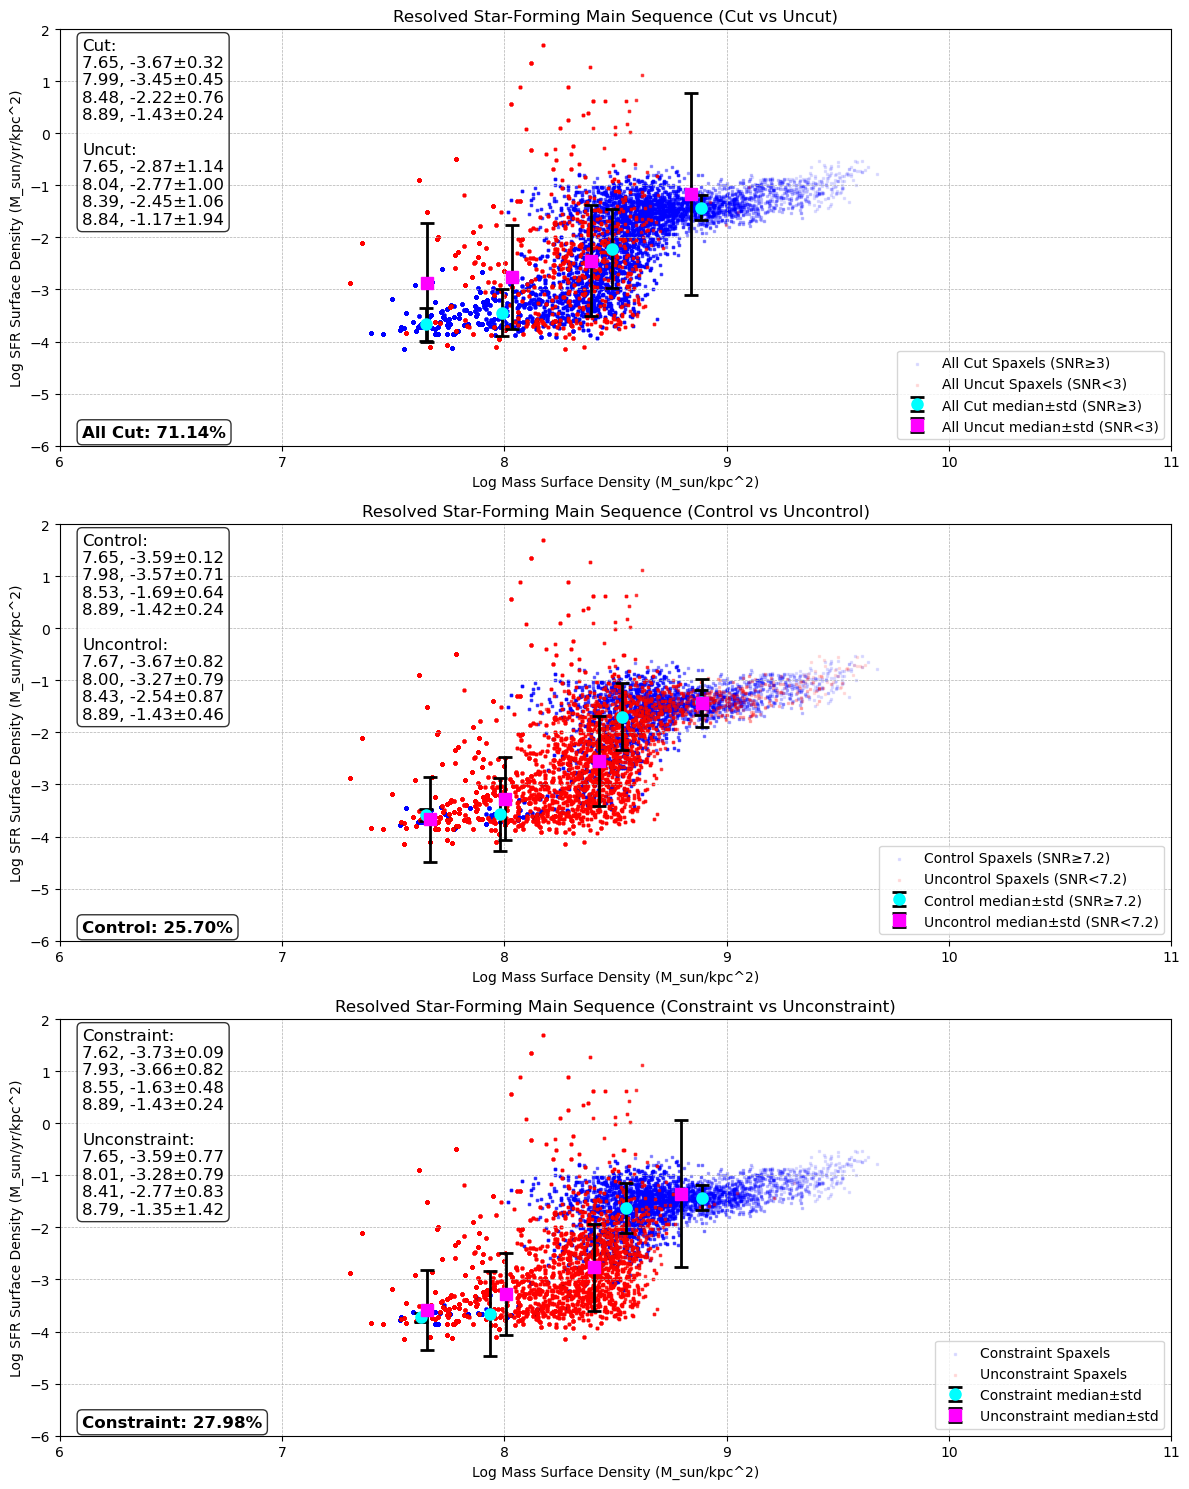

In [40]:
# plot rSFMS plot for cut-uncut, control-uncontrol, constraint-unconstraint
# Create a subplot layout
fig = plt.figure(figsize=(12, 15))
# Top subplot - rSFMS plot for cut vs uncut
plt.subplot(3, 1, 1)  
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_BPT], 
            LOG_SFR_surface_density_map[mask_BPT], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'All Cut Spaxels (SNR≥{cut})')
plt.scatter(LOGMASS_SURFACE_DENSITY[~mask_BPT], 
            LOG_SFR_surface_density_map[~mask_BPT], 
            s=1, marker=',', alpha=0.1, color='red', label=f'All Uncut Spaxels (SNR<{cut})')

# Plot median with error bars
plt.errorbar(cut_x_med, cut_med, yerr=cut_std, fmt='o', color='cyan', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'All Cut median±std (SNR≥{cut})')
plt.errorbar(uncut_x_med, uncut_med, yerr=uncut_std, fmt='s', color='magenta', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'All Uncut median±std (SNR<{cut})')

# Calculate percentage of cut spaxels
total_non_nan = np.isfinite(LOGMASS_SURFACE_DENSITY) & np.isfinite(LOG_SFR_surface_density_map)
cut_count = np.sum(mask_BPT & total_non_nan)
total_count = np.sum(total_non_nan)
cut_percentage = (cut_count / total_count) * 100

# Annotate percentage on bottom left
plt.text(0.02, 0.05, f'All Cut: {cut_percentage:.2f}%', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Annotate cut statistics on top left
stats_text = 'Cut:\n'
for i in range(len(cut_x_med)):
    stats_text += f'{cut_x_med[i]:.2f}, {cut_med[i]:.2f}±{cut_std[i]:.2f}\n'

# Add uncut statistics to the same text box
stats_text += '\nUncut:\n'
for i in range(len(uncut_x_med)):
    stats_text += f'{uncut_x_med[i]:.2f}, {uncut_med[i]:.2f}±{uncut_std[i]:.2f}\n'

plt.text(0.02, 0.98, stats_text.strip(), 
         transform=plt.gca().transAxes, fontsize=12, fontweight='normal',
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('Log SFR Surface Density (M_sun/yr/kpc^2)')    
plt.title('Resolved Star-Forming Main Sequence (Cut vs Uncut)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')

# middle subplot - rSFMS plot for control vs uncontrol
plt.subplot(3, 1, 2)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_all_control], 
            LOG_SFR_surface_density_map[mask_all_control], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'Control Spaxels (SNR≥{control_cut})')
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_all_uncontrol], 
            LOG_SFR_surface_density_map[mask_all_uncontrol], 
            s=1, marker=',', alpha=0.1, color='red', label=f'Uncontrol Spaxels (SNR<{control_cut})')
# Plot median with error bars
plt.errorbar(control_x_med, control_med, yerr=control_std, fmt='o', color='cyan', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'Control median±std (SNR≥{control_cut})')
plt.errorbar(uncontrol_x_med, uncontrol_med, yerr=uncontrol_std, fmt='s', color='magenta', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'Uncontrol median±std (SNR<{control_cut})')
# Calculate percentage of control spaxels
total_non_nan = np.isfinite(LOGMASS_SURFACE_DENSITY) & np.isfinite(LOG_SFR_surface_density_map)
control_count = np.sum(mask_all_control & total_non_nan)
total_count = np.sum(total_non_nan)
control_percentage = (control_count / total_count) * 100 
# Annotate percentage on bottom left
plt.text(0.02, 0.05, f'Control: {control_percentage:.2f}%', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
# Annotate control statistics on top left
stats_text = 'Control:\n'
for i in range(len(control_x_med)):
    stats_text += f'{control_x_med[i]:.2f}, {control_med[i]:.2f}±{control_std[i]:.2f}\n'
# Add uncontrol statistics to the same text box
stats_text += '\nUncontrol:\n'
for i in range(len(uncontrol_x_med)):
    stats_text += f'{uncontrol_x_med[i]:.2f}, {uncontrol_med[i]:.2f}±{uncontrol_std[i]:.2f}\n'
plt.text(0.02, 0.98, stats_text.strip(), 
         transform=plt.gca().transAxes, fontsize=12, fontweight='normal',
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('Log SFR Surface Density (M_sun/yr/kpc^2)')    
plt.title('Resolved Star-Forming Main Sequence (Control vs Uncontrol)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')

# Bottom subplot - rSFMS plot for constraint vs unconstraint
plt.subplot(3, 1, 3)
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_constraint], 
            LOG_SFR_surface_density_map[mask_constraint], 
            s=1, marker=',', alpha=0.1, color='blue', label=f'Constraint Spaxels')
plt.scatter(LOGMASS_SURFACE_DENSITY[mask_unconstraint], 
            LOG_SFR_surface_density_map[mask_unconstraint], 
            s=1, marker=',', alpha=0.1, color='red', label=f'Unconstraint Spaxels')
# Plot median with error bars
plt.errorbar(constraint_x_med, constraint_med, yerr=constraint_std, fmt='o', color='cyan', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'Constraint median±std')
plt.errorbar(unconstraint_x_med, unconstraint_med, yerr=unconstraint_std, fmt='s', color='magenta', markersize=8, 
             capsize=5, capthick=2, linewidth=2, ecolor='black', 
             label=f'Unconstraint median±std')
# Calculate percentage of constraint spaxels
total_non_nan = np.isfinite(LOGMASS_SURFACE_DENSITY) & np.isfinite(LOG_SFR_surface_density_map)
constraint_count = np.sum(mask_constraint & total_non_nan)
total_count = np.sum(total_non_nan)
constraint_percentage = (constraint_count / total_count) * 100
# Annotate percentage on bottom left
plt.text(0.02, 0.05, f'Constraint: {constraint_percentage:.2f}%', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
# Annotate constraint statistics on top left
stats_text = 'Constraint:\n'
for i in range(len(constraint_x_med)):
    stats_text += f'{constraint_x_med[i]:.2f}, {constraint_med[i]:.2f}±{constraint_std[i]:.2f}\n'
# Add unconstraint statistics to the same text box
stats_text += '\nUnconstraint:\n'
for i in range(len(unconstraint_x_med)):
    stats_text += f'{unconstraint_x_med[i]:.2f}, {unconstraint_med[i]:.2f}±{unconstraint_std[i]:.2f}\n'
plt.text(0.02, 0.98, stats_text.strip(),    
         transform=plt.gca().transAxes, fontsize=12, fontweight='normal',
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.xlabel('Log Mass Surface Density (M_sun/kpc^2)')
plt.ylabel('Log SFR Surface Density (M_sun/yr/kpc^2)')    
plt.title('Resolved Star-Forming Main Sequence (Constraint vs Unconstraint)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(6, 11)
plt.ylim(-6, 2)
plt.legend(loc='lower right')   
plt.tight_layout()
plt.show()

In [41]:
# check the unique minimum 5 non-nan values of S/N of halpha line in constraint and unconstraint
constraint_sn_HA6562_min = np.unique(np.sort((HA6562_FLUX / HA6562_FLUX_ERR)[mask_constraint][np.isfinite((HA6562_FLUX / HA6562_FLUX_ERR)[mask_constraint])]))[:5]
unconstraint_sn_HA6562_min = np.unique(np.sort((HA6562_FLUX / HA6562_FLUX_ERR)[mask_unconstraint][np.isfinite((HA6562_FLUX / HA6562_FLUX_ERR)[mask_unconstraint])]))[:5]

# do for all the other lines as well
constraint_sn_HB4861_min = np.unique(np.sort((HB4861_FLUX / HB4861_FLUX_ERR)[mask_constraint][np.isfinite((HB4861_FLUX / HB4861_FLUX_ERR)[mask_constraint])]))[:5]
unconstraint_sn_HB4861_min = np.unique(np.sort((HB4861_FLUX / HB4861_FLUX_ERR)[mask_unconstraint][np.isfinite((HB4861_FLUX / HB4861_FLUX_ERR)[mask_unconstraint])]))[:5]
constraint_sn_NII6583_min = np.unique(np.sort((NII6583_FLUX / NII6583_FLUX_ERR)[mask_constraint][np.isfinite((NII6583_FLUX / NII6583_FLUX_ERR)[mask_constraint])]))[:5]
unconstraint_sn_NII6583_min = np.unique(np.sort((NII6583_FLUX / NII6583_FLUX_ERR)[mask_unconstraint][np.isfinite((NII6583_FLUX / NII6583_FLUX_ERR)[mask_unconstraint])]))[:5]
constraint_sn_OIII5006_min = np.unique(np.sort((OIII5006_FLUX / OIII5006_FLUX_ERR)[mask_constraint][np.isfinite((OIII5006_FLUX / OIII5006_FLUX_ERR)[mask_constraint])]))[:5]
unconstraint_sn_OIII5006_min = np.unique(np.sort((OIII5006_FLUX / OIII5006_FLUX_ERR)[mask_unconstraint][np.isfinite((OIII5006_FLUX / OIII5006_FLUX_ERR)[mask_unconstraint])]))[:5]
constraint_sn_SII6716_min = np.unique(np.sort((SII6716_FLUX / SII6716_FLUX_ERR)[mask_constraint][np.isfinite((SII6716_FLUX / SII6716_FLUX_ERR)[mask_constraint])]))[:5]
unconstraint_sn_SII6716_min = np.unique(np.sort((SII6716_FLUX / SII6716_FLUX_ERR)[mask_unconstraint][np.isfinite((SII6716_FLUX / SII6716_FLUX_ERR)[mask_unconstraint])]))[:5]
constraint_sn_SII6730_min = np.unique(np.sort((SII6730_FLUX / SII6730_FLUX_ERR)[mask_constraint][np.isfinite((SII6730_FLUX / SII6730_FLUX_ERR)[mask_constraint])]))[:5]
unconstraint_sn_SII6730_min = np.unique(np.sort((SII6730_FLUX / SII6730_FLUX_ERR)[mask_unconstraint][np.isfinite((SII6730_FLUX / SII6730_FLUX_ERR)[mask_unconstraint])]))[:5]
print("Minimum 5 unique S/N values for Hα in constraint spaxels:", constraint_sn_HA6562_min)
print("Minimum 5 unique S/N values for Hα in unconstraint spaxels:", unconstraint_sn_HA6562_min)
print("Minimum 5 unique S/N values for Hβ in constraint spaxels:", constraint_sn_HB4861_min)
print("Minimum 5 unique S/N values for Hβ in unconstraint spaxels:", unconstraint_sn_HB4861_min)
print("Minimum 5 unique S/N values for [NII]6583 in constraint spaxels:", constraint_sn_NII6583_min)
print("Minimum 5 unique S/N values for [NII]6583 in unconstraint spaxels:", unconstraint_sn_NII6583_min)
print("Minimum 5 unique S/N values for [OIII]5006 in constraint spaxels:", constraint_sn_OIII5006_min)
print("Minimum 5 unique S/N values for [OIII]5006 in unconstraint spaxels:", unconstraint_sn_OIII5006_min)
print("Minimum 5 unique S/N values for [SII]6716 in constraint spaxels:", constraint_sn_SII6716_min)
print("Minimum 5 unique S/N values for [SII]6716 in unconstraint spaxels:", unconstraint_sn_SII6716_min)
print("Minimum 5 unique S/N values for [SII]6730 in constraint spaxels:", constraint_sn_SII6730_min)
print("Minimum 5 unique S/N values for [SII]6730 in unconstraint spaxels:", unconstraint_sn_SII6730_min)

Minimum 5 unique S/N values for Hα in constraint spaxels: [12.76197489 15.33368325 15.91407702 18.2765651  19.20868423]
Minimum 5 unique S/N values for Hα in unconstraint spaxels: [ 7.4371538   7.56444876  8.97213157  9.6700315  10.06489908]
Minimum 5 unique S/N values for Hβ in constraint spaxels: [1.9991529  5.04422121 5.10947587 5.24356503 5.28583527]
Minimum 5 unique S/N values for Hβ in unconstraint spaxels: [0.         0.01311529 0.02907209 0.05863046 0.05920448]
Minimum 5 unique S/N values for [NII]6583 in constraint spaxels: [12.39178423 14.60183992 15.70470096 15.83392463 17.82795679]
Minimum 5 unique S/N values for [NII]6583 in unconstraint spaxels: [11.27069003 12.81392206 13.87644248 14.03453227 14.11548388]
Minimum 5 unique S/N values for [OIII]5006 in constraint spaxels: [0.19636474 0.57752517 0.8836244  1.15280392 1.51702949]
Minimum 5 unique S/N values for [OIII]5006 in unconstraint spaxels: [0.         1.17324318 1.31556217 1.37776251 1.39453851]
Minimum 5 unique S/N v

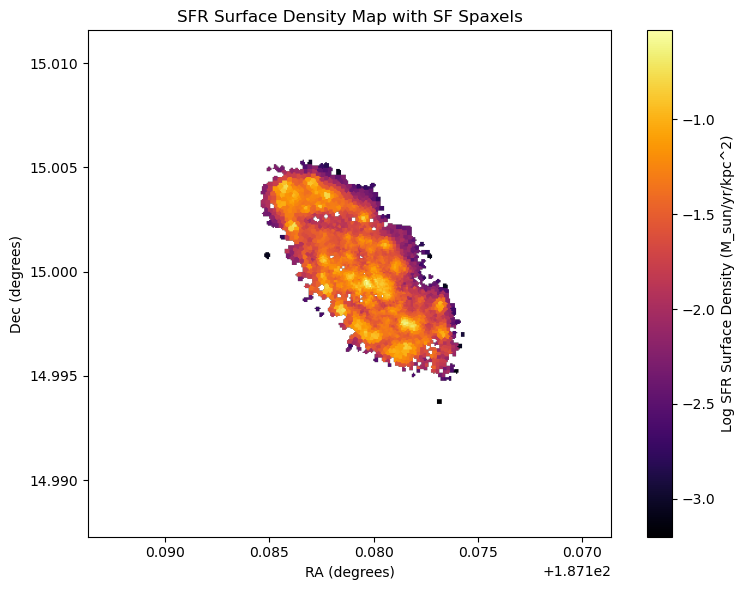

Total SFR rate in SF spaxels: 1.57e-01 M_sun/yr or log10(SFR) = -0.80  M_sun/yr


In [42]:
LOG_SFR_surface_density_map_SF = np.where(mask_constraint&SF_mask&mask_QC_good, LOG_SFR_surface_density_map, np.nan)
SFR_map_SF = np.where(mask_constraint&SF_mask&mask_QC_good, SFR_map, np.nan)

# plot SFR surface density map but label SF spaxels
plt.figure(figsize=(8, 6))
# Get the extent from WCS for proper coordinate axes
y_size, x_size = LOG_SFR_surface_density_map_SF.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]
plt.imshow(LOG_SFR_surface_density_map_SF, origin='lower', cmap='inferno', extent=extent)
plt.colorbar(label='Log SFR Surface Density (M_sun/yr/kpc^2)') 
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('SFR Surface Density Map with SF Spaxels')
plt.tight_layout()
plt.show()

# print total SFR rate
total_SFR_rate = np.nansum(SFR_map_SF)
print(f'Total SFR rate in SF spaxels: {total_SFR_rate:.2e} M_sun/yr or log10(SFR) = {np.log10(total_SFR_rate):.2f}  M_sun/yr')


In [43]:
# # save the SFR surface density map for SF spaxels and SFR map for all spaxels to a single FITS file
# binning_path = Path('IC3392_SPATIAL_BINNING_maps_extended.fits')
# output_path = Path('IC3392_SFR_maps.fits')

# # Create a new HDU list starting with the gas file structure
# with fits.open(binning_path) as hdul:
#     new_hdul = fits.HDUList([hdu.copy() for hdu in hdul])

# # Add SFR map for all spaxels (not log)
# hdu_sfr_all = fits.ImageHDU(SFR_map.astype(np.float64),
#                             header=gas_header, name="SFR_MAP_ALL")
# hdu_sfr_all.header['BUNIT'] = 'M_sun/yr'
# new_hdul.append(hdu_sfr_all)

# # Add SFR surface density map for all spaxels (log)
# hdu_logsfr_all = fits.ImageHDU(LOG_SFR_surface_density_map.astype(np.float64),
#                                header=gas_header, name="LOGSFR_SURFACE_DENSITY_ALL")
# hdu_logsfr_all.header['BUNIT'] = 'log(M_sun/yr/kpc2)'
# new_hdul.append(hdu_logsfr_all)

# # Add SFR surface density map for SF spaxels
# hdu_sfr_sf = fits.ImageHDU(LOG_SFR_surface_density_map_SF.astype(np.float64),
#                            header=gas_header, name="LOGSFR_SURFACE_DENSITY_SF")
# hdu_sfr_sf.header['BUNIT'] = 'log(M_sun/yr/kpc2)'
# new_hdul.append(hdu_sfr_sf)

# # Write to file
# new_hdul.writeto(output_path, overwrite=True)
# print(f"SFR maps saved to {output_path}")


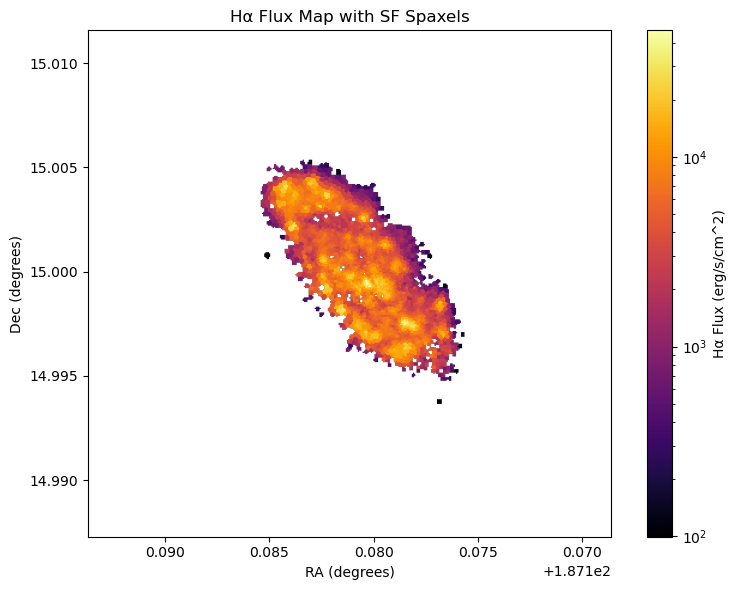

In [44]:
HA6562_FLUX_corr_SF = np.where(mask_constraint&SF_mask&mask_QC_good, HA6562_FLUX_corr, np.nan)

# plot H-alpha flux map but label SF spaxels
plt.figure(figsize=(8, 6))
# Get the extent from WCS for proper coordinate axes
y_size, x_size = HA6562_FLUX_corr_SF.shape
x_coords = np.arange(x_size)
y_coords = np.arange(y_size)
xx, yy = np.meshgrid(x_coords, y_coords)
# Convert pixel coordinates to world coordinates
ra, dec = legacy_wcs2.pixel_to_world_values(xx, yy)
extent = [ra.max(), ra.min(), dec.min(), dec.max()]  # [left, right, bottom, top]
plt.imshow(HA6562_FLUX_corr_SF, origin='lower', cmap='inferno', extent=extent, norm=LogNorm(vmin=np.nanmin(HA6562_FLUX_corr_SF), vmax=np.nanmax(HA6562_FLUX_corr_SF)))
plt.colorbar(label='Hα Flux (erg/s/cm^2)') 
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Hα Flux Map with SF Spaxels')
plt.tight_layout()
plt.show()

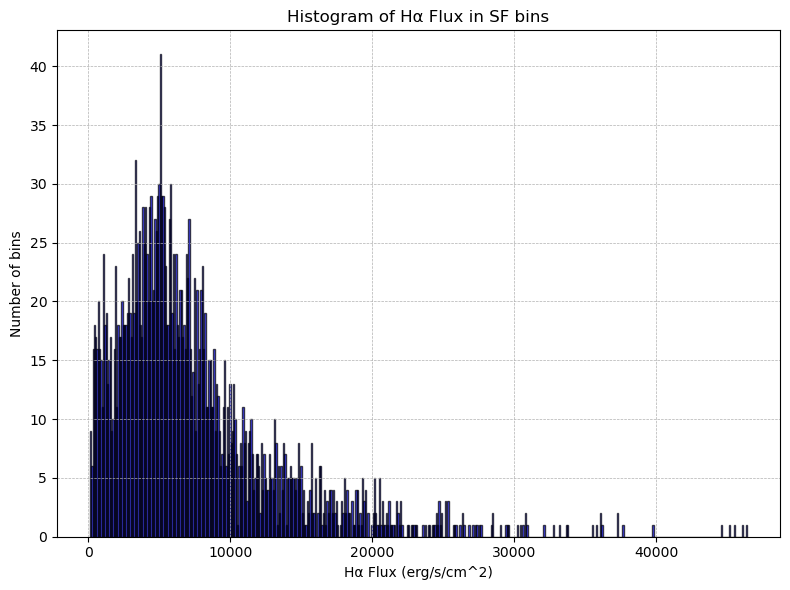

Minimum 5 unique Hα flux values in SF spaxels: [ 99.54898013 120.02797435 128.90523011 135.35495589 137.53938434
 138.51813705 140.05158199 158.15447355 190.06015197 233.42433854
 250.79382542 251.35064031 268.29295833 280.47429931 283.78823595
 293.84671343 295.80802459 296.37758121 297.04042617 297.55729203
 301.23678249 316.1412438  318.90791309 322.4340828  323.57932241
 329.38821058 341.02338243 350.50879907 364.47089226 372.55671853
 374.21959909 396.4024844  397.94624564 402.63550022 406.05245387
 412.18264364 416.2873249  419.1962162  421.94808322 431.08147778
 436.46992989 444.96521074 446.44209335 450.23175356 450.5210195
 451.29645364 452.08869489 455.2802618  459.48061148 474.15729102]


In [45]:
# plot the histogram of non-nan Hα flux in SF spaxels
plt.figure(figsize=(8, 6))
plt.hist(np.unique(HA6562_FLUX_corr_SF[~np.isnan(HA6562_FLUX_corr_SF)]), 
         bins=500, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Hα Flux (erg/s/cm^2)')
plt.ylabel('Number of bins')
plt.title('Histogram of Hα Flux in SF bins')
# plt.xscale('log')
# plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Print the minimum 50 of np.unique(HA6562_FLUX_corr_SF[~np.isnan(HA6562_FLUX_corr_SF)])
print("Minimum 5 unique Hα flux values in SF spaxels:", 
      np.unique(np.sort(HA6562_FLUX_corr_SF[~np.isnan(HA6562_FLUX_corr_SF)]))[:50])


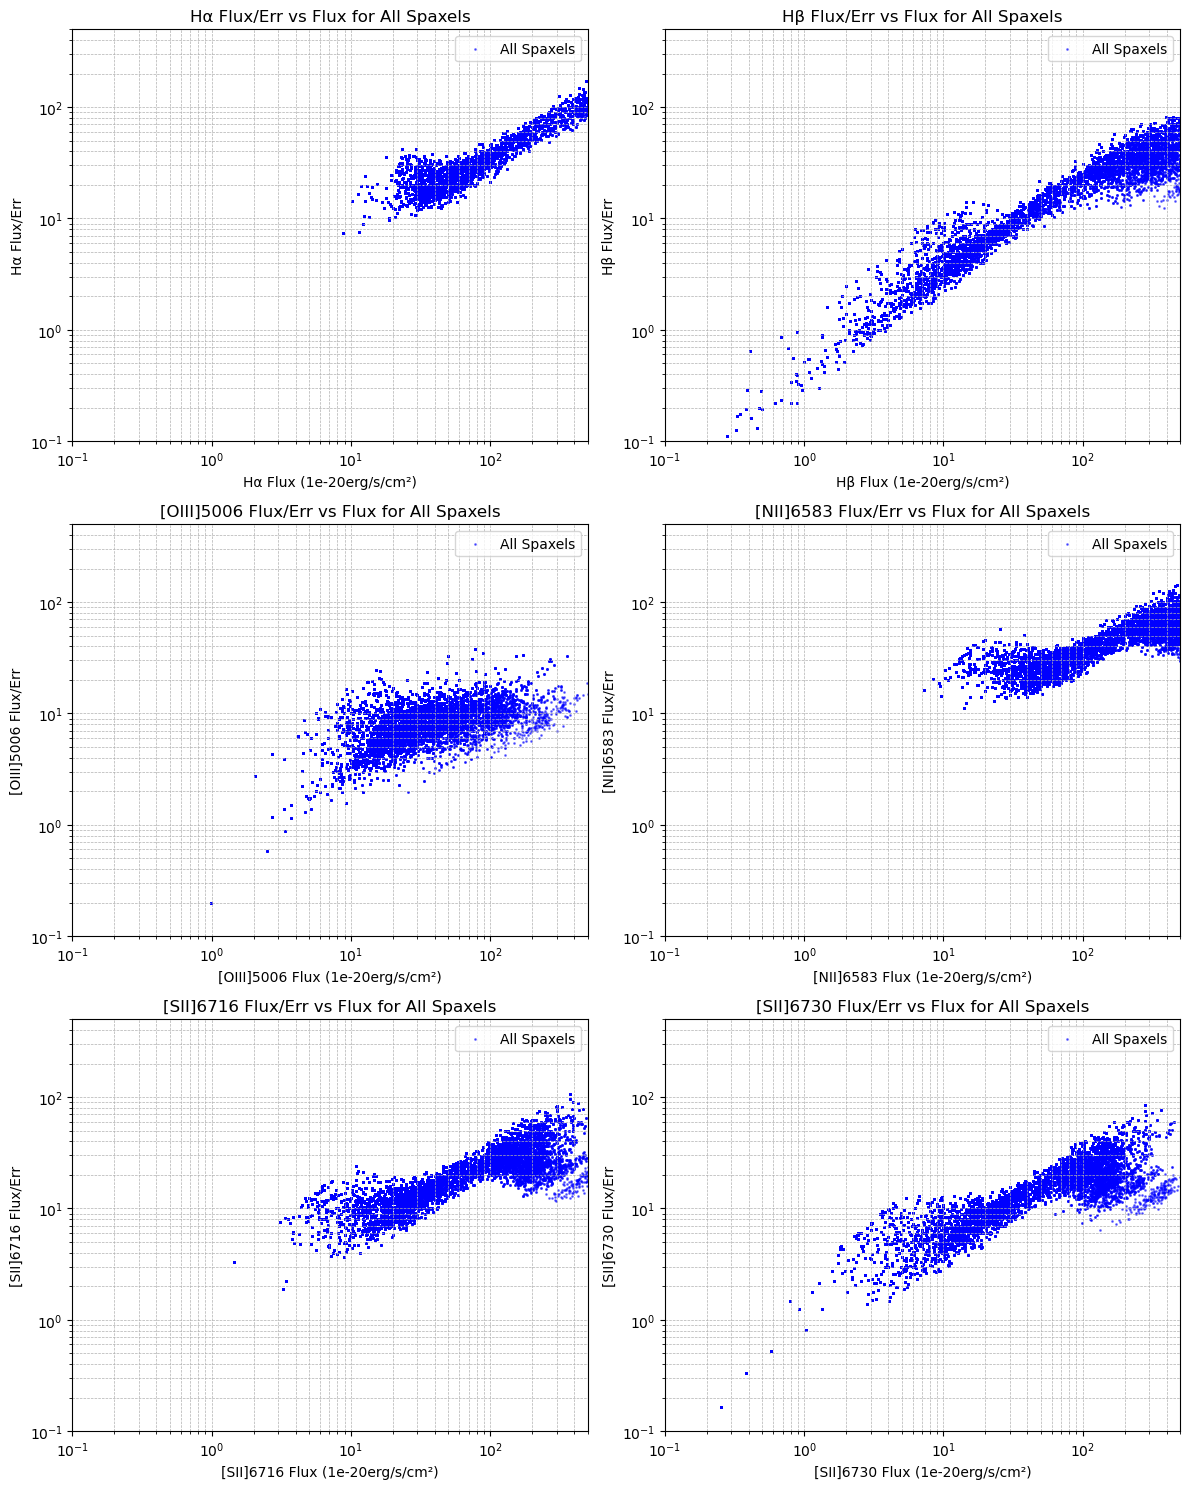

In [46]:
# Plot Flux/Err vs flux for all 6 emission lines
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Define the lines and their data
lines_data = [
    ('Hα', HA6562_FLUX, HA6562_FLUX_ERR),
    ('Hβ', HB4861_FLUX, HB4861_FLUX_ERR),
    ('[OIII]5006', OIII5006_FLUX, OIII5006_FLUX_ERR),
    ('[NII]6583', NII6583_FLUX, NII6583_FLUX_ERR),
    ('[SII]6716', SII6716_FLUX, SII6716_FLUX_ERR),
    ('[SII]6730', SII6730_FLUX, SII6730_FLUX_ERR)
]

# Plot each line
for i, (line_name, flux, flux_err) in enumerate(lines_data):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Calculate Flux/Err
    flux_over_err = flux / flux_err
    
    # Remove NaN values for plotting
    mask = ~np.isnan(flux) & ~np.isnan(flux_over_err)
    
    ax.scatter(flux[mask], flux_over_err[mask], 
               s=1, alpha=0.5, color='blue', label='All Spaxels')
    ax.set_xlabel(f'{line_name} Flux (1e-20erg/s/cm²)')
    ax.set_ylabel(f'{line_name} Flux/Err')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-1, 5e2)
    ax.set_ylim(1e-1, 5e2)
    ax.set_title(f'{line_name} Flux/Err vs Flux for All Spaxels')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

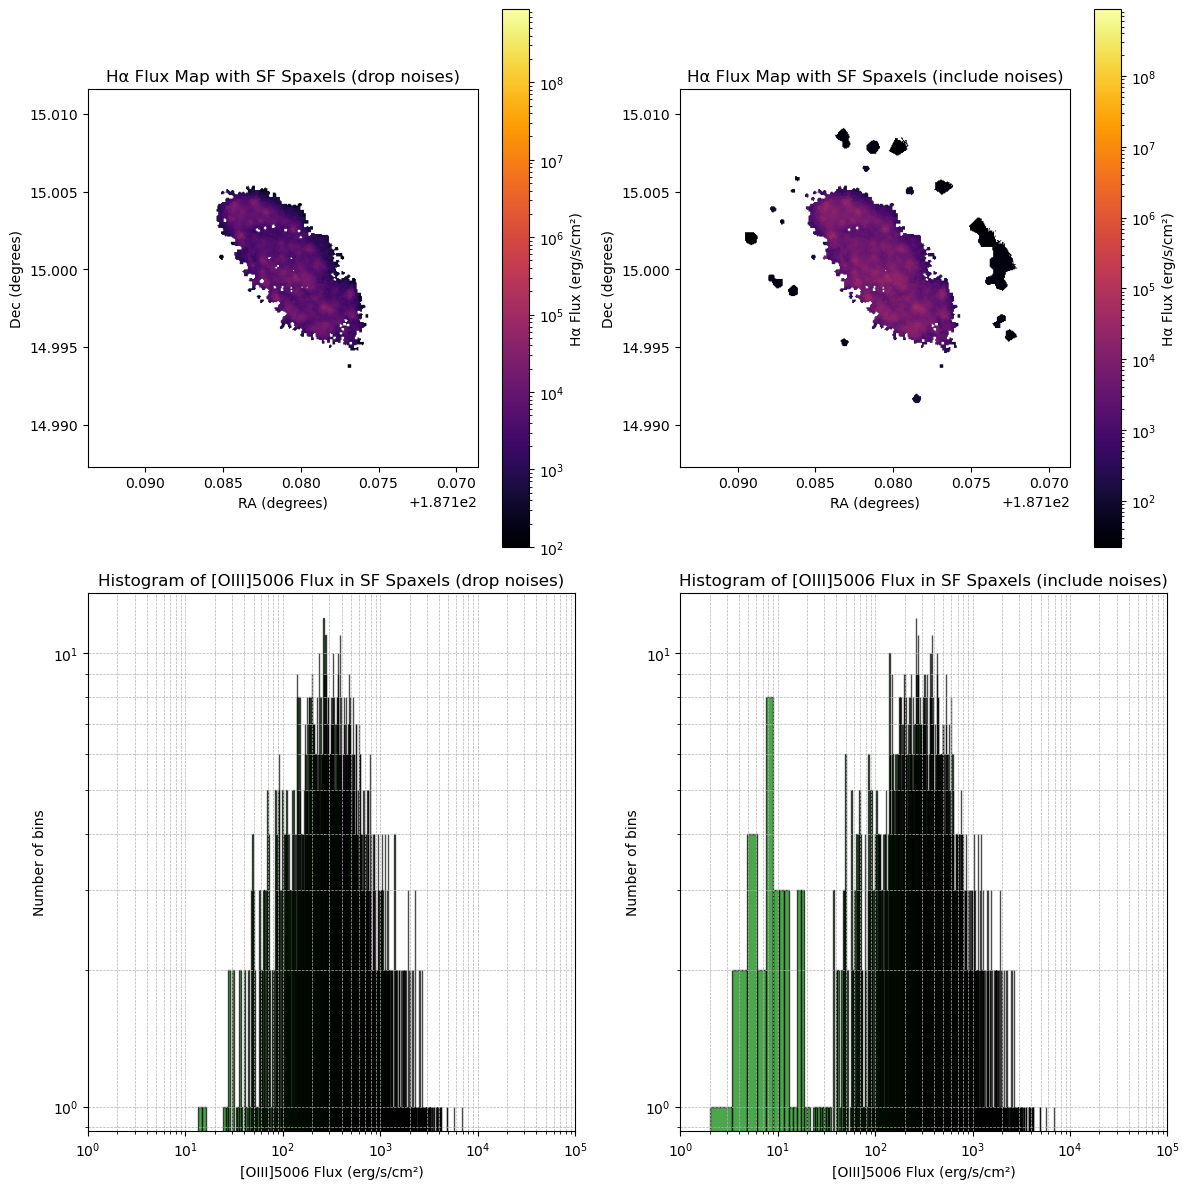

In [47]:
# Combined plot: Hα flux maps and [OIII]5006 flux histograms with and without noise filtering
plt.figure(figsize=(12, 12))

# Top left: Hα Flux Map with SF Spaxels (drop noises)
plt.subplot(2, 2, 1)
plt.imshow(np.where(mask_constraint&SF_mask&mask_QC_good, HA6562_FLUX_corr, np.nan), 
           origin='lower', cmap='inferno', extent=extent, 
           norm=LogNorm(vmax=np.nanmax(HA6562_FLUX_corr)))
plt.colorbar(label='Hα Flux (erg/s/cm²)')
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Hα Flux Map with SF Spaxels (drop noises)')

# Top right: Hα Flux Map with SF Spaxels (include noises)
plt.subplot(2, 2, 2)
plt.imshow(np.where(mask_constraint&SF_mask, HA6562_FLUX_corr, np.nan), 
           origin='lower', cmap='inferno', extent=extent, 
           norm=LogNorm(vmax=np.nanmax(HA6562_FLUX_corr)))
plt.colorbar(label='Hα Flux (erg/s/cm²)')
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Hα Flux Map with SF Spaxels (include noises)')

# Bottom left: Histogram of [OIII]5006 Flux in SF Spaxels (drop noises)
plt.subplot(2, 2, 3)
plt.hist(np.unique(OIII5006_FLUX_corr[mask_constraint&SF_mask&mask_QC_good]), 
             bins=5000, color='green', alpha=0.7, edgecolor='black')
plt.xlabel('[OIII]5006 Flux (erg/s/cm²)')
plt.ylabel('Number of bins')
plt.title('Histogram of [OIII]5006 Flux in SF Spaxels (drop noises)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0, 1e5)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Bottom right: Histogram of [OIII]5006 Flux in SF Spaxels (include noises)
plt.subplot(2, 2, 4)
plt.hist(np.unique(OIII5006_FLUX_corr[mask_constraint&SF_mask]), 
             bins=5000, color='green', alpha=0.7, edgecolor='black')
plt.xlabel('[OIII]5006 Flux (erg/s/cm²)')
plt.ylabel('Number of bins')
plt.title('Histogram of [OIII]5006 Flux in SF Spaxels (include noises)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0, 1e5)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

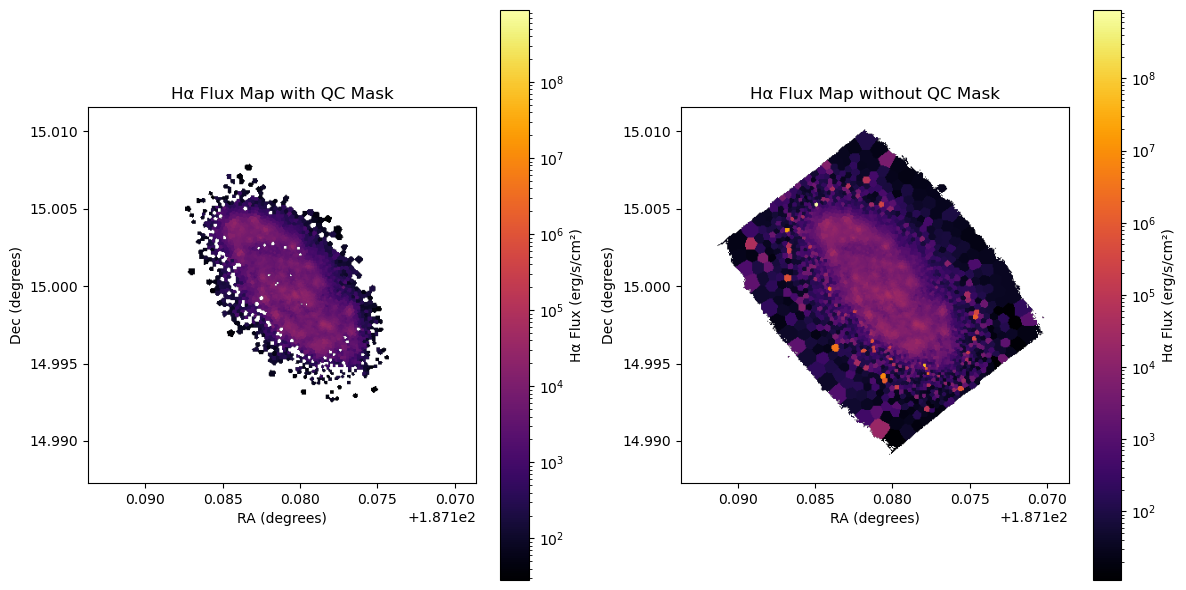

In [48]:
# Plot the H-alpha flux map with and without QC mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.where(mask_QC_good, HA6562_FLUX_corr, np.nan), 
           origin='lower', cmap='inferno', extent=extent, 
           norm=LogNorm(vmax=np.nanmax(HA6562_FLUX_corr)))
plt.colorbar(label='Hα Flux (erg/s/cm²)')
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Hα Flux Map with QC Mask')
plt.subplot(1, 2, 2)
plt.imshow(HA6562_FLUX_corr, 
           origin='lower', cmap='inferno', extent=extent, 
           norm=LogNorm(vmax=np.nanmax(HA6562_FLUX_corr)))
plt.colorbar(label='Hα Flux (erg/s/cm²)')
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Hα Flux Map without QC Mask')
plt.tight_layout()
plt.show()

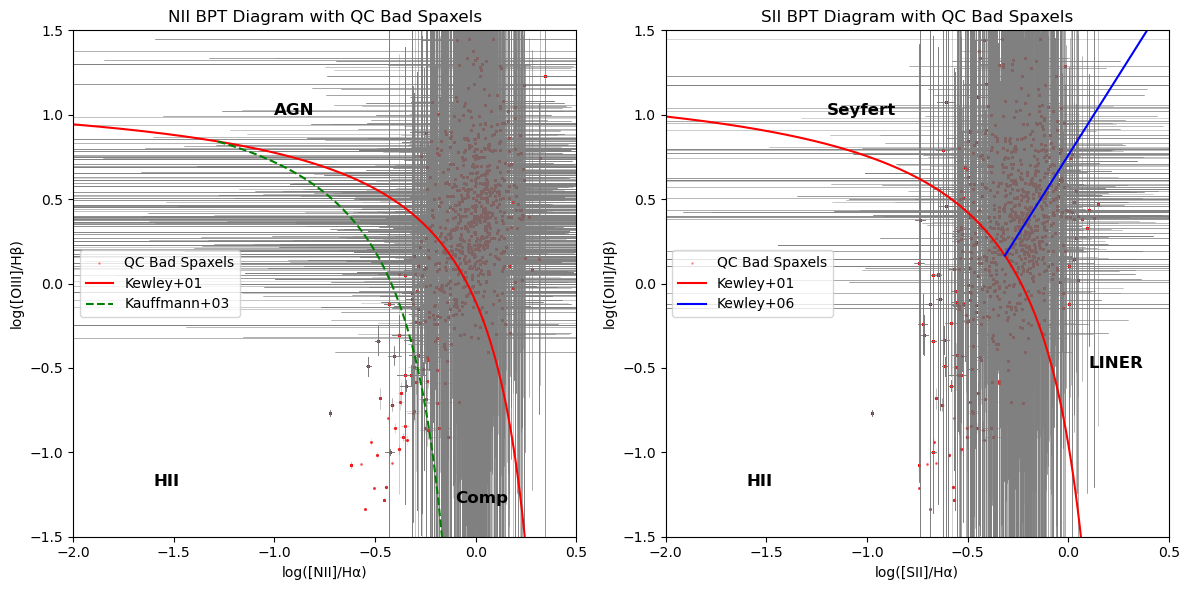

In [49]:
# plot the QC_bad spaxels in both BPT diagrams
plt.figure(figsize=(12, 6))
# NII BPT diagram with QC bad spaxels
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_QC_bad], logO3[mask_QC_bad], 
            s=1, alpha=0.3, color='red', label='QC Bad Spaxels')
plt.errorbar(logN2[mask_QC_bad], logO3[mask_QC_bad], 
             xerr=logN2_err[mask_QC_bad], yerr=logO3_err[mask_QC_bad],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g--', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram with QC Bad Spaxels')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')
# SII BPT diagram with QC bad spaxels
plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_QC_bad], logO3[mask_QC_bad], 
            s=1, alpha=0.3, color='red', label='QC Bad Spaxels')
plt.errorbar(logS2[mask_QC_bad], logO3[mask_QC_bad], 
             xerr=logS2_err[mask_QC_bad], yerr=logO3_err[mask_QC_bad],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram with QC Bad Spaxels')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')
plt.tight_layout()
plt.show()

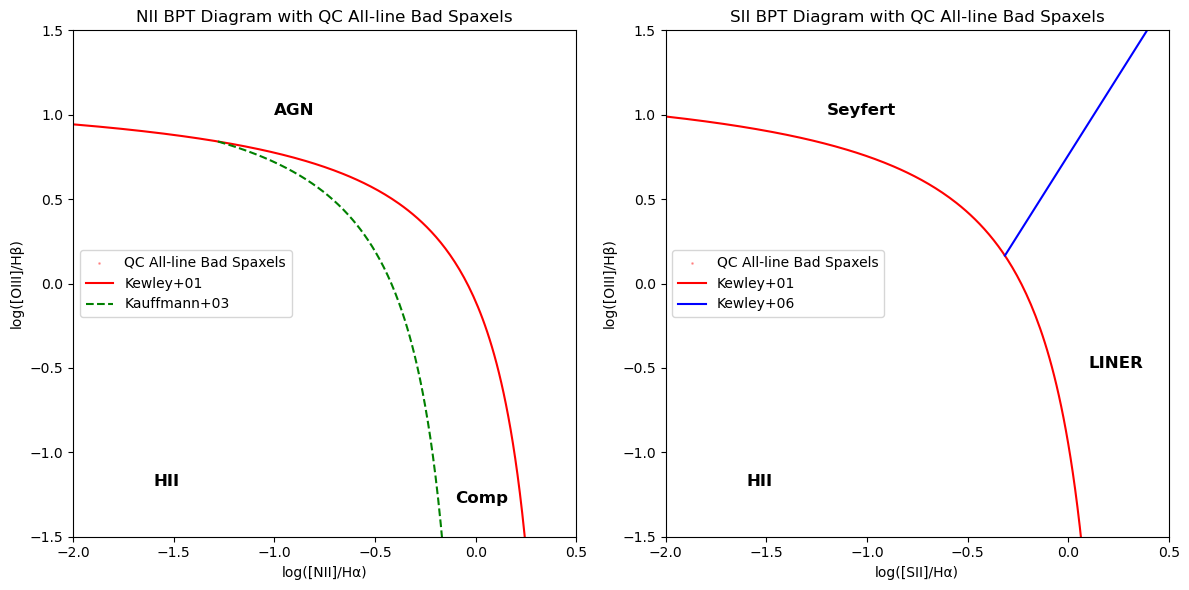

Number of QC all-line bad spaxels: 0


In [50]:
# plot the QC_all_bad spaxels in both BPT diagrams
plt.figure(figsize=(12, 6))
# NII BPT diagram with QC all-line bad spaxels
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_QC_all_bad], logO3[mask_QC_all_bad], 
            s=1, alpha=0.3, color='red', label='QC All-line Bad Spaxels')
plt.errorbar(logN2[mask_QC_all_bad], logO3[mask_QC_all_bad], 
             xerr=logN2_err[mask_QC_all_bad], yerr=logO3_err[mask_QC_all_bad],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g--', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram with QC All-line Bad Spaxels')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')
# SII BPT diagram with QC all-line bad spaxels
plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_QC_all_bad], logO3[mask_QC_all_bad], 
            s=1, alpha=0.3, color='red', label='QC All-line Bad Spaxels')
plt.errorbar(logS2[mask_QC_all_bad], logO3[mask_QC_all_bad], 
             xerr=logS2_err[mask_QC_all_bad], yerr=logO3_err[mask_QC_all_bad],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram with QC All-line Bad Spaxels')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')
plt.tight_layout()
plt.show()

# print the number of QC all-line bad spaxels
print(f'Number of QC all-line bad spaxels: {np.nansum(mask_QC_all_bad)}')

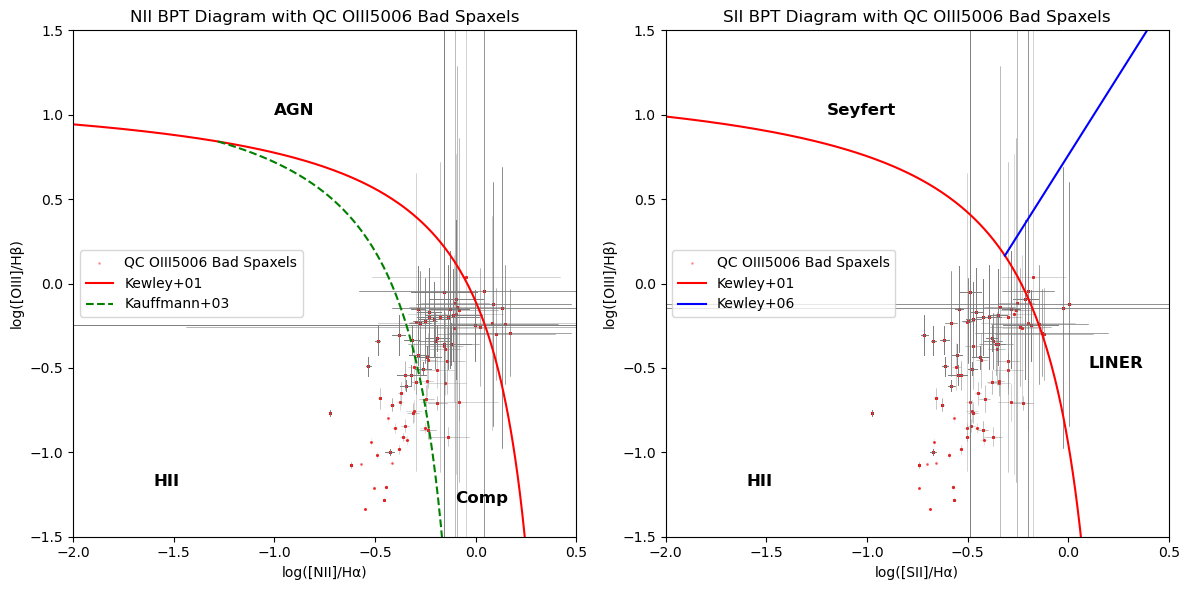

Number of QC OIII5006 bad spaxels: 4411


In [51]:
# plot the mask_QC_OIII5006_bad spaxels in both BPT diagrams
plt.figure(figsize=(12, 6))
# NII BPT diagram with QC OIII5006 bad spaxels
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_QC_OIII5006_bad], logO3[mask_QC_OIII5006_bad], 
            s=1, alpha=0.3, color='red', label='QC OIII5006 Bad Spaxels')
plt.errorbar(logN2[mask_QC_OIII5006_bad], logO3[mask_QC_OIII5006_bad], 
             xerr=logN2_err[mask_QC_OIII5006_bad], yerr=logO3_err[mask_QC_OIII5006_bad],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g--', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram with QC OIII5006 Bad Spaxels')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')
# SII BPT diagram with QC OIII5006 bad spaxels
plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_QC_OIII5006_bad], logO3[mask_QC_OIII5006_bad], 
            s=1, alpha=0.3, color='red', label='QC OIII5006 Bad Spaxels')
plt.errorbar(logS2[mask_QC_OIII5006_bad], logO3[mask_QC_OIII5006_bad], 
             xerr=logS2_err[mask_QC_OIII5006_bad], yerr=logO3_err[mask_QC_OIII5006_bad],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram with QC OIII5006 Bad Spaxels')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')
plt.tight_layout()
plt.show()

# print the number of QC OIII5006 bad spaxels
print(f'Number of QC OIII5006 bad spaxels: {np.nansum(mask_QC_OIII5006_bad)}')

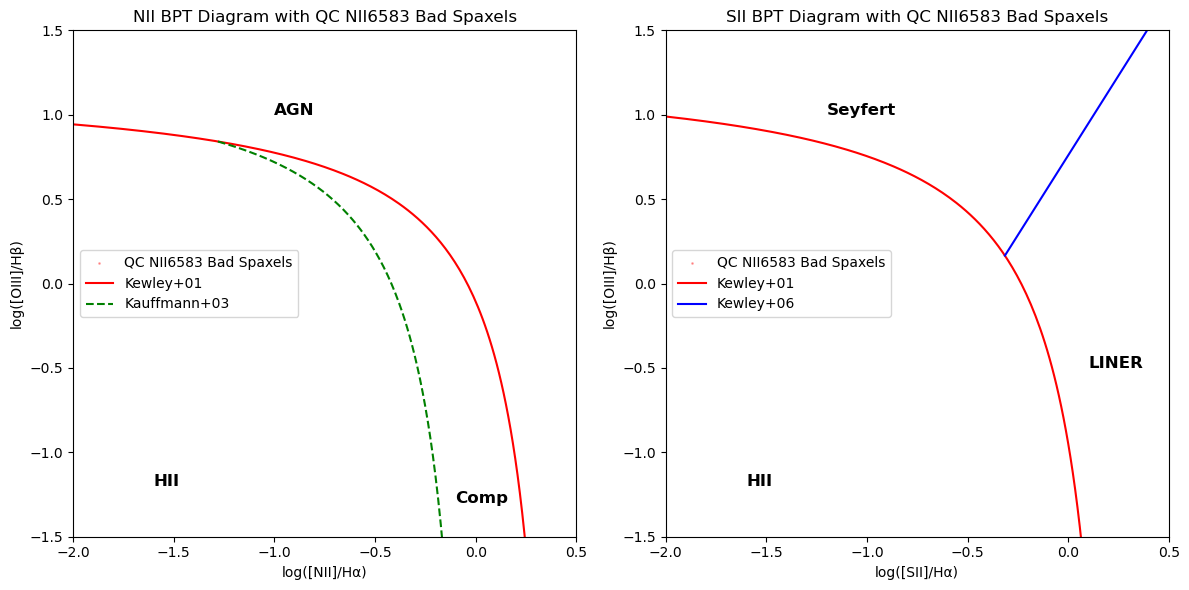

Number of QC NII6583 bad spaxels: 0


In [52]:
# plot the mask_QC_NII6583_bad spaxels in both BPT diagrams
plt.figure(figsize=(12, 6))
# NII BPT diagram with QC NII6583 bad spaxels
plt.subplot(1, 2, 1)
plt.scatter(logN2[mask_QC_NII6583_bad], logO3[mask_QC_NII6583_bad], 
            s=1, alpha=0.3, color='red', label='QC NII6583 Bad Spaxels')
plt.errorbar(logN2[mask_QC_NII6583_bad], logO3[mask_QC_NII6583_bad], 
             xerr=logN2_err[mask_QC_NII6583_bad], yerr=logO3_err[mask_QC_NII6583_bad],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_N2, kewley01_N2(x_kewley_N2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kauff_N2, kauff03_N2(x_kauff_N2), 'g--', lw=1.5, label='Kauffmann+03')
plt.xlabel('log([NII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('NII BPT Diagram with QC NII6583 Bad Spaxels')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-0.1, -1.3, 'Comp', fontsize=12, fontweight='bold')
plt.text(-1.0, 1.0, 'AGN', fontsize=12, fontweight='bold')
plt.legend(loc='center left')
# SII BPT diagram with QC NII6583 bad spaxels
plt.subplot(1, 2, 2)
plt.scatter(logS2[mask_QC_NII6583_bad], logO3[mask_QC_NII6583_bad], 
            s=1, alpha=0.3, color='red', label='QC NII6583 Bad Spaxels')
plt.errorbar(logS2[mask_QC_NII6583_bad], logO3[mask_QC_NII6583_bad], 
             xerr=logS2_err[mask_QC_NII6583_bad], yerr=logO3_err[mask_QC_NII6583_bad],
             fmt='none', alpha=0.05, color='gray', capsize=0, linewidth=0.5)
plt.plot(x_kewley_S2, kewley01_S2(x_kewley_S2), 'r-', lw=1.5, label='Kewley+01')
plt.plot(x_kewley06_S2, kewley06_Sy_LIN(x_kewley06_S2), 'b-', lw=1.5, label='Kewley+06')
plt.xlabel('log([SII]/Hα)')
plt.ylabel('log([OIII]/Hβ)')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.5, 1.5)
plt.title('SII BPT Diagram with QC NII6583 Bad Spaxels')
plt.text(-1.6, -1.2, 'HII', fontsize=12, fontweight='bold')
plt.text(-1.2, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
plt.text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')
plt.legend(loc='center left')
plt.tight_layout()
plt.show()

# print the number of QC NII6583 bad spaxels
print(f'Number of QC NII6583 bad spaxels: {np.nansum(mask_QC_NII6583_bad)}')